In [ ]:
from IPython.display import clear_output
!pip install datasets
!pip install arabic-reshaper python-bidi
clear_output()

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datasets
from datasets import load_dataset
import transformers
from transformers import BertTokenizer, AutoModel,BertModel
from google.colab import drive
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from bidi.algorithm import get_display
import arabic_reshaper
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
random.seed(0)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#data loading and preprocessing
class ExpoDataset_BERT(Dataset):
  def __init__(self,dataset_path,onehotencoder=None,tokenizer_name='UBC-NLP/MARBERT'):
    expodataset_features=datasets.Features({'Tweet':datasets.Value('string'),'Class':datasets.Value('string')})
    self.dataset=load_dataset("csv", data_files=dataset_path,features=expodataset_features,split='train')
    self.tokenizer=BertTokenizer.from_pretrained(tokenizer_name)
    self.onehotencoder=onehotencoder if onehotencoder else OneHotEncoder()
    self.onehotencoder.fit(np.reshape(self.dataset[:]['Class'],(-1,1)))
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,idx):
    item=self.tokenizer(str(self.dataset[idx]['Tweet']),add_special_tokens=True,max_length=44,padding='max_length',truncation=True,return_tensors='pt')

    item['label']=torch.tensor(self.onehotencoder.transform([[self.dataset[idx]['Class']]]).toarray())[0]
    item['input_ids']=item['input_ids'][0]
    item['attention_mask']=item['attention_mask'][0]
    return item

In [ ]:
dataset=ExpoDataset_BERT('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv')
test_dataset=ExpoDataset_BERT('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv',dataset.onehotencoder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: Futur

In [ ]:
print(dataset[0])

{'input_ids': tensor([    2, 37540,  9242,  9703,  1018,  9007,  3580, 37784,  4818,  8671,
        45938, 16667, 22418, 38976,  1046,  8385, 50291, 57732, 65864,  2002,
        40973, 50045,  1017, 28555,  3781,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'label': tensor([1., 0., 0.], dtype=torch.float64)}


In [ ]:
seed = torch.Generator().manual_seed(42)
train_set,val_set=torch.utils.data.random_split(dataset,[0.85,0.15], generator=seed)
len(train_set),len(val_set)

(6375, 1125)

In [ ]:
full_dataloader=DataLoader(dataset,pin_memory=True,num_workers=8,batch_size=64,shuffle=True)
train_loader=DataLoader(train_set,pin_memory=True,num_workers=8,batch_size=64,shuffle=True)
val_loader=DataLoader(val_set,pin_memory=True,num_workers=8,batch_size=64,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#helper function to automate the loss and accuracy plots
def plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies):
  plt.subplots(figsize=(12,4))
  plt.subplot(121)
  plt.plot(train_total_loss,label='train')
  if len(val_total_loss)!=0:
    plt.plot(val_total_loss,label='val')
  plt.title('Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(train_accuracies,label='train')
  if len(val_accuracies)!=0:
    plt.plot(val_accuracies,label='val')
  plt.title('Accuracies')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def visualize(text_ids,weights,predictions,labels):

  positives_weights = weights[labels == 2]
  negatives_weights = weights[labels == 0]
  neutrals_weights = weights[labels == 1]

  positives_text_ids = text_ids[labels == 2]
  negatives_text_ids = text_ids[labels == 0]
  neutrals_text_ids = text_ids[labels == 1]

  # Randomly selecting indices for each class
  positive_indices = np.random.choice(np.arange(len(positives_weights)), size=1)
  negative_indices = np.random.choice(np.arange(len(negatives_weights)), size=1)
  neutral_indices = np.random.choice(np.arange(len(neutrals_weights)), size=1)

  fig, axs = plt.subplots(3, figsize=(10, 6))
  #axs = [axs]  # Ensure axs is iterable if there's only one plot
  #print('axs=',type(axs[0]),axs[0])
  # Function to plot heatmaps for a given class
  def plot_heatmaps(indecies, text_ids_, weights_, ax_row):
      for index in indecies:
          text = dataset.tokenizer.decode(text_ids_[index]).split(' ')
          reshaped_text = [arabic_reshaper.reshape(token) for token in text]
          bidi_text = [get_display(token) for token in reshaped_text]
          correct_weight = weights_[index]

          # Create the heatmap for the current index
          heatmap = axs[ax_row].imshow([correct_weight], cmap='YlGnBu', aspect='auto')

          # Set the tokens as x-ticks
          axs[ax_row].set_xticks(np.arange(len(bidi_text)))
          axs[ax_row].set_xticklabels(bidi_text, rotation=90)

          # Remove y-ticks
          axs[ax_row].set_yticks([])
      plt.tight_layout()
      return heatmap

  # Plot heatmaps for positive, negative, and neutral predictions
  heatmap=plot_heatmaps(negative_indices, negatives_text_ids, negatives_weights, 0)  # Row 0 for negative
  heatmap=plot_heatmaps(neutral_indices, neutrals_text_ids, neutrals_weights, 1)  # Row 1 for neutral
  heatmap=plot_heatmaps(positive_indices, positives_text_ids, positives_weights, 2)     # Row 2 for positive

  # Set overall titles for each row
  axs[0].set_ylabel('Negative', rotation=0, labelpad=50, fontsize=12)
  axs[1].set_ylabel('Neutral', rotation=0, labelpad=50, fontsize=12)
  axs[2].set_ylabel('Positive', rotation=0, labelpad=50, fontsize=12)

  # Create a single color bar for the entire figure
  cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.8])  # [left, bottom, width, height]
  plt.colorbar(heatmap, cax=cbar_ax)

  plt.suptitle('Attention Weights', fontsize=16, x=0.5, y=1.02)  # Adjust the y-position for the title
  #plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
  plt.show()

In [ ]:
# Test on the test_loader
def test_and_report(model,test_loader,model_name,attention_added=False):
  model.eval()
  predictions=[]
  labels=[]
  test_total_dataitem=0
  test_correct=0
  input_ids_list=[]
  attention_weights=[]
  correct_answers=[]
  all_labels=[]
  with torch.no_grad():
      for batch in test_loader:
          input_ids,attention_mask,label=batch.input_ids.to(device),batch.attention_mask.to(device),batch.label.to(device)
          output=model(input_ids,attention_mask)
          if attention_added:
            attention_weights.extend(output[1].cpu().numpy())
            output=output[0]



          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          test_total_dataitem += label.size(0)
          test_correct += (predicted == label.argmax(axis=1)).sum()
          predictions.extend(predicted.cpu().numpy())
          labels.extend(label.argmax(axis=1).cpu().numpy())

          input_ids_list.extend(input_ids.cpu().numpy())
          all_labels.extend(label.argmax(axis=1).cpu().numpy())
          correct_answers.extend((predicted == label.argmax(axis=1)).cpu().numpy())


  test_accuracy = test_correct/test_total_dataitem
  print(f'Test correct = {test_correct}\n')
  print(f'Test total dataitem = {test_total_dataitem}\n')
  print(f'Test Accuracy = {test_accuracy}\n')
  print(classification_report(labels,predictions,target_names=['negative','neutral','positive']))
  fig,ax=plt.subplots(figsize=(5, 5))
  ConfusionMatrixDisplay.from_predictions(labels,predictions,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
  plt.title(f'Confusion Matrix of {model_name}')
  plt.show()
  if attention_added:
    visualize(np.array(input_ids_list),np.array(attention_weights),correct_answers,np.array(all_labels))

In [ ]:
#helper function to automate the training loop
def train(model,epochs,optimizer,criterion,train_loader,val_loader=None,attention_added=False):
  train_total_loss=[]
  val_total_loss=[]
  train_accuracies=[]
  val_accuracies=[]
  for epoch in range(epochs):
    train_losses=0
    val_losses=0
    train_total_dataitem=0
    train_correct=0
    tqdm_par=tqdm(train_loader,desc=f'Epoch {epoch+1}')
    #tqdm_par.set_description(f'Epoch {epoch+1}')
    model.train() #training mode
    for batch in tqdm_par:
      input_ids,attention_mask,label=batch.input_ids.to(device),batch.attention_mask.to(device),batch.label.to(device)
      output=model(input_ids,attention_mask)
      if attention_added:
        output=output[0]
      train_loss=criterion(output,label)
      optimizer.zero_grad()
      train_losses+=train_loss.item()
      train_loss.backward()
      optimizer.step()
      # Compute the accuracy
      y_pred=F.softmax(output,dim=1)
      predicted = y_pred.argmax(axis=1)
      train_total_dataitem += label.size(0)
      train_correct += (predicted == label.argmax(axis=1)).sum()
    train_accuracy = train_correct / train_total_dataitem

    if val_loader:
      model.eval() #evaluation mode
      with torch.no_grad():
        val_total_dataitem=0
        val_correct=0
        for batch in val_loader:
          input_ids,attention_mask,label=batch.input_ids.to(device),batch.attention_mask.to(device),batch.label.to(device)
          output=model(input_ids,attention_mask)
          if attention_added:
            output=output[0]
          val_loss=criterion(output,label)
          val_losses+=val_loss.item()
          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          val_total_dataitem += label.size(0)
          val_correct += (predicted == label.argmax(axis=1)).sum()
      val_accuracy = val_correct/val_total_dataitem

    tqdm_par.refresh()
    train_total_loss.append(train_losses/len(train_loader))
    train_accuracies.append(train_accuracy.cpu())
    if val_accuracy>=0.775:
      print(f"A model was saved at accuracy = {val_accuracy}")
      torch.save(model.state_dict(),f'/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-LSTM.pth')
    if val_loader:
      val_total_loss.append(val_losses/len(val_loader))
      val_accuracies.append(val_accuracy.cpu())
      print(f'loss = {train_losses/len(train_loader)}, val_loss ={val_losses/len(val_loader)}, accuracy = {train_accuracy}, val_accuracy = {val_accuracy}')
    else:
      print(f'loss = {train_losses/len(train_loader)}, accuracy = {train_accuracy}')

  plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies)

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, rnn_size):
        super(AttentionLayer, self).__init__()
        self.U = nn.Linear(rnn_size, 1,bias=False) # for the learnable paramter u
        torch.nn.init.xavier_normal_(self.U.weight)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden_states):
        # α = softmax(u_t^T U)
        attention_weights = self.U(hidden_states) # (batch_size, seq_len ,1)
        attention_weights = self.softmax(attention_weights.squeeze(2))  # (batch_size, seq_len)

        # eq.11: v = sum( α * hidden_states )
        attention_output = hidden_states * attention_weights.unsqueeze(2)  # (batch_size, seq_len, rnn_size)
        attention_output = attention_output.sum(dim = 1)  # (batch_size, rnn_size)

        return attention_output, attention_weights

In [ ]:
class AttentionRNN_AraBERT(nn.Module):
  def __init__(self,hidden_size1,hidden_size2,num_layers,dider=True,droprate=0.2,num_classes=3):
    super().__init__()
    self.bert=BertModel.from_pretrained('UBC-NLP/MARBERT')
    # freeze the bert weights
    for param in self.bert.parameters():
      param.requires_grad=False

    self.embedding_dim=self.bert.config.hidden_size
    self.rnn_hidden_size=hidden_size1
    self.rnn=nn.RNN(self.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.attention=AttentionLayer(hidden_size1*self.d)
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    # For Improvements, I've changed the intialization algorithm
    #initialize the rnn weights
    for name,param in self.rnn.named_parameters():
      if 'weight' in name:
        nn.init.xavier_normal_(param)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
  def forward(self,input_ids,attention_mask):
    with torch.no_grad():
      embeddings=self.bert(input_ids,attention_mask)
    x=embeddings[0]
    x=self.dropout(x)
    x,h=self.rnn(x)
    x,attention_weights=self.attention(x)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x,attention_weights

You're on a cuda


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


loss = 0.9470636558339659, val_loss =0.8391457969445965, accuracy = 0.5474510192871094, val_accuracy = 0.6466666460037231


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


loss = 0.7025750871629656, val_loss =1.1055284244746812, accuracy = 0.7043137550354004, val_accuracy = 0.6493332982063293


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


loss = 0.6381857847261155, val_loss =1.1753308937471136, accuracy = 0.738196074962616, val_accuracy = 0.562666654586792


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.6187458557977505, val_loss =0.7559640887019392, accuracy = 0.7452549338340759, val_accuracy = 0.6826666593551636


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


loss = 0.6473155886142837, val_loss =0.7444880418112283, accuracy = 0.7303529381752014, val_accuracy = 0.6853333115577698


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


loss = 0.6014461912373382, val_loss =0.7399904856315449, accuracy = 0.7516862750053406, val_accuracy = 0.6919999718666077


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.5638608650848077, val_loss =0.6554956990649916, accuracy = 0.7672157287597656, val_accuracy = 0.734666645526886


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.5577771644348322, val_loss =0.7043779278462444, accuracy = 0.7730196118354797, val_accuracy = 0.7160000205039978


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5306538238914889, val_loss =0.8117215548314772, accuracy = 0.786980390548706, val_accuracy = 0.690666675567627


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5308629211666639, val_loss =0.6539886082463309, accuracy = 0.7874509692192078, val_accuracy = 0.7253333330154419


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.5532332281615623, val_loss =0.8414906595938559, accuracy = 0.7701960802078247, val_accuracy = 0.653333306312561


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 0.5335652684235261, val_loss =0.6958820114320284, accuracy = 0.7803921699523926, val_accuracy = 0.7239999771118164


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.5166424125705052, val_loss =0.9541473064275151, accuracy = 0.7877647280693054, val_accuracy = 0.6506666541099548


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5225825542893011, val_loss =0.7190513252297525, accuracy = 0.7902745008468628, val_accuracy = 0.7053333520889282


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


loss = 0.4970989023433253, val_loss =0.6483244390310837, accuracy = 0.7945098280906677, val_accuracy = 0.7413333058357239


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.5035057274709946, val_loss =0.6865641906887228, accuracy = 0.7934117913246155, val_accuracy = 0.7373332977294922


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


loss = 0.49164306670968466, val_loss =0.7101562698967757, accuracy = 0.7981176376342773, val_accuracy = 0.690666675567627


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.5070303058503136, val_loss =0.8632414488616381, accuracy = 0.7935686707496643, val_accuracy = 0.6893333196640015


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.4923654573644462, val_loss =0.8112661942930842, accuracy = 0.8062745332717896, val_accuracy = 0.6840000152587891


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.4810113295485657, val_loss =0.7569849758353708, accuracy = 0.8112941384315491, val_accuracy = 0.7106666564941406


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


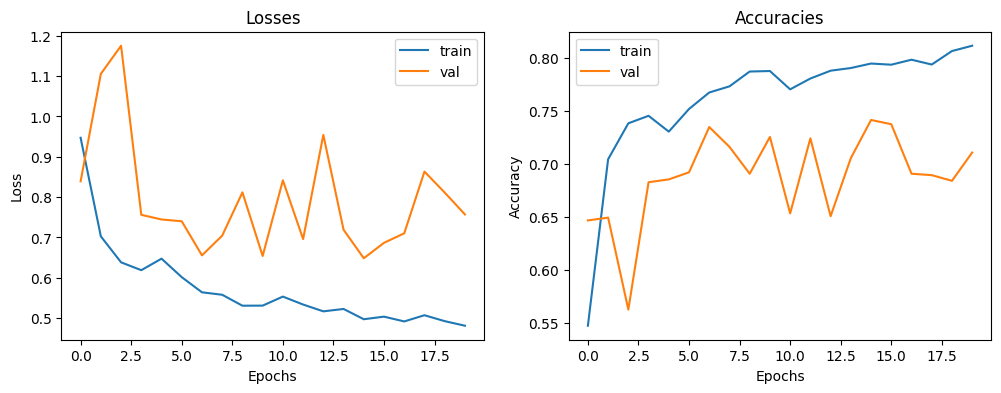

Test correct = 533

Test total dataitem = 750

Test Accuracy = 0.7106666564941406

              precision    recall  f1-score   support

    negative       0.83      0.62      0.71       250
     neutral       0.67      0.76      0.71       250
    positive       0.67      0.76      0.71       250

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750



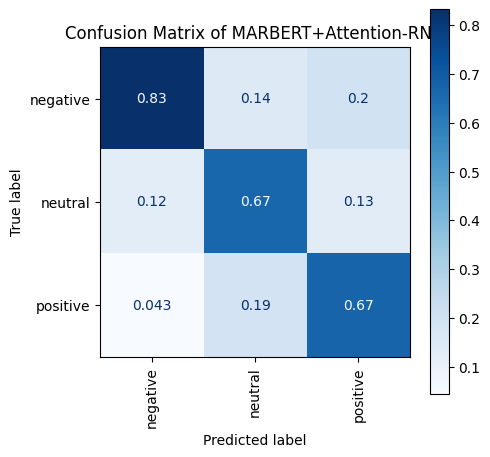

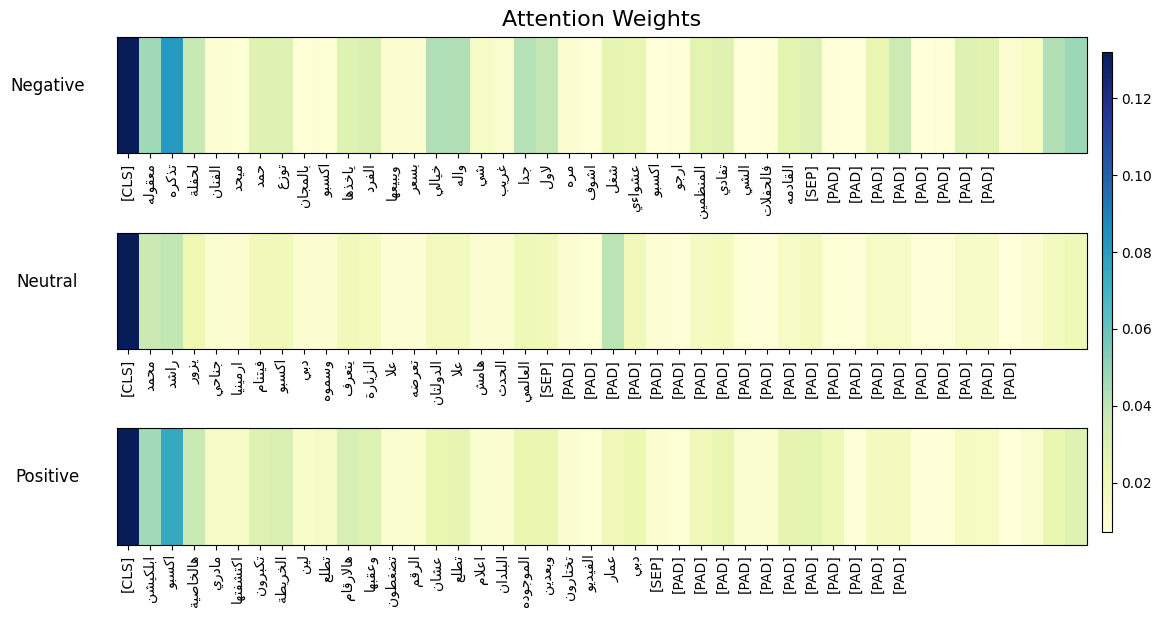

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
hidden_size1=512 #RNN layer hidden size
hidden_size2=128 #fully-connected layer hidden size
num_layers=1 #number of RNN layers
bidirectional=True
droprate=0.4
learning_rate=0.001
epoch=20
model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
model_name='MARBERT+Attention-RNN'
test_and_report(model,test_loader,model_name,attention_added=True)

## Attention-Based Model Hyperparameter tuning

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


loss = 0.9091310371606578, val_loss =0.7703485236490741, accuracy = 0.5749019980430603, val_accuracy = 0.6599999666213989


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.684733815358024, val_loss =0.9369572748753234, accuracy = 0.7112156748771667, val_accuracy = 0.6359999775886536


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 0.6408589560499129, val_loss =0.7228400456436814, accuracy = 0.7218823432922363, val_accuracy = 0.7053333520889282


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.6109251971004355, val_loss =0.8943751040014173, accuracy = 0.7460392117500305, val_accuracy = 0.637333333492279


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


loss = 0.5999803409866391, val_loss =0.7710904564846319, accuracy = 0.7472941279411316, val_accuracy = 0.7053333520889282


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.5661479634140432, val_loss =0.6994581346321945, accuracy = 0.7700392603874207, val_accuracy = 0.7239999771118164


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


loss = 0.548712545875393, val_loss =0.7495218400461625, accuracy = 0.7716078758239746, val_accuracy = 0.6759999990463257


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


loss = 0.5371645025639203, val_loss =0.8202833517494331, accuracy = 0.7756862640380859, val_accuracy = 0.6759999990463257


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.5426254575553924, val_loss =0.8088513879885294, accuracy = 0.7733333706855774, val_accuracy = 0.6866666674613953


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.52242044755402, val_loss =0.6698188688049518, accuracy = 0.7858823537826538, val_accuracy = 0.734666645526886


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.509679006798442, val_loss =0.8005098609474784, accuracy = 0.791372537612915, val_accuracy = 0.6759999990463257


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


loss = 0.5085362080656219, val_loss =0.7468751764875945, accuracy = 0.7905882596969604, val_accuracy = 0.6800000071525574


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


loss = 0.5119939166155929, val_loss =0.6717000265721187, accuracy = 0.7901176810264587, val_accuracy = 0.7133333086967468


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.5308686937079242, val_loss =0.7509103157630754, accuracy = 0.7850980758666992, val_accuracy = 0.6986666321754456


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.5226050754860921, val_loss =0.7472946570956148, accuracy = 0.7918431758880615, val_accuracy = 0.6866666674613953


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.5092326697884628, val_loss =0.8977147377816014, accuracy = 0.79560786485672, val_accuracy = 0.6773333549499512


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.4851907675496262, val_loss =0.7165971304613868, accuracy = 0.8054901957511902, val_accuracy = 0.7266666293144226


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.474984569632662, val_loss =0.6916986212202086, accuracy = 0.8061176538467407, val_accuracy = 0.7133333086967468


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.4862298812536704, val_loss =1.1432054407841596, accuracy = 0.8036078810691833, val_accuracy = 0.6173333525657654


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.5115606891076717, val_loss =0.7846939782308597, accuracy = 0.79560786485672, val_accuracy = 0.687999963760376


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


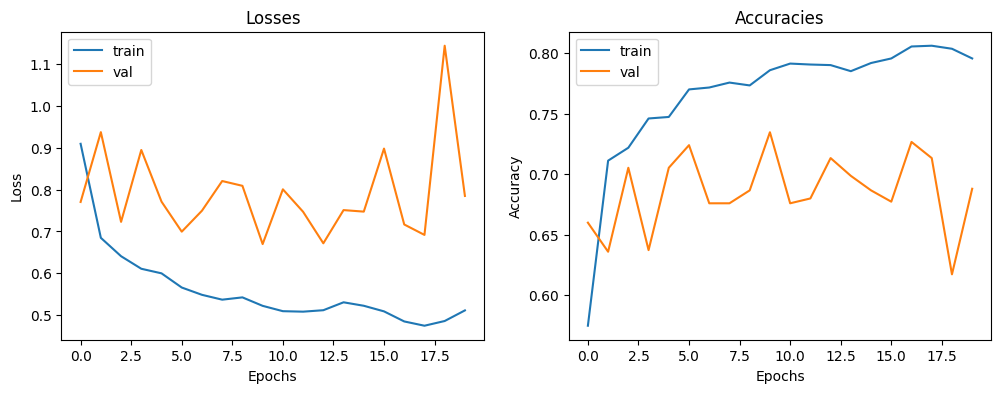

Bidirectional = True
Test correct = 516

Test total dataitem = 750

Test Accuracy = 0.687999963760376

              precision    recall  f1-score   support

    negative       0.83      0.54      0.65       250
     neutral       0.68      0.70      0.69       250
    positive       0.63      0.82      0.71       250

    accuracy                           0.69       750
   macro avg       0.71      0.69      0.68       750
weighted avg       0.71      0.69      0.68       750



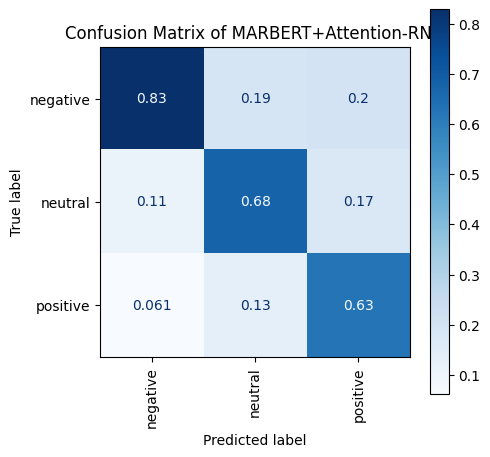

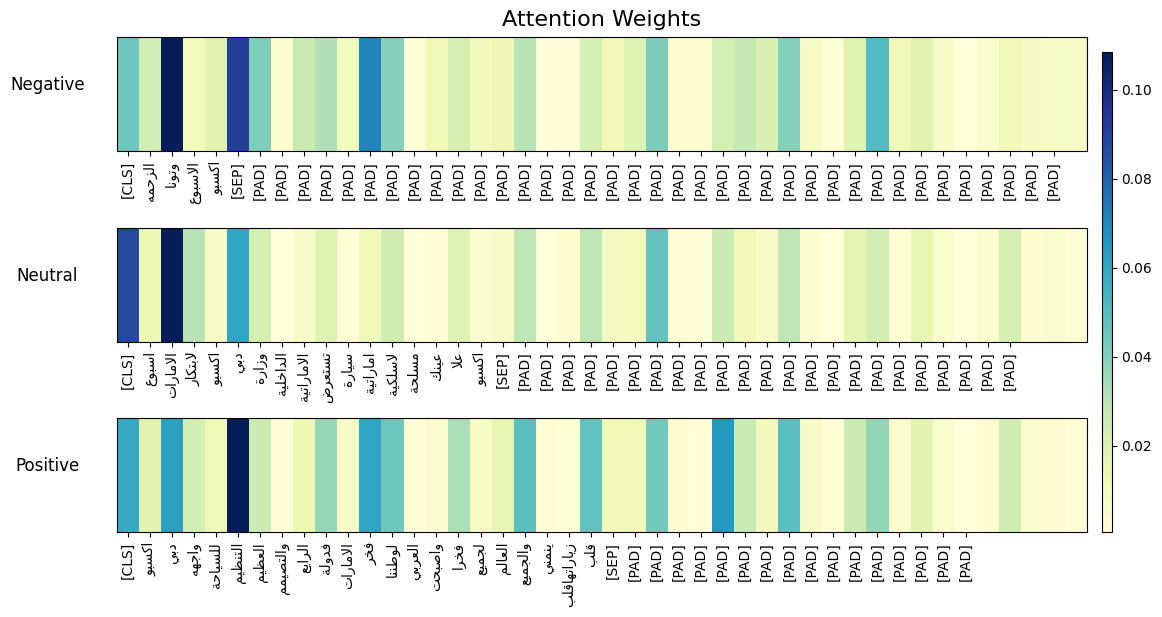

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.8980252864519305, val_loss =0.7577469984503494, accuracy = 0.5816470980644226, val_accuracy = 0.6666666865348816


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.6840767757941296, val_loss =0.7730904765845955, accuracy = 0.7066667079925537, val_accuracy = 0.656000018119812


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.63949604698486, val_loss =0.7168382695138501, accuracy = 0.7301961183547974, val_accuracy = 0.6959999799728394


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.619870787240396, val_loss =0.7100361099243816, accuracy = 0.7361568808555603, val_accuracy = 0.7106666564941406


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5812811457155229, val_loss =0.7483176353022887, accuracy = 0.7576470971107483, val_accuracy = 0.687999963760376


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.5774239681693947, val_loss =0.7343427564399699, accuracy = 0.7557647228240967, val_accuracy = 0.7013333439826965


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.5554674457676267, val_loss =0.7131919290505749, accuracy = 0.7676863074302673, val_accuracy = 0.7080000042915344


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5442424264466037, val_loss =0.8602946142957172, accuracy = 0.7763137221336365, val_accuracy = 0.6573333144187927


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.5487549305989975, val_loss =0.8018287397211399, accuracy = 0.7723921537399292, val_accuracy = 0.7306666374206543


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5466018678693426, val_loss =0.7097263023843069, accuracy = 0.7690980434417725, val_accuracy = 0.7400000095367432


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5257401127005253, val_loss =0.6971084455813333, accuracy = 0.7786666750907898, val_accuracy = 0.7160000205039978


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.5061800204462041, val_loss =0.7561137398925643, accuracy = 0.7926274538040161, val_accuracy = 0.7133333086967468


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4921148812266487, val_loss =0.6662207571732878, accuracy = 0.7998431324958801, val_accuracy = 0.7306666374206543


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.49851215442575736, val_loss =0.6920791115961406, accuracy = 0.7929412126541138, val_accuracy = 0.7199999690055847


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.479216516438215, val_loss =0.7109274220672201, accuracy = 0.8032941222190857, val_accuracy = 0.7199999690055847


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.47705137287211513, val_loss =1.0699359851011094, accuracy = 0.8003137707710266, val_accuracy = 0.6520000100135803


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.47272788295130735, val_loss =0.7433349864411601, accuracy = 0.8031373023986816, val_accuracy = 0.7519999742507935


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4714070507332576, val_loss =0.7195572624037015, accuracy = 0.8042353391647339, val_accuracy = 0.7093333005905151


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4589845925993803, val_loss =0.7946762665697742, accuracy = 0.8094117641448975, val_accuracy = 0.7053333520889282


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


loss = 0.46849794468342487, val_loss =0.693004833545297, accuracy = 0.8117647171020508, val_accuracy = 0.7386666536331177


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


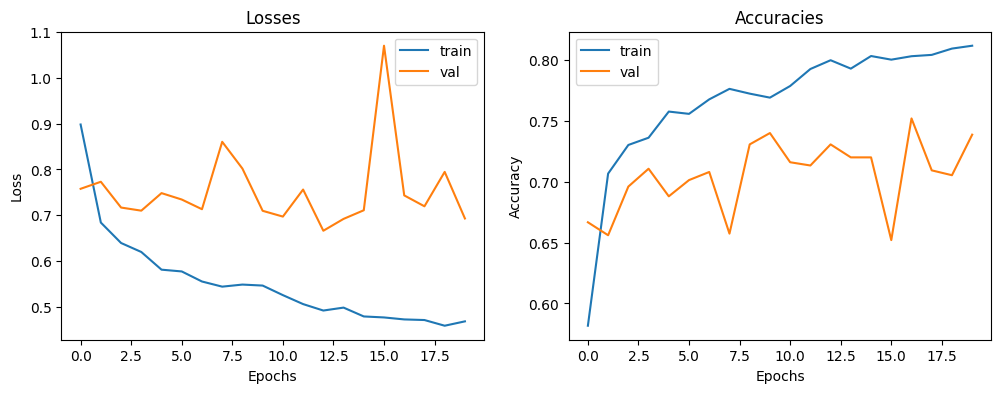

Bidirectional = False
Test correct = 554

Test total dataitem = 750

Test Accuracy = 0.7386666536331177

              precision    recall  f1-score   support

    negative       0.79      0.74      0.77       250
     neutral       0.78      0.66      0.71       250
    positive       0.67      0.82      0.73       250

    accuracy                           0.74       750
   macro avg       0.75      0.74      0.74       750
weighted avg       0.75      0.74      0.74       750



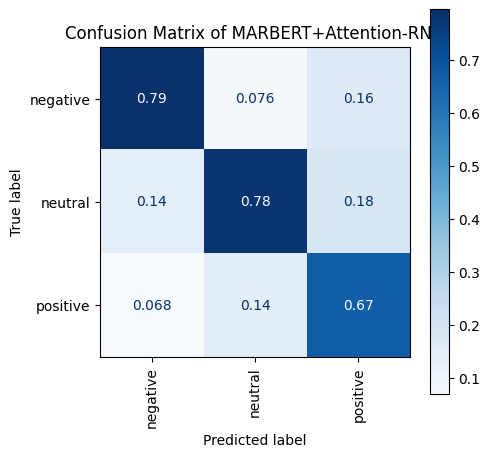

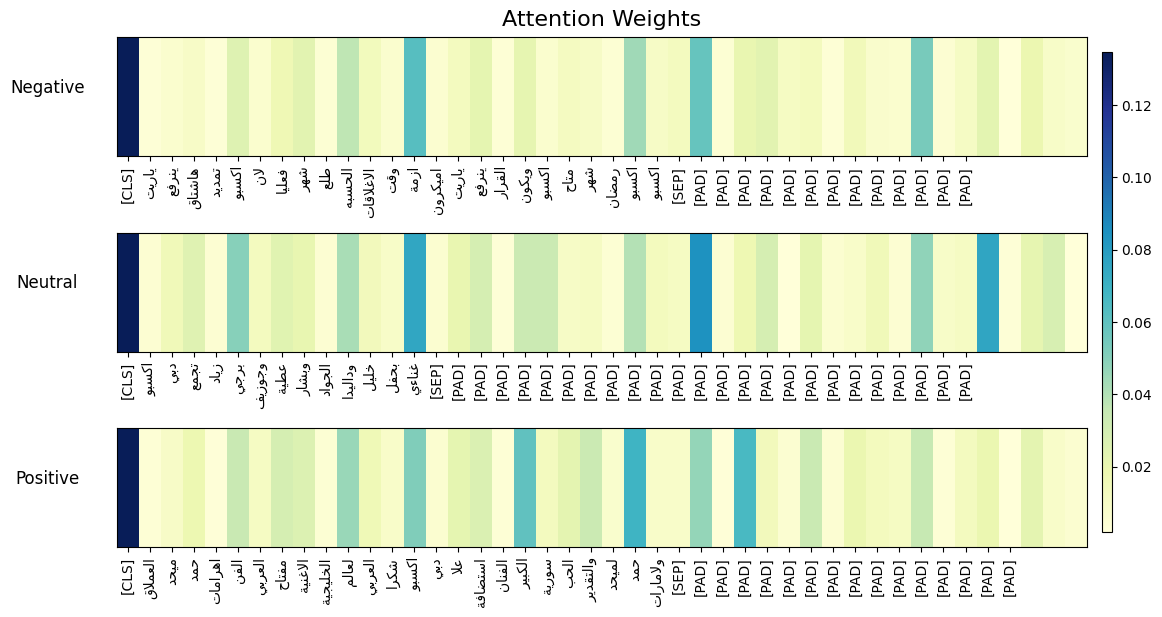

In [ ]:
bidirectional_options=[True,False]
for bidirectional1 in bidirectional_options:
  model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional1,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
  print(f'Bidirectional = {bidirectional1}')
  test_and_report(model,test_loader,model_name,attention_added=True)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


loss = 0.8936403980480813, val_loss =0.7632556581640687, accuracy = 0.5767843127250671, val_accuracy = 0.6826666593551636


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


loss = 0.7192236186222829, val_loss =0.7192682523074335, accuracy = 0.6869019865989685, val_accuracy = 0.6866666674613953


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 0.6658150973190815, val_loss =0.716549981616402, accuracy = 0.7190588116645813, val_accuracy = 0.7199999690055847


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.6430827213054269, val_loss =0.7262811768008417, accuracy = 0.7272157073020935, val_accuracy = 0.6933333277702332


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.6329448355784633, val_loss =0.6856288285900148, accuracy = 0.732235312461853, val_accuracy = 0.7120000123977661


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.6122236728022635, val_loss =0.725003895338043, accuracy = 0.7424314022064209, val_accuracy = 0.7013333439826965


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.6002754962594903, val_loss =0.7640942333606039, accuracy = 0.7493333220481873, val_accuracy = 0.653333306312561


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5850232658100359, val_loss =0.6953622429539963, accuracy = 0.7578039169311523, val_accuracy = 0.6919999718666077


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.5681603676750228, val_loss =0.747120101987225, accuracy = 0.7637647390365601, val_accuracy = 0.7106666564941406


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.6097469307119386, val_loss =0.7275896367229534, accuracy = 0.7452549338340759, val_accuracy = 0.7213333249092102


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5555141386111555, val_loss =0.8928124627315112, accuracy = 0.7701960802078247, val_accuracy = 0.653333306312561


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.5351048882087712, val_loss =0.7128812055936736, accuracy = 0.7761569023132324, val_accuracy = 0.6959999799728394


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.5449126427833632, val_loss =0.8012132727250663, accuracy = 0.768156886100769, val_accuracy = 0.7013333439826965


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5391310616870093, val_loss =0.7580089661114998, accuracy = 0.7808627486228943, val_accuracy = 0.690666675567627


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.5223665859399791, val_loss =0.6811188407490314, accuracy = 0.7794510126113892, val_accuracy = 0.734666645526886


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5251106385337391, val_loss =0.7007586358035752, accuracy = 0.7770980596542358, val_accuracy = 0.7293333411216736


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.5304590631639089, val_loss =0.7672979898423272, accuracy = 0.7800784707069397, val_accuracy = 0.6693333387374878


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.4934613746901373, val_loss =0.6958758859065209, accuracy = 0.7962353229522705, val_accuracy = 0.7373332977294922


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5066043278636435, val_loss =0.8981353261230876, accuracy = 0.7949804067611694, val_accuracy = 0.6693333387374878


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4803930934330878, val_loss =0.7417629449421087, accuracy = 0.8045490384101868, val_accuracy = 0.7306666374206543


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


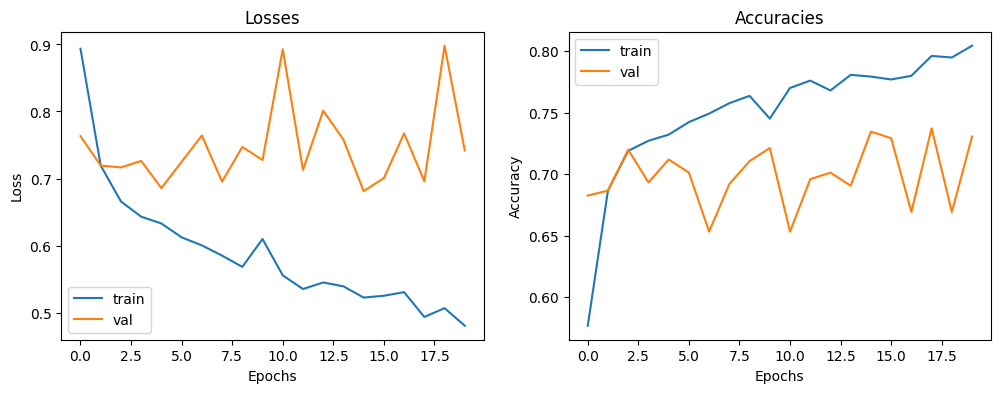

RNN Layers = 1
Test correct = 548

Test total dataitem = 750

Test Accuracy = 0.7306666374206543

              precision    recall  f1-score   support

    negative       0.79      0.71      0.75       250
     neutral       0.65      0.81      0.72       250
    positive       0.79      0.67      0.72       250

    accuracy                           0.73       750
   macro avg       0.74      0.73      0.73       750
weighted avg       0.74      0.73      0.73       750



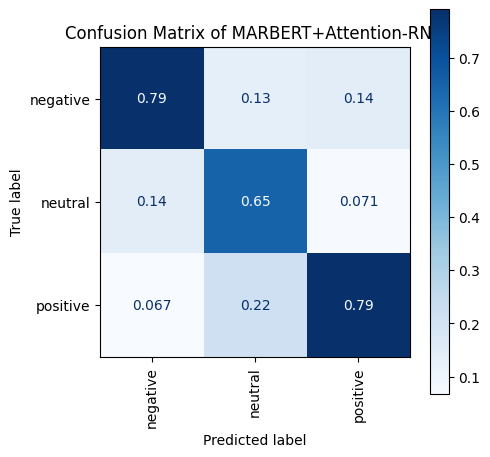

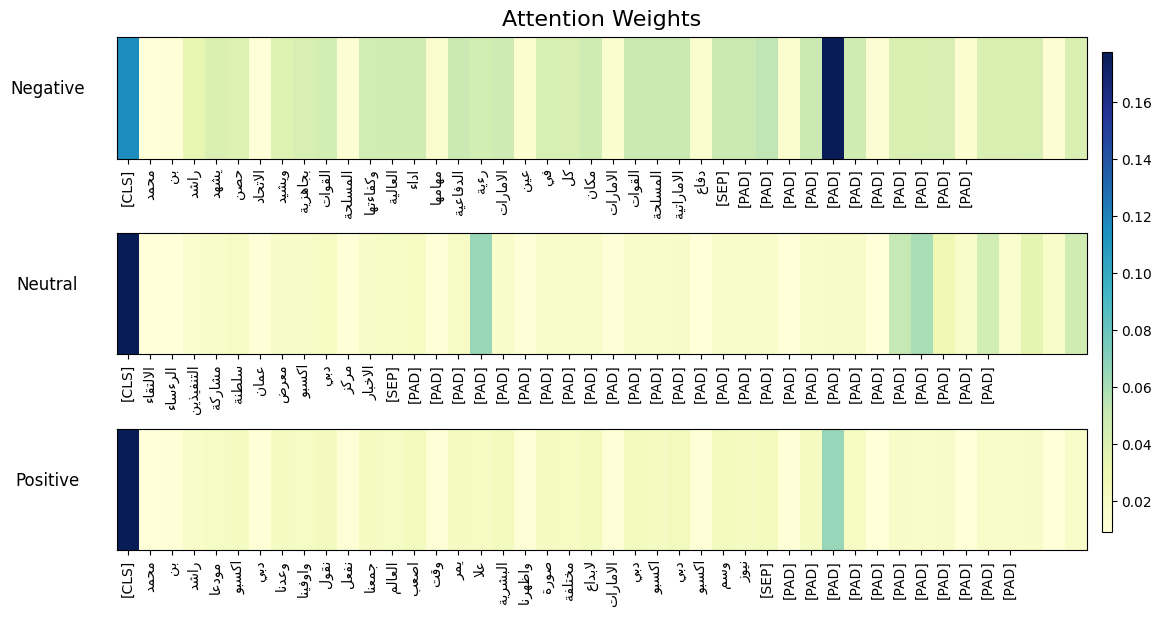

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.9209942330079266, val_loss =0.7428836185294051, accuracy = 0.5690980553627014, val_accuracy = 0.671999990940094


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


loss = 0.7282898827071947, val_loss =0.7237437586589531, accuracy = 0.6798431277275085, val_accuracy = 0.6933333277702332


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 0.6955606459399543, val_loss =0.7398930324827919, accuracy = 0.7069804072380066, val_accuracy = 0.6986666321754456


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


loss = 0.6757149644310952, val_loss =0.7352144431501654, accuracy = 0.7126274704933167, val_accuracy = 0.6679999828338623


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.659357246431248, val_loss =0.7041069547390774, accuracy = 0.7207843065261841, val_accuracy = 0.7039999961853027


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


loss = 0.6738666723209235, val_loss =0.6864566096547882, accuracy = 0.7165490388870239, val_accuracy = 0.7199999690055847


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.6547550949279969, val_loss =0.692619956536847, accuracy = 0.7174901962280273, val_accuracy = 0.7053333520889282


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


loss = 0.64588039849534, val_loss =0.6728747371296618, accuracy = 0.7256470918655396, val_accuracy = 0.7306666374206543


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.643362126821166, val_loss =0.684200885139496, accuracy = 0.7283137440681458, val_accuracy = 0.7293333411216736


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


loss = 0.6510256560772107, val_loss =0.6868722535189168, accuracy = 0.7273725867271423, val_accuracy = 0.7226666808128357


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.6380758390436736, val_loss =0.7455558094081716, accuracy = 0.7314509749412537, val_accuracy = 0.6746666431427002


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 0.6380100909991107, val_loss =0.7106654898713147, accuracy = 0.7345882654190063, val_accuracy = 0.7106666564941406


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


loss = 0.6436693080092993, val_loss =0.6749197204627979, accuracy = 0.7301961183547974, val_accuracy = 0.7253333330154419


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


loss = 0.6293250552851329, val_loss =0.6793778728702371, accuracy = 0.7342745065689087, val_accuracy = 0.7066666483879089


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


loss = 0.6292272025204962, val_loss =0.703527135775205, accuracy = 0.7323921918869019, val_accuracy = 0.7013333439826965


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.632704977430312, val_loss =0.689430663476109, accuracy = 0.7305098176002502, val_accuracy = 0.7053333520889282


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


loss = 0.6118589391988805, val_loss =0.6885660897581186, accuracy = 0.7397647500038147, val_accuracy = 0.7093333005905151


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


loss = 0.6265404597582207, val_loss =0.6892322406201593, accuracy = 0.7319216132164001, val_accuracy = 0.690666675567627


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.6218720372128503, val_loss =0.6692003957504694, accuracy = 0.7334902286529541, val_accuracy = 0.7279999852180481


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.6237212877831866, val_loss =0.7037549117225274, accuracy = 0.7363137602806091, val_accuracy = 0.7026666402816772


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


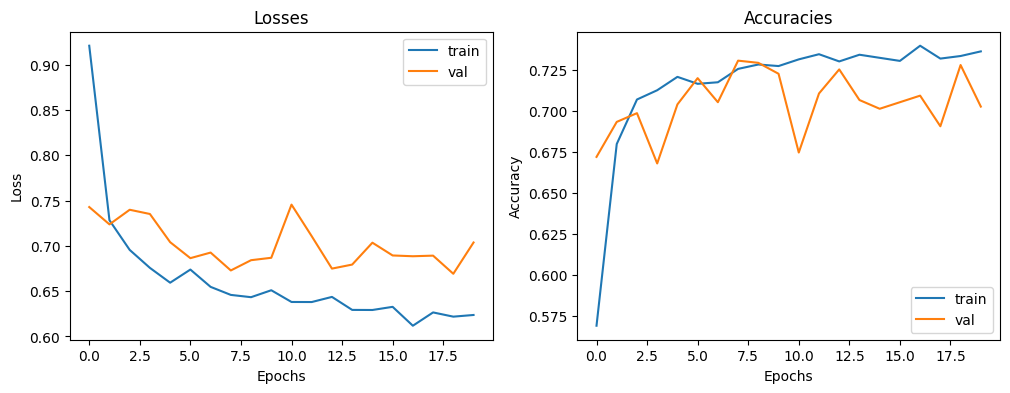

RNN Layers = 2
Test correct = 527

Test total dataitem = 750

Test Accuracy = 0.7026666402816772

              precision    recall  f1-score   support

    negative       0.77      0.73      0.75       250
     neutral       0.67      0.76      0.71       250
    positive       0.68      0.62      0.64       250

    accuracy                           0.70       750
   macro avg       0.70      0.70      0.70       750
weighted avg       0.70      0.70      0.70       750



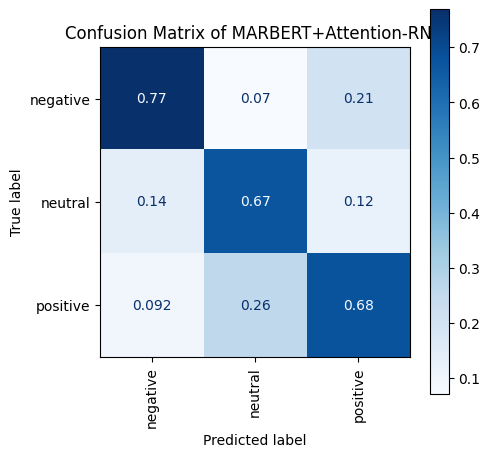

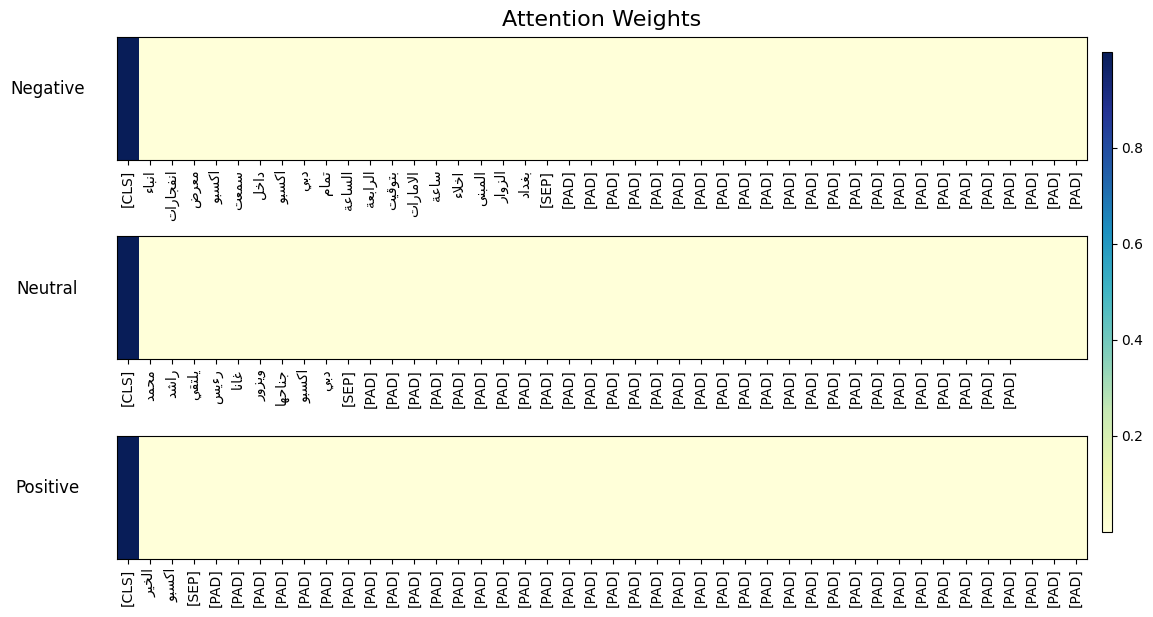

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


loss = 0.9704434060014725, val_loss =0.8265574407730879, accuracy = 0.5272157192230225, val_accuracy = 0.6240000128746033


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


loss = 0.7506368312179147, val_loss =0.7602947715271696, accuracy = 0.6734117865562439, val_accuracy = 0.6853333115577698


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


loss = 0.7078534157435104, val_loss =0.7208886415308738, accuracy = 0.7054117918014526, val_accuracy = 0.7026666402816772


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


loss = 0.6829526666424033, val_loss =0.7221832305560542, accuracy = 0.7167059183120728, val_accuracy = 0.6826666593551636


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 0.6706867817329034, val_loss =0.7713835869523092, accuracy = 0.7214117646217346, val_accuracy = 0.6653333306312561


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


loss = 0.6825519203266786, val_loss =0.8271897450654976, accuracy = 0.713411808013916, val_accuracy = 0.6359999775886536


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


loss = 0.6750022225726766, val_loss =0.7380873483980658, accuracy = 0.7140392065048218, val_accuracy = 0.6639999747276306


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


loss = 0.6524635223702046, val_loss =0.6935899835328767, accuracy = 0.7344313859939575, val_accuracy = 0.7106666564941406


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


loss = 0.6591628882673907, val_loss =0.7110256159106991, accuracy = 0.7289412021636963, val_accuracy = 0.7106666564941406


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.56it/s]


loss = 0.6530692337375323, val_loss =0.6834250444918997, accuracy = 0.7276862859725952, val_accuracy = 0.7066666483879089


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.6536679844015904, val_loss =0.6993071090988267, accuracy = 0.7305098176002502, val_accuracy = 0.7173333168029785


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


loss = 0.6616948790465661, val_loss =0.7131088144485239, accuracy = 0.7245490550994873, val_accuracy = 0.6800000071525574


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


loss = 0.6538459969398989, val_loss =0.6974231815201284, accuracy = 0.7270588278770447, val_accuracy = 0.6973333358764648


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


loss = 0.6491957230786525, val_loss =0.6919451948268799, accuracy = 0.7270588278770447, val_accuracy = 0.7066666483879089


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:18<00:00,  5.56it/s]


loss = 0.6425010033334001, val_loss =0.7130270777698583, accuracy = 0.7325490117073059, val_accuracy = 0.6746666431427002


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


loss = 0.6455460801871431, val_loss =0.744762810175113, accuracy = 0.7363137602806091, val_accuracy = 0.6666666865348816


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


loss = 0.6495764546299548, val_loss =0.6752219186172875, accuracy = 0.7261176705360413, val_accuracy = 0.7106666564941406


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


loss = 0.6499897674502827, val_loss =0.6837833430342827, accuracy = 0.7358431816101074, val_accuracy = 0.7013333439826965


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.643458501465934, val_loss =0.7162729741526097, accuracy = 0.7327058911323547, val_accuracy = 0.6773333549499512


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


loss = 0.6412986055324912, val_loss =0.6918950573126494, accuracy = 0.7355294227600098, val_accuracy = 0.7173333168029785


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


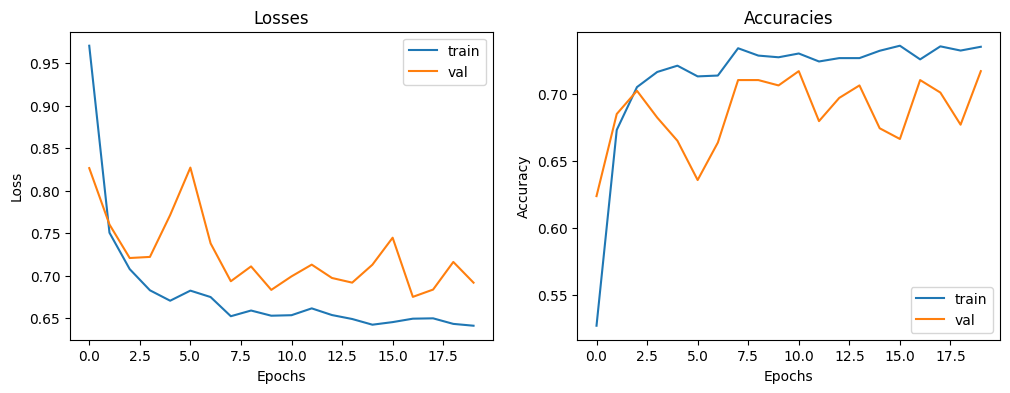

RNN Layers = 3
Test correct = 538

Test total dataitem = 750

Test Accuracy = 0.7173333168029785

              precision    recall  f1-score   support

    negative       0.72      0.81      0.77       250
     neutral       0.79      0.58      0.67       250
    positive       0.66      0.76      0.71       250

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.71       750
weighted avg       0.73      0.72      0.71       750



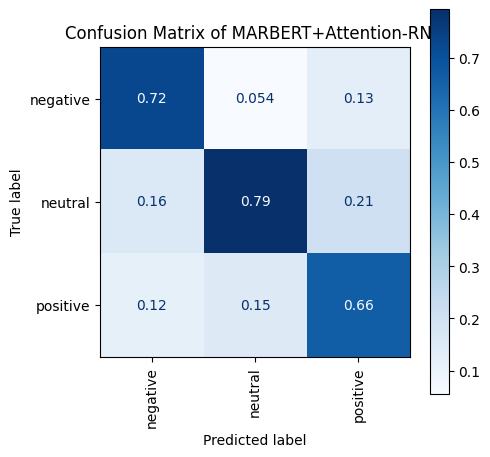

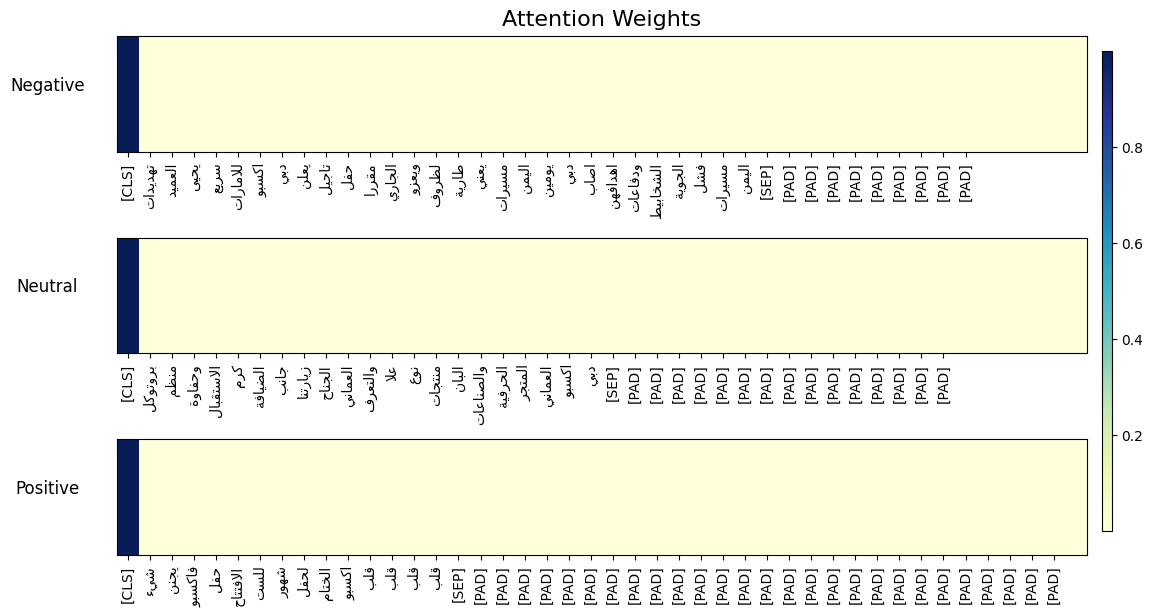

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


loss = 0.9653835632718908, val_loss =0.9608128020047224, accuracy = 0.5011764764785767, val_accuracy = 0.4919999837875366


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


loss = 0.7743661613477834, val_loss =0.7282597656666822, accuracy = 0.6618039608001709, val_accuracy = 0.7013333439826965


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.732174671836383, val_loss =0.7158762048016745, accuracy = 0.6989803910255432, val_accuracy = 0.7026666402816772


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


loss = 0.7017050349524354, val_loss =0.7871216019059606, accuracy = 0.7043137550354004, val_accuracy = 0.6666666865348816


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


loss = 0.6979167820753802, val_loss =0.7559879458834379, accuracy = 0.7091764807701111, val_accuracy = 0.687999963760376


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


loss = 0.6809205571832244, val_loss =0.713276986497542, accuracy = 0.716235339641571, val_accuracy = 0.7199999690055847


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.7302183127549573, val_loss =0.7604936558210823, accuracy = 0.6981961131095886, val_accuracy = 0.6946666836738586


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


loss = 0.6704507563304754, val_loss =0.7167964234448965, accuracy = 0.7228235602378845, val_accuracy = 0.6733333468437195


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


loss = 0.6787822561625323, val_loss =0.6973120555202764, accuracy = 0.7182745337486267, val_accuracy = 0.7160000205039978


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


loss = 0.6707919004609059, val_loss =0.7432926230443021, accuracy = 0.7232941389083862, val_accuracy = 0.6693333387374878


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


loss = 0.6713524049827556, val_loss =0.7027333938775869, accuracy = 0.72062748670578, val_accuracy = 0.7120000123977661


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


loss = 0.6671451129630529, val_loss =0.7629241620233044, accuracy = 0.7195294499397278, val_accuracy = 0.6759999990463257


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 0.6749816639317876, val_loss =0.7231908133774372, accuracy = 0.7181176543235779, val_accuracy = 0.6853333115577698


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.6574782399372583, val_loss =0.6875667965118802, accuracy = 0.7311372756958008, val_accuracy = 0.7160000205039978


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


loss = 0.6596879831355932, val_loss =0.717989254532807, accuracy = 0.7181176543235779, val_accuracy = 0.6946666836738586


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 0.6541268982629486, val_loss =0.6977324520458764, accuracy = 0.7245490550994873, val_accuracy = 0.7213333249092102


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.659430949433411, val_loss =0.737157513560648, accuracy = 0.7262745499610901, val_accuracy = 0.6959999799728394


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


loss = 0.6499573701626875, val_loss =0.7189221872607089, accuracy = 0.7232941389083862, val_accuracy = 0.6866666674613953


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


loss = 0.6511877153393744, val_loss =0.6928362859113765, accuracy = 0.7226666808128357, val_accuracy = 0.6986666321754456


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


loss = 0.6545025487568651, val_loss =0.721648067927268, accuracy = 0.7239215970039368, val_accuracy = 0.699999988079071


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


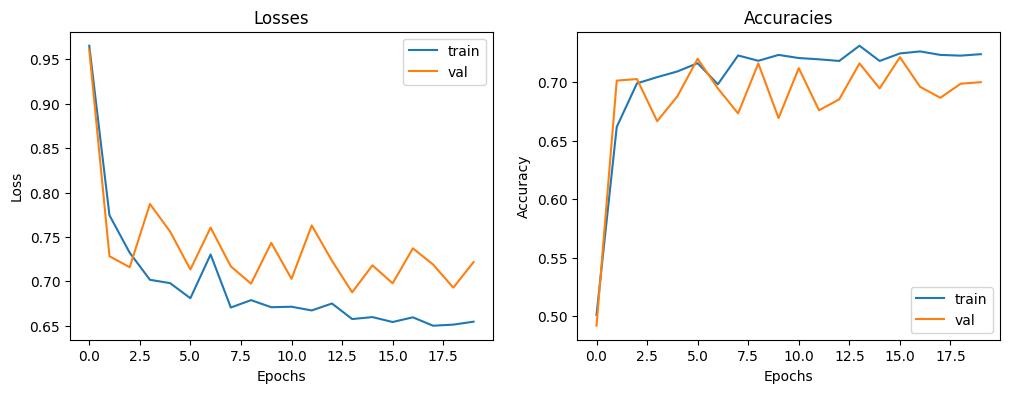

RNN Layers = 4
Test correct = 525

Test total dataitem = 750

Test Accuracy = 0.699999988079071

              precision    recall  f1-score   support

    negative       0.74      0.75      0.74       250
     neutral       0.63      0.80      0.70       250
    positive       0.77      0.55      0.64       250

    accuracy                           0.70       750
   macro avg       0.71      0.70      0.70       750
weighted avg       0.71      0.70      0.70       750



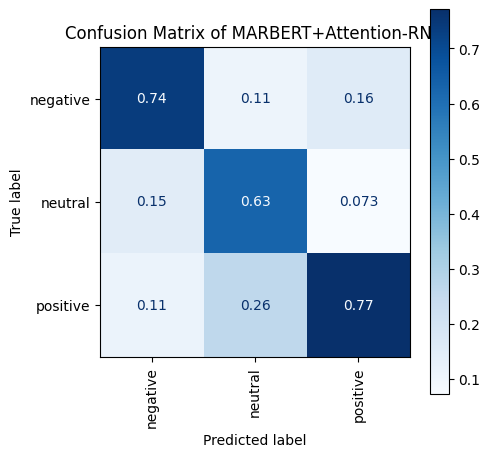

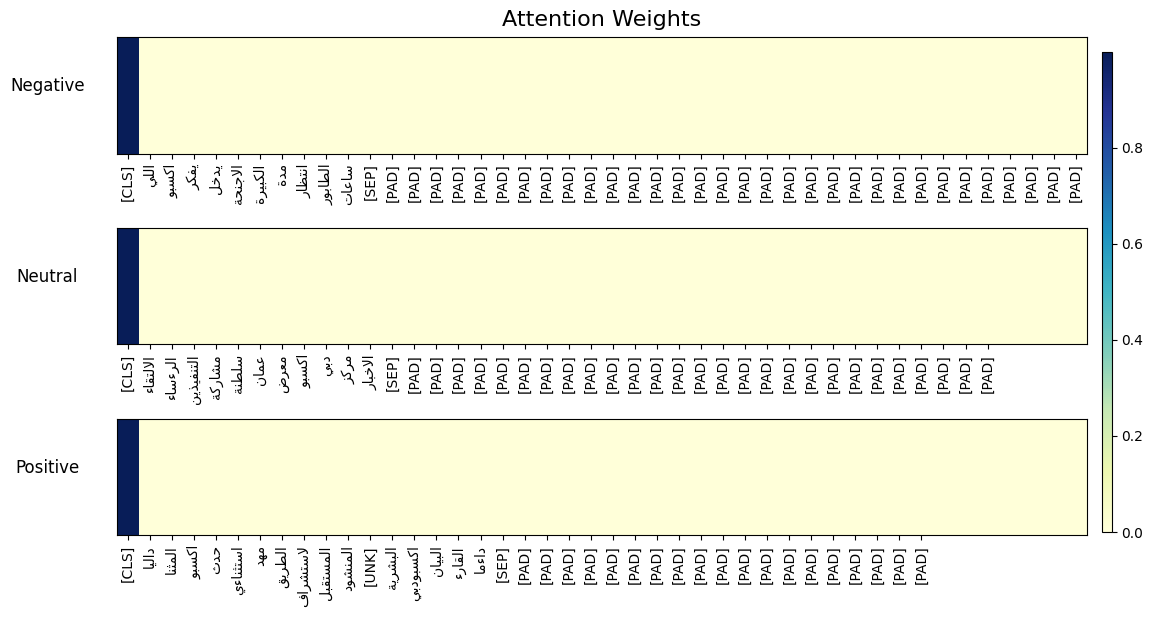

In [ ]:
bidirectional=False
rnn_layers=[1,2,3,4]
for num_layers1 in rnn_layers:
  model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers1,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
  print(f'RNN Layers = {num_layers1}')
  test_and_report(model,test_loader,model_name,attention_added=True)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.8773456995256689, val_loss =0.7455565558655349, accuracy = 0.5623529553413391, val_accuracy = 0.7173333168029785


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 0.5814942162991033, val_loss =0.8017430728332724, accuracy = 0.7612549066543579, val_accuracy = 0.7026666402816772


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5191390830744627, val_loss =0.7109538142274264, accuracy = 0.788392186164856, val_accuracy = 0.7306666374206543


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


loss = 0.5042495299262949, val_loss =0.6615395146962302, accuracy = 0.7978039383888245, val_accuracy = 0.7573333382606506


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.4842965880943853, val_loss =0.737370876770851, accuracy = 0.8034510016441345, val_accuracy = 0.7093333005905151


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.4700033821114462, val_loss =0.793198668622404, accuracy = 0.8053333759307861, val_accuracy = 0.6959999799728394


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


loss = 0.46802499335420633, val_loss =0.7915520779847611, accuracy = 0.8134902119636536, val_accuracy = 0.7053333520889282


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


loss = 0.4559994481832455, val_loss =0.7835579039632833, accuracy = 0.8161568641662598, val_accuracy = 0.7146666646003723


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.45899360473475853, val_loss =0.8199523401668142, accuracy = 0.8045490384101868, val_accuracy = 0.7080000042915344


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


loss = 0.44327465480997974, val_loss =0.8319130116595992, accuracy = 0.8197647333145142, val_accuracy = 0.7026666402816772


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.4434695091608997, val_loss =0.7387175909170337, accuracy = 0.8210196495056152, val_accuracy = 0.7239999771118164


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.43673252805900686, val_loss =0.744698959828891, accuracy = 0.8250980377197266, val_accuracy = 0.7279999852180481


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.43219160764816544, val_loss =0.7489859181699439, accuracy = 0.8260392546653748, val_accuracy = 0.718666672706604


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.4359616019391927, val_loss =0.8783308050823248, accuracy = 0.8241568803787231, val_accuracy = 0.690666675567627


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.4216284040476884, val_loss =0.7012820923793494, accuracy = 0.8316863179206848, val_accuracy = 0.7386666536331177


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4087152963875129, val_loss =0.755277434553436, accuracy = 0.834352970123291, val_accuracy = 0.7306666374206543


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.4246641894807614, val_loss =0.7030291570094532, accuracy = 0.824313759803772, val_accuracy = 0.7426666617393494


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


A model was saved at accuracy = 0.7706666588783264
loss = 0.4126558715507345, val_loss =0.6950835548812136, accuracy = 0.8301176428794861, val_accuracy = 0.7706666588783264


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


loss = 0.4110935591063609, val_loss =0.7521417009051866, accuracy = 0.8341960906982422, val_accuracy = 0.7080000042915344


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.4119869405090949, val_loss =0.7745365921254286, accuracy = 0.8269804120063782, val_accuracy = 0.7253333330154419


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


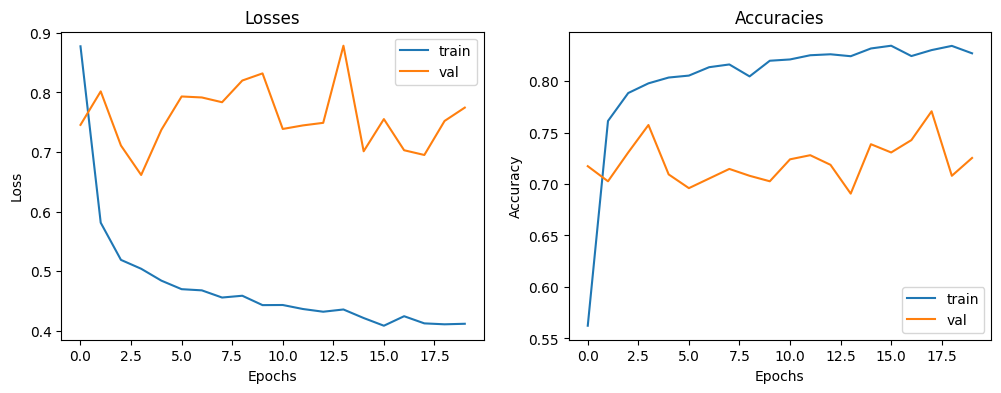

RNN hidden size = 32
Test correct = 544

Test total dataitem = 750

Test Accuracy = 0.7253333330154419

              precision    recall  f1-score   support

    negative       0.81      0.63      0.71       250
     neutral       0.69      0.74      0.71       250
    positive       0.70      0.81      0.75       250

    accuracy                           0.73       750
   macro avg       0.73      0.73      0.72       750
weighted avg       0.73      0.73      0.72       750



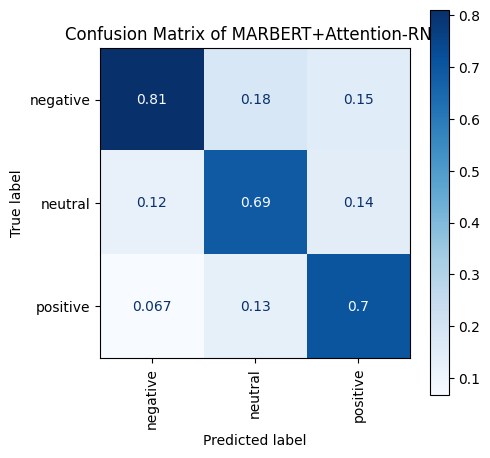

<ipython-input-16-3adf064bf7de>:36: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


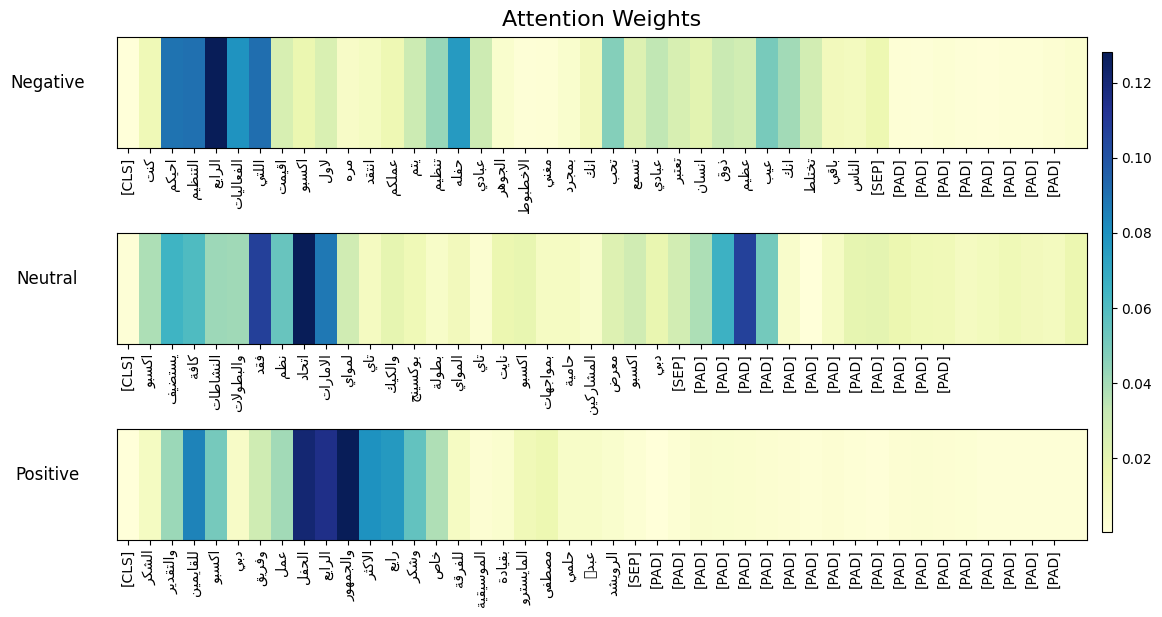

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.8277195555206428, val_loss =1.0274454834526703, accuracy = 0.6073725819587708, val_accuracy = 0.6506666541099548


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.5841392947885381, val_loss =1.1895604699885038, accuracy = 0.7560784220695496, val_accuracy = 0.5680000185966492


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.5227481362284297, val_loss =0.8216729050146713, accuracy = 0.7808627486228943, val_accuracy = 0.7053333520889282


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.5038593636458046, val_loss =0.8952336877978664, accuracy = 0.7921568751335144, val_accuracy = 0.687999963760376


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.47016381853745715, val_loss =1.046726298071431, accuracy = 0.8089411854743958, val_accuracy = 0.6733333468437195


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.4681342331728623, val_loss =0.7316152414071125, accuracy = 0.8092549443244934, val_accuracy = 0.7599999904632568


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4667454941315489, val_loss =0.8676243892795581, accuracy = 0.8086274862289429, val_accuracy = 0.7146666646003723


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.4613576284325314, val_loss =0.8937319023306393, accuracy = 0.8119215965270996, val_accuracy = 0.7039999961853027


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4481996211148204, val_loss =0.809964602046297, accuracy = 0.8180392384529114, val_accuracy = 0.7226666808128357


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4374572739309604, val_loss =0.7106015060181469, accuracy = 0.8229019641876221, val_accuracy = 0.7599999904632568


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.44141223062940804, val_loss =0.8144037956373468, accuracy = 0.8232157230377197, val_accuracy = 0.7226666808128357


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.4499795383108755, val_loss =0.9637504231260725, accuracy = 0.8149020075798035, val_accuracy = 0.6919999718666077


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.4270485749800374, val_loss =0.7579290436018861, accuracy = 0.8250980377197266, val_accuracy = 0.7573333382606506


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.4194440470501145, val_loss =0.6942217192088882, accuracy = 0.831529438495636, val_accuracy = 0.7693333029747009


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.4163752030228127, val_loss =0.7380787907524192, accuracy = 0.8247843384742737, val_accuracy = 0.7146666646003723


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.4219272106796088, val_loss =0.7099485274634537, accuracy = 0.8235294222831726, val_accuracy = 0.7599999904632568


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.4011496747795995, val_loss =1.0048529502474108, accuracy = 0.8365490436553955, val_accuracy = 0.6826666593551636


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.40284848319297967, val_loss =0.740849225171713, accuracy = 0.8323137164115906, val_accuracy = 0.7026666402816772


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4006856027171704, val_loss =0.8225702510350726, accuracy = 0.8337255120277405, val_accuracy = 0.7226666808128357


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.398816579457798, val_loss =0.6999056491246692, accuracy = 0.8363921642303467, val_accuracy = 0.7440000176429749


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


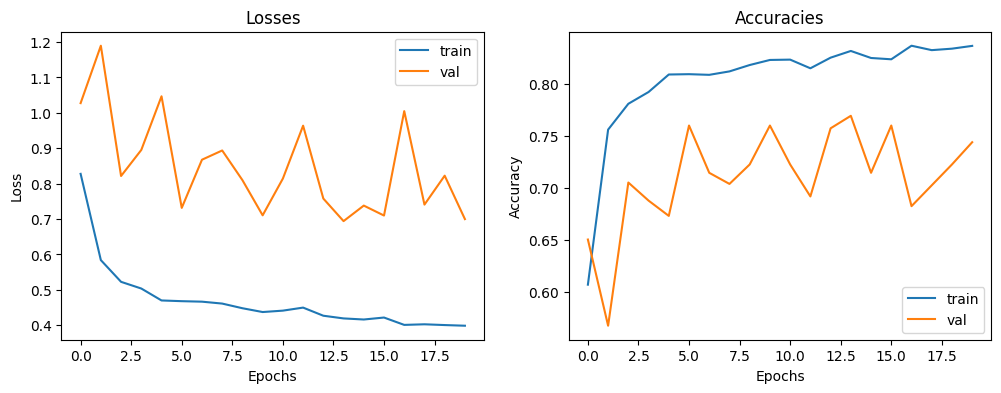

RNN hidden size = 64
Test correct = 558

Test total dataitem = 750

Test Accuracy = 0.7440000176429749

              precision    recall  f1-score   support

    negative       0.80      0.72      0.76       250
     neutral       0.74      0.68      0.71       250
    positive       0.71      0.82      0.76       250

    accuracy                           0.74       750
   macro avg       0.75      0.74      0.74       750
weighted avg       0.75      0.74      0.74       750



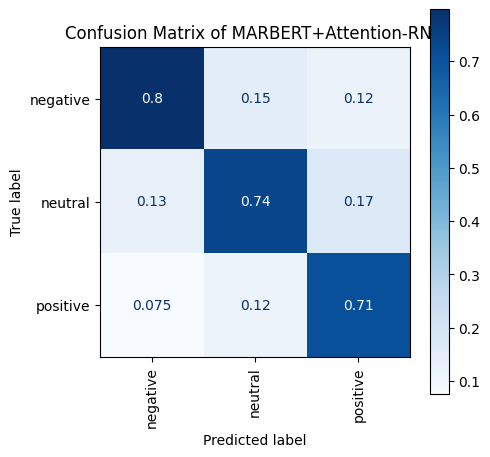

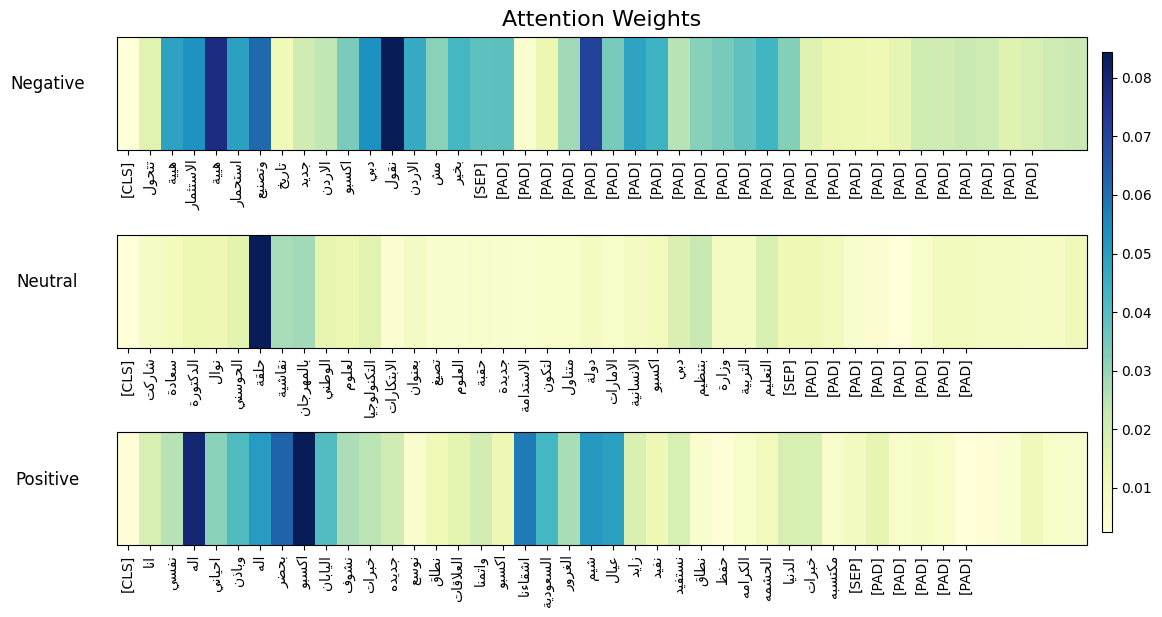

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.816349612788429, val_loss =0.8641012207019125, accuracy = 0.6053333282470703, val_accuracy = 0.7053333520889282


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5773088323223643, val_loss =0.8516458202794651, accuracy = 0.7628235220909119, val_accuracy = 0.7093333005905151


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.533126216726442, val_loss =0.710009107479153, accuracy = 0.7803921699523926, val_accuracy = 0.762666642665863


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.5118621227908043, val_loss =0.9182547997605011, accuracy = 0.7898039221763611, val_accuracy = 0.687999963760376


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.48714838602451843, val_loss =0.8403411364048403, accuracy = 0.8036078810691833, val_accuracy = 0.7373332977294922


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.4647408404674734, val_loss =0.8917057104093383, accuracy = 0.8164706230163574, val_accuracy = 0.7199999690055847


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.4614194900956464, val_loss =0.9239935107006372, accuracy = 0.8078431487083435, val_accuracy = 0.6986666321754456


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.4655700444680033, val_loss =1.0485126007206582, accuracy = 0.8092549443244934, val_accuracy = 0.6893333196640015


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.4561455399477328, val_loss =0.8823075078465944, accuracy = 0.8158431649208069, val_accuracy = 0.7106666564941406


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.43658688805873297, val_loss =0.7966367733681121, accuracy = 0.8235294222831726, val_accuracy = 0.7013333439826965


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.42826886261783814, val_loss =0.8599106798915511, accuracy = 0.8252549171447754, val_accuracy = 0.7133333086967468


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.42249496138368786, val_loss =0.7546204771478404, accuracy = 0.8250980377197266, val_accuracy = 0.7319999933242798


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.41590466589262526, val_loss =0.9592942837870004, accuracy = 0.8293333649635315, val_accuracy = 0.6919999718666077


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.42635133719174, val_loss =0.6923407340112981, accuracy = 0.8230588436126709, val_accuracy = 0.7493333220481873


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4324727072467781, val_loss =0.6721024847975348, accuracy = 0.8191372752189636, val_accuracy = 0.7599999904632568


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.4026729612612933, val_loss =0.785977808895776, accuracy = 0.835921585559845, val_accuracy = 0.7239999771118164


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.40982161451303156, val_loss =0.6802690377059902, accuracy = 0.8321568965911865, val_accuracy = 0.7666666507720947


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.40751429884835005, val_loss =0.727505285722287, accuracy = 0.8312156796455383, val_accuracy = 0.7213333249092102


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.3990292340061333, val_loss =0.770091132322764, accuracy = 0.8326274752616882, val_accuracy = 0.734666645526886


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.39477907477267943, val_loss =1.0044156203862562, accuracy = 0.8368627429008484, val_accuracy = 0.6866666674613953


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


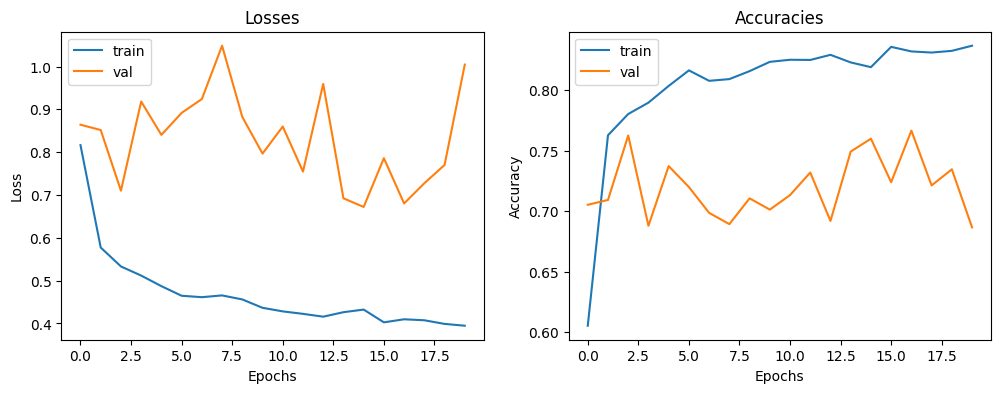

RNN hidden size = 128
Test correct = 515

Test total dataitem = 750

Test Accuracy = 0.6866666674613953

              precision    recall  f1-score   support

    negative       0.84      0.49      0.62       250
     neutral       0.62      0.78      0.69       250
    positive       0.69      0.79      0.74       250

    accuracy                           0.69       750
   macro avg       0.71      0.69      0.68       750
weighted avg       0.71      0.69      0.68       750



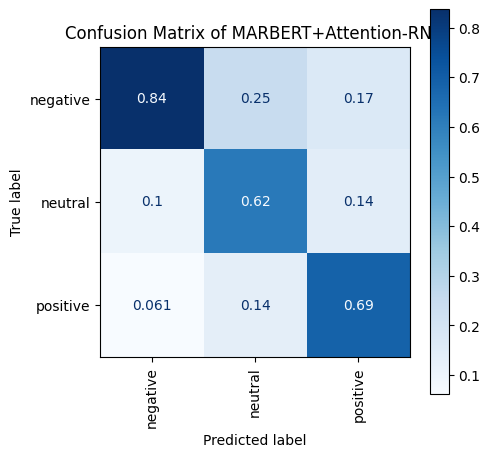

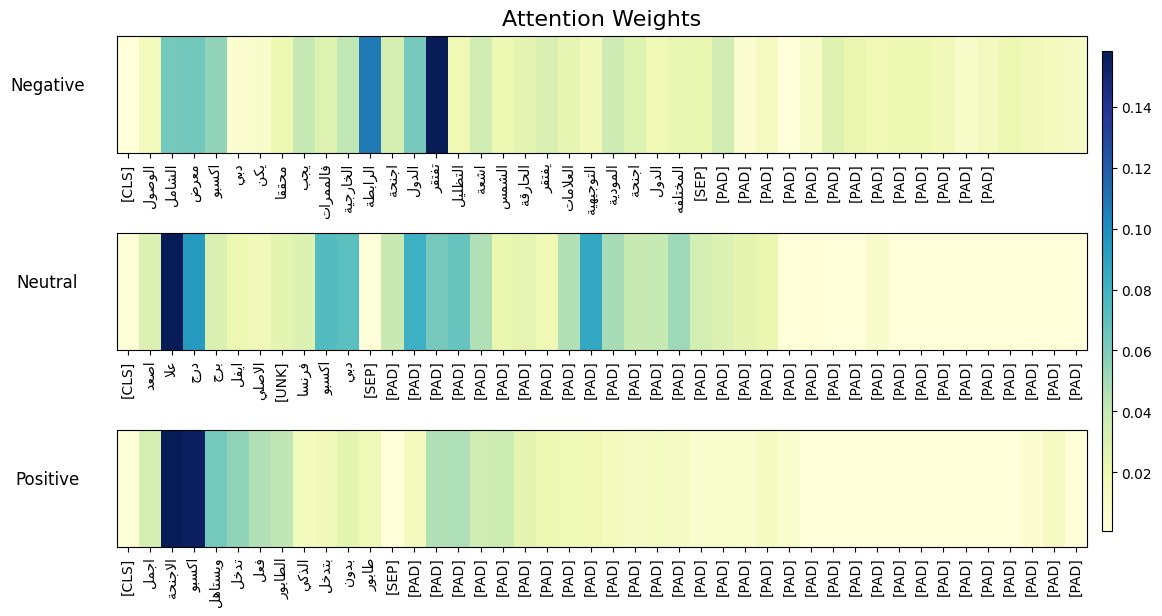

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.8437583736600619, val_loss =0.8316424982577449, accuracy = 0.6017255187034607, val_accuracy = 0.6493332982063293


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.6001956530488001, val_loss =0.8465705257510795, accuracy = 0.7488627433776855, val_accuracy = 0.7319999933242798


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5313342979350785, val_loss =0.8075552986323027, accuracy = 0.7847843170166016, val_accuracy = 0.7573333382606506


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.5252075147598955, val_loss =1.1011639416813357, accuracy = 0.7858823537826538, val_accuracy = 0.6666666865348816


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.4968859279406013, val_loss =0.8318988723795847, accuracy = 0.7921568751335144, val_accuracy = 0.690666675567627


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.481301178196259, val_loss =0.9942005130768724, accuracy = 0.8018823862075806, val_accuracy = 0.6959999799728394


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.48554189525277797, val_loss =0.817009340548851, accuracy = 0.8010980486869812, val_accuracy = 0.7039999961853027


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4660303122133317, val_loss =0.7490421411944593, accuracy = 0.8083137273788452, val_accuracy = 0.7440000176429749


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.4569102208302302, val_loss =0.6958924269582288, accuracy = 0.8109804391860962, val_accuracy = 0.7293333411216736


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4660578650784371, val_loss =0.675585602339805, accuracy = 0.8101961016654968, val_accuracy = 0.7373332977294922


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.46311390448968387, val_loss =0.7563799486939735, accuracy = 0.8087843060493469, val_accuracy = 0.6986666321754456


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4449628899249104, val_loss =0.7361045366951249, accuracy = 0.8156862854957581, val_accuracy = 0.7266666293144226


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4271893543664257, val_loss =0.6893389871592466, accuracy = 0.8241568803787231, val_accuracy = 0.7479999661445618


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.427561629273001, val_loss =0.7558068666803778, accuracy = 0.8214902281761169, val_accuracy = 0.7120000123977661


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4369322006447443, val_loss =1.0822417797731496, accuracy = 0.8235294222831726, val_accuracy = 0.6426666378974915


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.43718369275554236, val_loss =0.7985629319415671, accuracy = 0.8191372752189636, val_accuracy = 0.6973333358764648


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.41412558248813325, val_loss =0.7344810637310957, accuracy = 0.8285490274429321, val_accuracy = 0.7013333439826965


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.4140216217508354, val_loss =0.7711603335063959, accuracy = 0.8304314017295837, val_accuracy = 0.7253333330154419


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4220397998326699, val_loss =0.69258894437203, accuracy = 0.8276078701019287, val_accuracy = 0.7146666646003723


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.4224962424958394, val_loss =0.7981650222423541, accuracy = 0.8222745060920715, val_accuracy = 0.6946666836738586


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


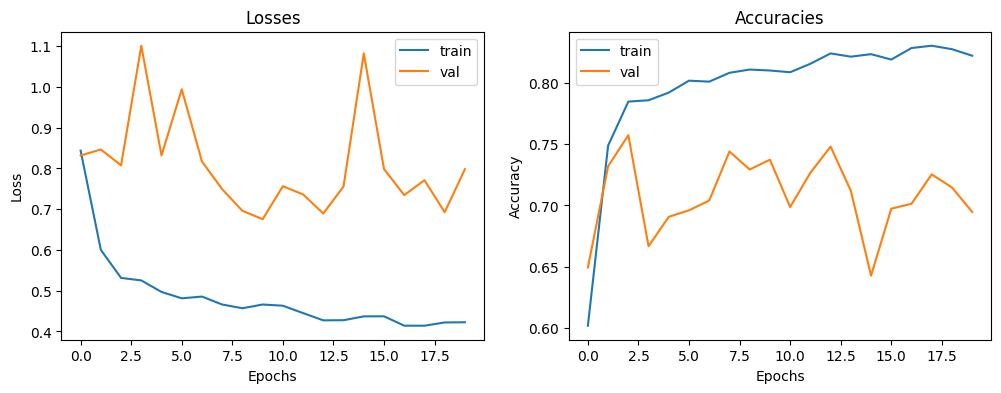

RNN hidden size = 256
Test correct = 521

Test total dataitem = 750

Test Accuracy = 0.6946666836738586

              precision    recall  f1-score   support

    negative       0.82      0.58      0.68       250
     neutral       0.69      0.64      0.66       250
    positive       0.63      0.87      0.73       250

    accuracy                           0.69       750
   macro avg       0.71      0.69      0.69       750
weighted avg       0.71      0.69      0.69       750



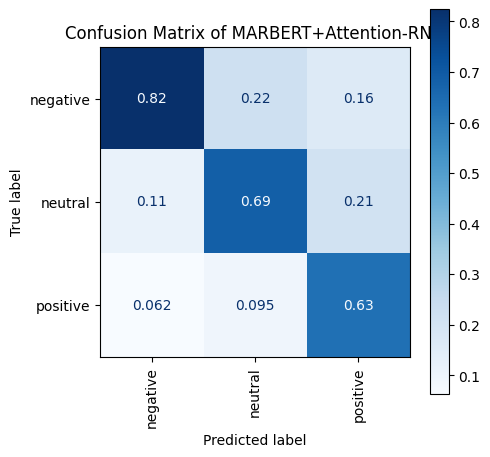

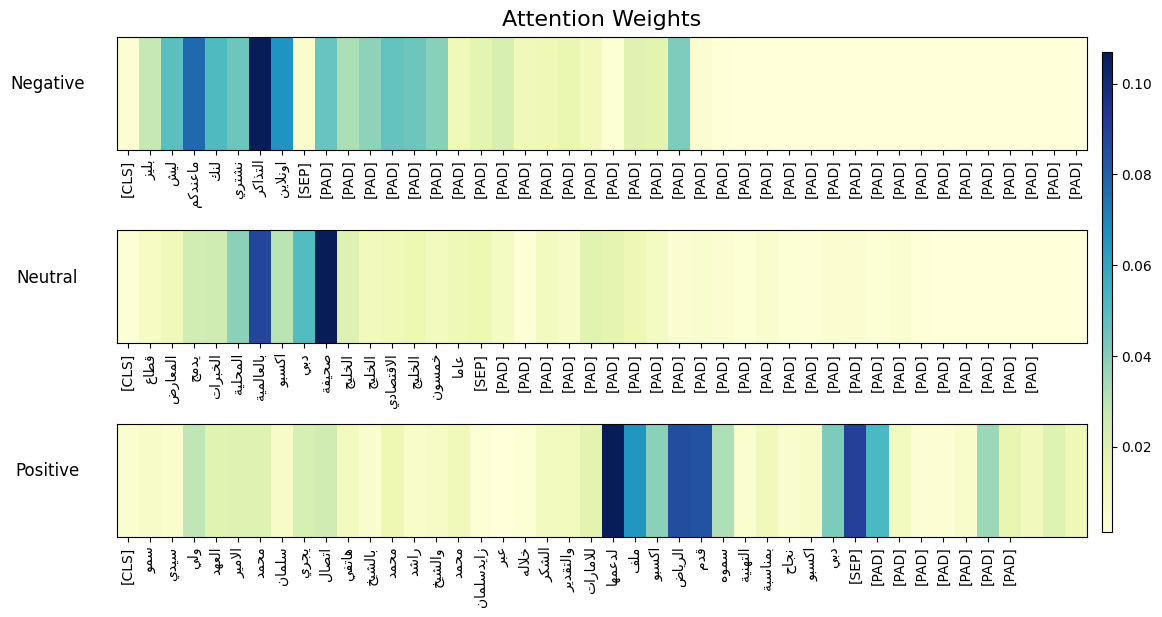

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


loss = 0.9086302123139588, val_loss =0.7830178274309509, accuracy = 0.5741176605224609, val_accuracy = 0.6520000100135803


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


loss = 0.7052366077139568, val_loss =0.7353103590554594, accuracy = 0.6970980763435364, val_accuracy = 0.6826666593551636


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.6564649774574611, val_loss =0.7772091163426565, accuracy = 0.7284706234931946, val_accuracy = 0.6666666865348816


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.6044596493530049, val_loss =0.7303190112946675, accuracy = 0.7458823919296265, val_accuracy = 0.7039999961853027


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5887999056305407, val_loss =0.6701065641120832, accuracy = 0.7516862750053406, val_accuracy = 0.7080000042915344


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5330435993795285, val_loss =0.760072918277975, accuracy = 0.7783529758453369, val_accuracy = 0.7199999690055847


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5403405909988153, val_loss =0.6225163794919637, accuracy = 0.7805490493774414, val_accuracy = 0.7493333220481873


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.5222155166301149, val_loss =0.779041665664728, accuracy = 0.7871372699737549, val_accuracy = 0.6933333277702332


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.5135262615459095, val_loss =0.6933414670855008, accuracy = 0.786980390548706, val_accuracy = 0.7279999852180481


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.49087917006864046, val_loss =0.6957543448781188, accuracy = 0.7924706339836121, val_accuracy = 0.7213333249092102


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.4798132374344049, val_loss =0.7765098069501369, accuracy = 0.802823543548584, val_accuracy = 0.7226666808128357


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4965665793208521, val_loss =0.650854331125774, accuracy = 0.7934117913246155, val_accuracy = 0.7680000066757202


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4800190307759699, val_loss =0.7700806067412559, accuracy = 0.80125492811203, val_accuracy = 0.7066666483879089


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4742053362505015, val_loss =0.7131381671712366, accuracy = 0.8045490384101868, val_accuracy = 0.7573333382606506


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.47599029798336817, val_loss =0.6816922473424157, accuracy = 0.8029804229736328, val_accuracy = 0.7306666374206543


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.453129749846189, val_loss =0.7667507753000026, accuracy = 0.8164706230163574, val_accuracy = 0.6919999718666077


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.4921357103116359, val_loss =0.7872458026803052, accuracy = 0.8029804229736328, val_accuracy = 0.690666675567627


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.45677165825799676, val_loss =0.8103014045344888, accuracy = 0.812862753868103, val_accuracy = 0.7053333520889282


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.44862796860285187, val_loss =0.7075288831655618, accuracy = 0.8166274428367615, val_accuracy = 0.7053333520889282


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4643898424960671, val_loss =0.7117968914816549, accuracy = 0.8018823862075806, val_accuracy = 0.7146666646003723


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


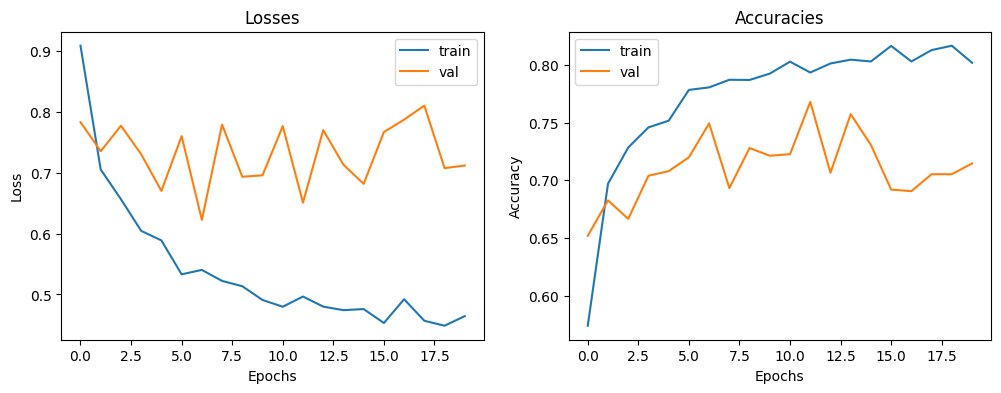

RNN hidden size = 512
Test correct = 536

Test total dataitem = 750

Test Accuracy = 0.7146666646003723

              precision    recall  f1-score   support

    negative       0.81      0.68      0.74       250
     neutral       0.59      0.86      0.70       250
    positive       0.84      0.60      0.70       250

    accuracy                           0.71       750
   macro avg       0.75      0.71      0.72       750
weighted avg       0.75      0.71      0.72       750



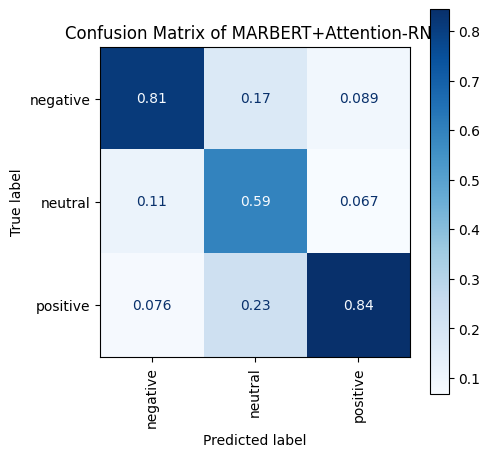

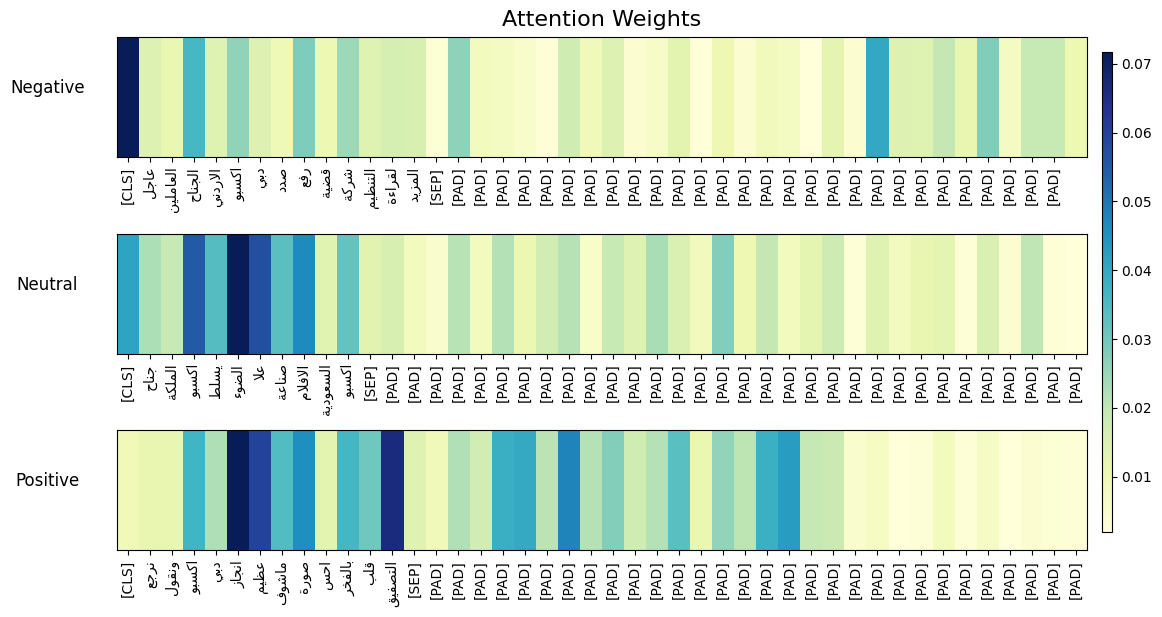

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


loss = 0.8950435452446479, val_loss =0.7932543439560306, accuracy = 0.5832157135009766, val_accuracy = 0.637333333492279


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


loss = 0.724175569189894, val_loss =0.7298388241156911, accuracy = 0.6795294284820557, val_accuracy = 0.6973333358764648


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


loss = 0.7177323406974269, val_loss =0.7229359722454767, accuracy = 0.6851764917373657, val_accuracy = 0.6973333358764648


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


loss = 0.6820490176918197, val_loss =0.7432279630935965, accuracy = 0.7082353234291077, val_accuracy = 0.6773333549499512


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 0.6719165358603278, val_loss =0.7710159291701674, accuracy = 0.7126274704933167, val_accuracy = 0.6413333415985107


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.6649895433301499, val_loss =0.7016889572291077, accuracy = 0.7135686278343201, val_accuracy = 0.7133333086967468


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.6582257341143688, val_loss =0.7307941227758867, accuracy = 0.7195294499397278, val_accuracy = 0.6946666836738586


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.6461656617110434, val_loss =0.724168679114276, accuracy = 0.7281568646430969, val_accuracy = 0.6866666674613953


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


loss = 0.647161322663333, val_loss =0.7328472361457871, accuracy = 0.72062748670578, val_accuracy = 0.6840000152587891


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


loss = 0.63983642127596, val_loss =0.7235938836512513, accuracy = 0.7276862859725952, val_accuracy = 0.6840000152587891


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


loss = 0.6494730466322512, val_loss =0.7266752191940412, accuracy = 0.7236078381538391, val_accuracy = 0.6746666431427002


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


loss = 0.6468149464351489, val_loss =0.7039036167806695, accuracy = 0.7215686440467834, val_accuracy = 0.6946666836738586


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


loss = 0.6344262560514106, val_loss =0.7080631089068486, accuracy = 0.7301961183547974, val_accuracy = 0.7013333439826965


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.6388096747773322, val_loss =0.6721810094643224, accuracy = 0.7243921756744385, val_accuracy = 0.7146666646003723


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.6329519945509092, val_loss =0.6921534100660263, accuracy = 0.7276862859725952, val_accuracy = 0.7039999961853027


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


loss = 0.6333019183389473, val_loss =0.7156148923206828, accuracy = 0.7259607911109924, val_accuracy = 0.690666675567627


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 0.6422393942293901, val_loss =0.7358769224554345, accuracy = 0.7295686602592468, val_accuracy = 0.6613333225250244


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


loss = 0.6223522662839998, val_loss =0.7327949752819657, accuracy = 0.7273725867271423, val_accuracy = 0.671999990940094


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.6325340397655697, val_loss =0.7228739324519414, accuracy = 0.7328627705574036, val_accuracy = 0.6813333034515381


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.6330530109619884, val_loss =0.6967076421418613, accuracy = 0.730980396270752, val_accuracy = 0.7013333439826965


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


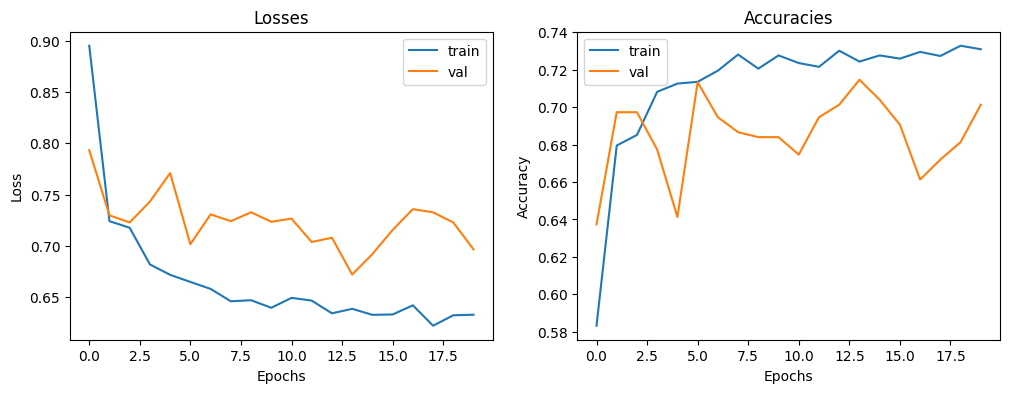

RNN hidden size = 1024
Test correct = 526

Test total dataitem = 750

Test Accuracy = 0.7013333439826965

              precision    recall  f1-score   support

    negative       0.78      0.68      0.73       250
     neutral       0.64      0.78      0.70       250
    positive       0.71      0.64      0.68       250

    accuracy                           0.70       750
   macro avg       0.71      0.70      0.70       750
weighted avg       0.71      0.70      0.70       750



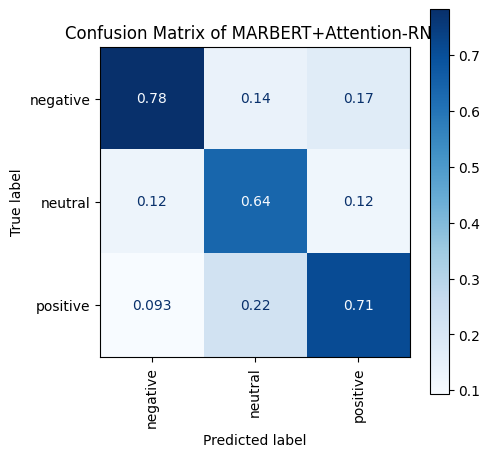

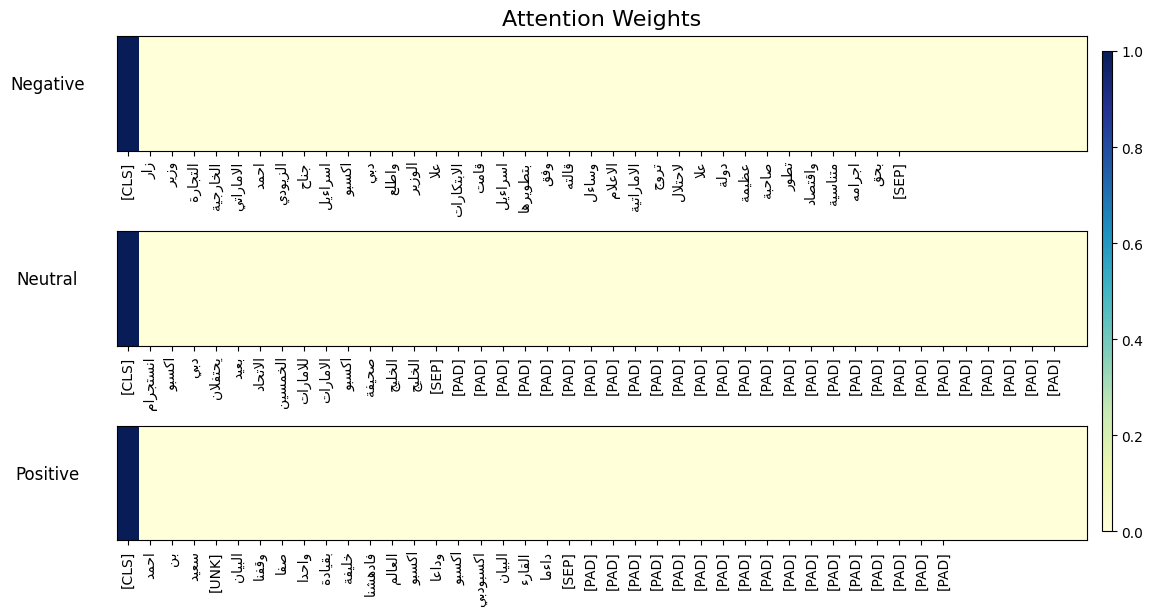

In [ ]:
bidirectional=False
num_layers=1
rnn_hidden_sizes=[32,64,128,256,512,1024]
for hidden_size in rnn_hidden_sizes:
  model=AttentionRNN_AraBERT(hidden_size,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
  print(f'RNN hidden size = {hidden_size}')
  test_and_report(model,test_loader,model_name,attention_added=True)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


loss = 0.9360698872027794, val_loss =0.8327291989374225, accuracy = 0.5234509706497192, val_accuracy = 0.6653333306312561


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.664784304213895, val_loss =0.7359458286461723, accuracy = 0.7262745499610901, val_accuracy = 0.7293333411216736


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.5721150191221543, val_loss =0.9071661239864374, accuracy = 0.7717646956443787, val_accuracy = 0.7093333005905151


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.5417369880532865, val_loss =0.6757316152735995, accuracy = 0.7794510126113892, val_accuracy = 0.7666666507720947


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.5352635731659646, val_loss =0.7622158998805969, accuracy = 0.779764711856842, val_accuracy = 0.7293333411216736


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.5126739404152171, val_loss =0.7536237142124765, accuracy = 0.7974902391433716, val_accuracy = 0.7373332977294922


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.4981077616100736, val_loss =0.78833772512204, accuracy = 0.7978039383888245, val_accuracy = 0.7319999933242798


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4781001745361031, val_loss =0.7751601110169567, accuracy = 0.8025098443031311, val_accuracy = 0.7373332977294922


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.47483932280777474, val_loss =0.8428894724584625, accuracy = 0.8095686435699463, val_accuracy = 0.7360000014305115


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.46576884440992844, val_loss =1.0369053882281376, accuracy = 0.8183529376983643, val_accuracy = 0.6919999718666077


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


A model was saved at accuracy = 0.7839999794960022
loss = 0.46610568214415826, val_loss =0.6488298453166218, accuracy = 0.8181961178779602, val_accuracy = 0.7839999794960022


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


loss = 0.46020040663081424, val_loss =0.7559236028596873, accuracy = 0.8214902281761169, val_accuracy = 0.7226666808128357


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.44896428295528273, val_loss =0.7062454782313461, accuracy = 0.8241568803787231, val_accuracy = 0.753333330154419


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4427568330839695, val_loss =0.8353403799223478, accuracy = 0.8232157230377197, val_accuracy = 0.7319999933242798


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.44326591992313036, val_loss =0.6638364743745176, accuracy = 0.8207058906555176, val_accuracy = 0.7693333029747009


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.45142702372152194, val_loss =0.7203317815590516, accuracy = 0.8167843222618103, val_accuracy = 0.7373332977294922


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4276577585576147, val_loss =0.6915173320020275, accuracy = 0.8207058906555176, val_accuracy = 0.7479999661445618


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.4326207585677437, val_loss =0.70279997339521, accuracy = 0.8213333487510681, val_accuracy = 0.7693333029747009


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.4228202591611357, val_loss =0.7494960513827192, accuracy = 0.8285490274429321, val_accuracy = 0.7306666374206543


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4239672570985356, val_loss =0.8191810205042002, accuracy = 0.8254117965698242, val_accuracy = 0.7133333086967468


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


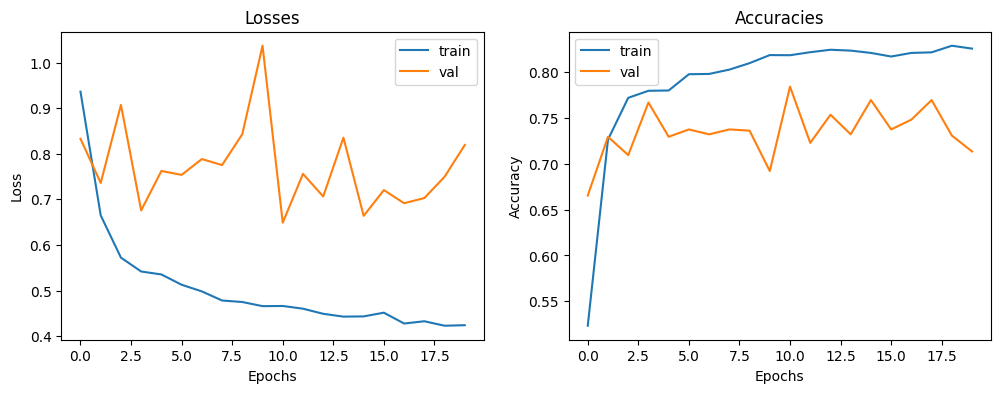

fully-connected hidden size = 32
Test correct = 535

Test total dataitem = 750

Test Accuracy = 0.7133333086967468

              precision    recall  f1-score   support

    negative       0.87      0.56      0.68       250
     neutral       0.62      0.85      0.72       250
    positive       0.74      0.73      0.74       250

    accuracy                           0.71       750
   macro avg       0.74      0.71      0.71       750
weighted avg       0.74      0.71      0.71       750



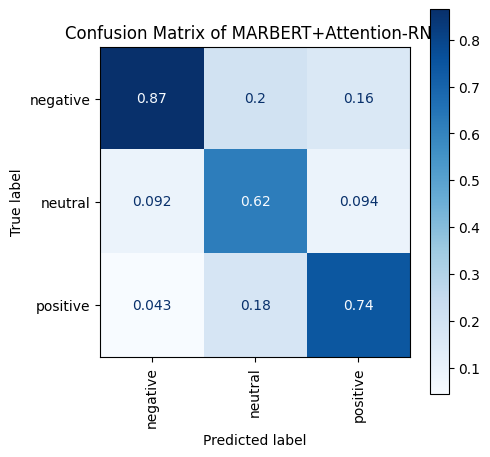

<ipython-input-16-3adf064bf7de>:36: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


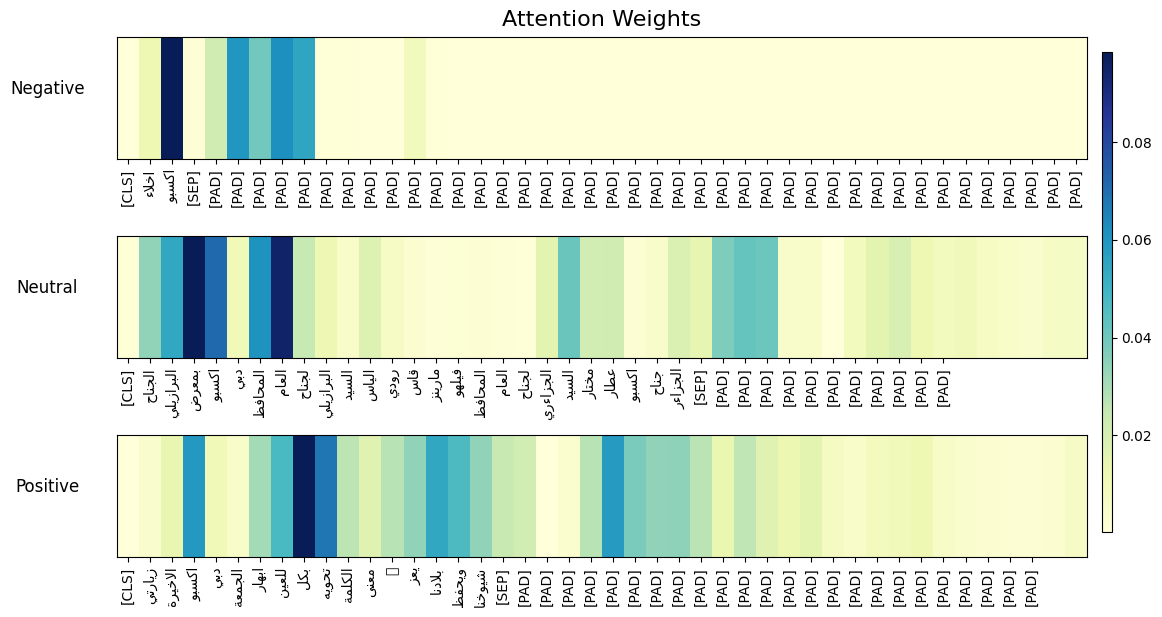

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.872258061139075, val_loss =0.7315855426103277, accuracy = 0.5756862759590149, val_accuracy = 0.7213333249092102


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.56it/s]


loss = 0.5982077439740238, val_loss =0.778492172393337, accuracy = 0.7518431544303894, val_accuracy = 0.6959999799728394


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 0.5387018580238618, val_loss =0.8799934928098953, accuracy = 0.7822745442390442, val_accuracy = 0.7039999961853027


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.5103635046806765, val_loss =0.7524418510489815, accuracy = 0.796862781047821, val_accuracy = 0.7199999690055847


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.5028154775728834, val_loss =0.9943925036610789, accuracy = 0.7992156744003296, val_accuracy = 0.6613333225250244


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


A model was saved at accuracy = 0.7773333191871643
loss = 0.48004743487948603, val_loss =0.7215519063045863, accuracy = 0.8029804229736328, val_accuracy = 0.7773333191871643


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


loss = 0.4889997612740573, val_loss =0.6931530326192394, accuracy = 0.802823543548584, val_accuracy = 0.746666669845581


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4676318073738201, val_loss =0.7677234890958603, accuracy = 0.8108235597610474, val_accuracy = 0.718666672706604


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4529459347918913, val_loss =0.7193359877492548, accuracy = 0.8127058744430542, val_accuracy = 0.7133333086967468


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.45302809882749356, val_loss =0.9289022045657531, accuracy = 0.8141176700592041, val_accuracy = 0.6800000071525574


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.4383166244893624, val_loss =0.8856451288269919, accuracy = 0.8241568803787231, val_accuracy = 0.6800000071525574


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.4417923162922669, val_loss =0.8655420522986614, accuracy = 0.8214902281761169, val_accuracy = 0.7173333168029785


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.43804451488836704, val_loss =0.987038652299114, accuracy = 0.8214902281761169, val_accuracy = 0.6626666784286499


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


loss = 0.4330118343665351, val_loss =0.949045770283799, accuracy = 0.8241568803787231, val_accuracy = 0.6933333277702332


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.42771959199787773, val_loss =0.8370070102331444, accuracy = 0.8192941546440125, val_accuracy = 0.699999988079071


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.4196355857898687, val_loss =0.8887277881904874, accuracy = 0.8296470642089844, val_accuracy = 0.6919999718666077


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.41813915315518385, val_loss =0.7898139616206251, accuracy = 0.8327843546867371, val_accuracy = 0.7239999771118164


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.4215763542636221, val_loss =1.1202313715046286, accuracy = 0.8247843384742737, val_accuracy = 0.6800000071525574


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.42042506587712336, val_loss =0.9313272054586966, accuracy = 0.8307451009750366, val_accuracy = 0.6866666674613953


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4057044853025594, val_loss =0.7991917775451154, accuracy = 0.8357647061347961, val_accuracy = 0.7266666293144226


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


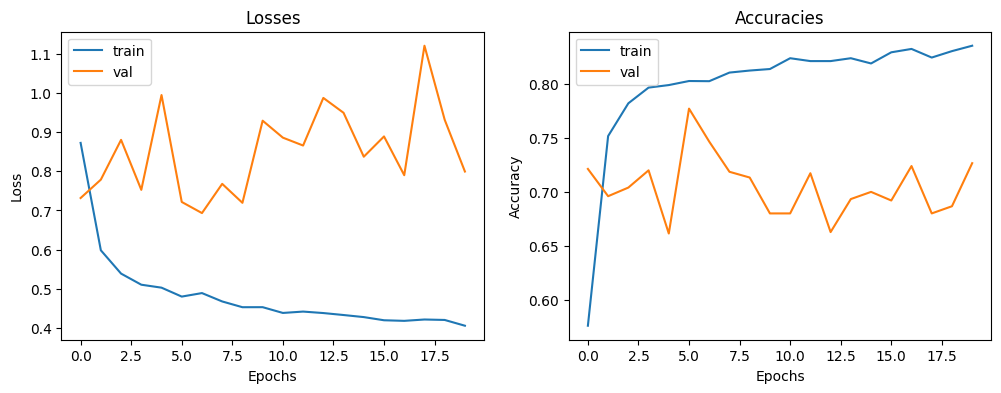

fully-connected hidden size = 64
Test correct = 545

Test total dataitem = 750

Test Accuracy = 0.7266666293144226

              precision    recall  f1-score   support

    negative       0.79      0.69      0.74       250
     neutral       0.64      0.79      0.71       250
    positive       0.79      0.70      0.74       250

    accuracy                           0.73       750
   macro avg       0.74      0.73      0.73       750
weighted avg       0.74      0.73      0.73       750



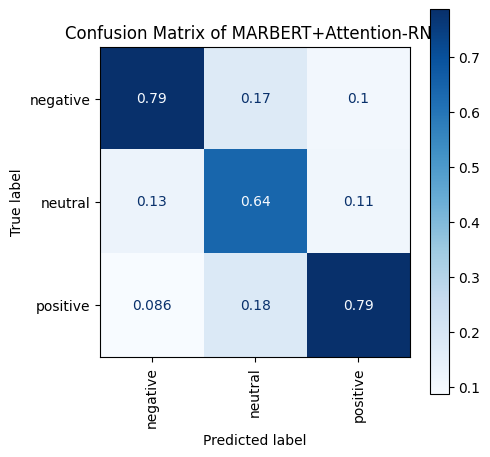

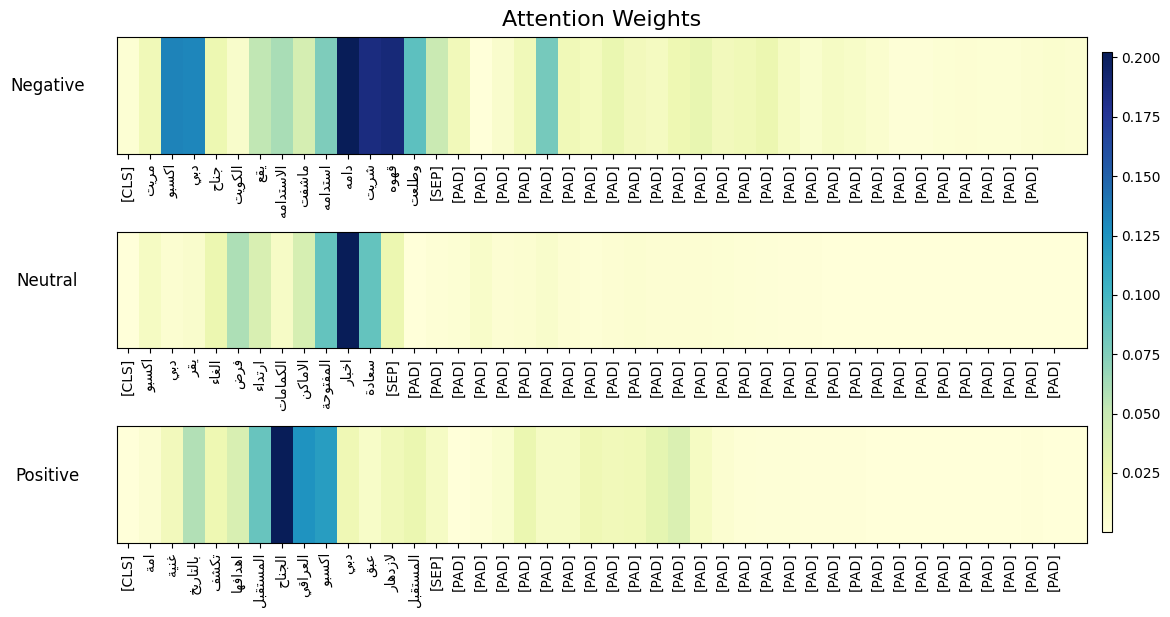

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


loss = 0.8622522726088769, val_loss =0.9793749622086593, accuracy = 0.5887058973312378, val_accuracy = 0.5693333148956299


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


loss = 0.6113065432427044, val_loss =0.9701865717759878, accuracy = 0.7413333654403687, val_accuracy = 0.6746666431427002


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


loss = 0.5655929586633678, val_loss =0.9310822081781648, accuracy = 0.762509822845459, val_accuracy = 0.628000020980835


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


loss = 0.5393368639682705, val_loss =0.6277903408448027, accuracy = 0.7763137221336365, val_accuracy = 0.7573333382606506


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.49579265223267394, val_loss =0.7268913687865993, accuracy = 0.7989019751548767, val_accuracy = 0.7479999661445618


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.48053960696179004, val_loss =0.7639080776545278, accuracy = 0.8062745332717896, val_accuracy = 0.7266666293144226


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


A model was saved at accuracy = 0.7759999632835388
loss = 0.4691111205870304, val_loss =0.682620680189836, accuracy = 0.8125490546226501, val_accuracy = 0.7759999632835388


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


loss = 0.4568985886288641, val_loss =0.6799954018584748, accuracy = 0.8065882325172424, val_accuracy = 0.7453333139419556


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.4546298564549266, val_loss =0.7126686546281883, accuracy = 0.812862753868103, val_accuracy = 0.7306666374206543


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.44711694763813725, val_loss =0.9810607047170231, accuracy = 0.8177254796028137, val_accuracy = 0.6759999990463257


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4365615297791765, val_loss =0.8828288147557624, accuracy = 0.8181961178779602, val_accuracy = 0.7133333086967468


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.4526629876428162, val_loss =0.7529100916036883, accuracy = 0.817098081111908, val_accuracy = 0.7213333249092102


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.43773436619473377, val_loss =0.691588295498944, accuracy = 0.8189803957939148, val_accuracy = 0.7479999661445618


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4281917668528352, val_loss =0.7470155639568715, accuracy = 0.8232157230377197, val_accuracy = 0.7133333086967468


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4326346214312877, val_loss =0.7632083351904823, accuracy = 0.8249412178993225, val_accuracy = 0.7160000205039978


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.42916300572130894, val_loss =0.7356153732714089, accuracy = 0.8261960744857788, val_accuracy = 0.7266666293144226


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4235436579382298, val_loss =0.9052959837660985, accuracy = 0.8240000009536743, val_accuracy = 0.6933333277702332


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.4135447818374914, val_loss =0.8566702930600338, accuracy = 0.831529438495636, val_accuracy = 0.6866666674613953


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.41295492153365065, val_loss =0.7275015343267316, accuracy = 0.8307451009750366, val_accuracy = 0.7013333439826965


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4007547347042644, val_loss =0.7222045358149968, accuracy = 0.8384314179420471, val_accuracy = 0.7239999771118164


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


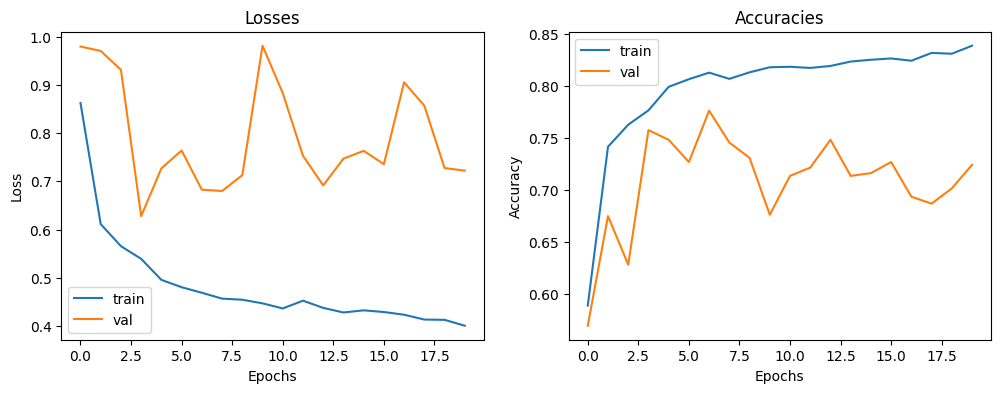

fully-connected hidden size = 128
Test correct = 543

Test total dataitem = 750

Test Accuracy = 0.7239999771118164

              precision    recall  f1-score   support

    negative       0.81      0.63      0.71       250
     neutral       0.69      0.75      0.72       250
    positive       0.69      0.79      0.74       250

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



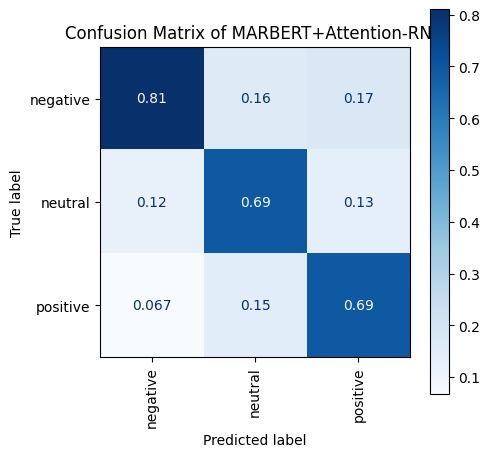

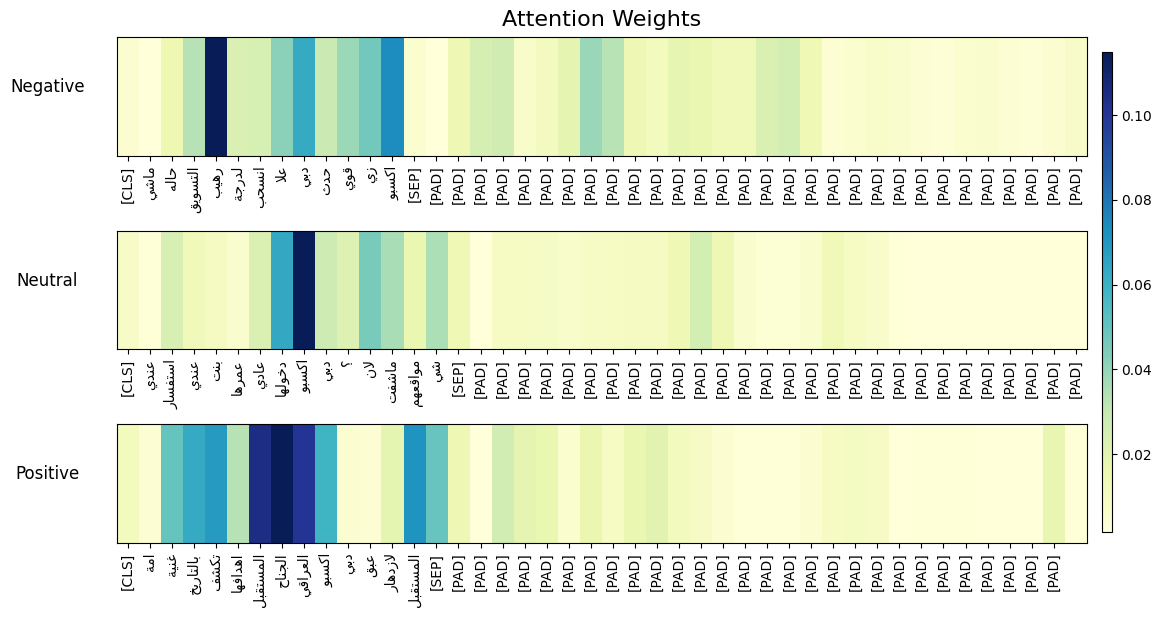

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.8177740935798592, val_loss =0.8412755988743627, accuracy = 0.6214901804924011, val_accuracy = 0.718666672706604


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


loss = 0.5721245691718011, val_loss =0.7442794122032838, accuracy = 0.7659608125686646, val_accuracy = 0.7613333463668823


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


loss = 0.5201476069947124, val_loss =0.8309017338355611, accuracy = 0.7901176810264587, val_accuracy = 0.7253333330154419


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.5112053358936052, val_loss =0.7544830017178269, accuracy = 0.7879216074943542, val_accuracy = 0.7453333139419556


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.481702805666286, val_loss =0.7999001258936467, accuracy = 0.7970196008682251, val_accuracy = 0.7413333058357239


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.47471619204143267, val_loss =0.6756156071798376, accuracy = 0.8098823428153992, val_accuracy = 0.7586666345596313


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.46687144400953334, val_loss =0.743051303216538, accuracy = 0.8054901957511902, val_accuracy = 0.7279999852180481


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.4528604696548129, val_loss =0.7480657997197023, accuracy = 0.8108235597610474, val_accuracy = 0.7413333058357239


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4629363461135234, val_loss =0.6978790153656571, accuracy = 0.8090980648994446, val_accuracy = 0.7333333492279053


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.4483977150164416, val_loss =0.6842440830842857, accuracy = 0.8181961178779602, val_accuracy = 0.7279999852180481


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.43250747068483947, val_loss =0.746457492700542, accuracy = 0.8203921914100647, val_accuracy = 0.7213333249092102


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.43149448053534073, val_loss =0.8361745817660234, accuracy = 0.824470579624176, val_accuracy = 0.7213333249092102


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


loss = 0.41994834846365897, val_loss =0.8221556617289658, accuracy = 0.8285490274429321, val_accuracy = 0.7239999771118164


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.4233861021103905, val_loss =0.6756173109122803, accuracy = 0.8235294222831726, val_accuracy = 0.7400000095367432


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


loss = 0.4217298168890952, val_loss =0.7641334092830556, accuracy = 0.827137291431427, val_accuracy = 0.7146666646003723


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4095447167987956, val_loss =0.7983136281960174, accuracy = 0.8269804120063782, val_accuracy = 0.7253333330154419


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.40842585783251306, val_loss =0.7572596615746541, accuracy = 0.8310588598251343, val_accuracy = 0.7173333168029785


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.41122826828616255, val_loss =0.8363043645890414, accuracy = 0.8357647061347961, val_accuracy = 0.6986666321754456


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.40167453305542516, val_loss =0.7540552671501123, accuracy = 0.8329411745071411, val_accuracy = 0.734666645526886


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.40070472883884684, val_loss =0.7773752826227128, accuracy = 0.8376470804214478, val_accuracy = 0.7146666646003723


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


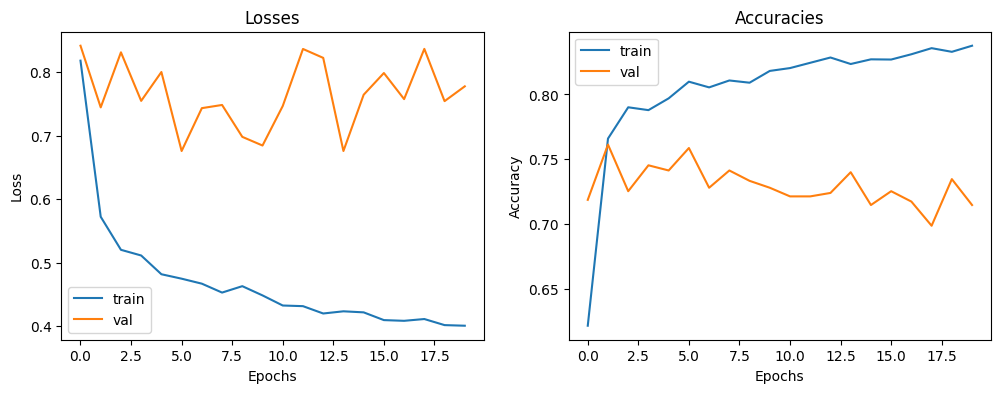

fully-connected hidden size = 256
Test correct = 536

Test total dataitem = 750

Test Accuracy = 0.7146666646003723

              precision    recall  f1-score   support

    negative       0.85      0.59      0.70       250
     neutral       0.70      0.69      0.70       250
    positive       0.65      0.86      0.74       250

    accuracy                           0.71       750
   macro avg       0.74      0.71      0.71       750
weighted avg       0.74      0.71      0.71       750



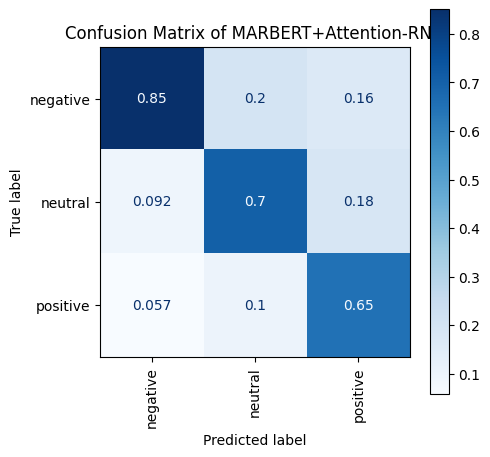

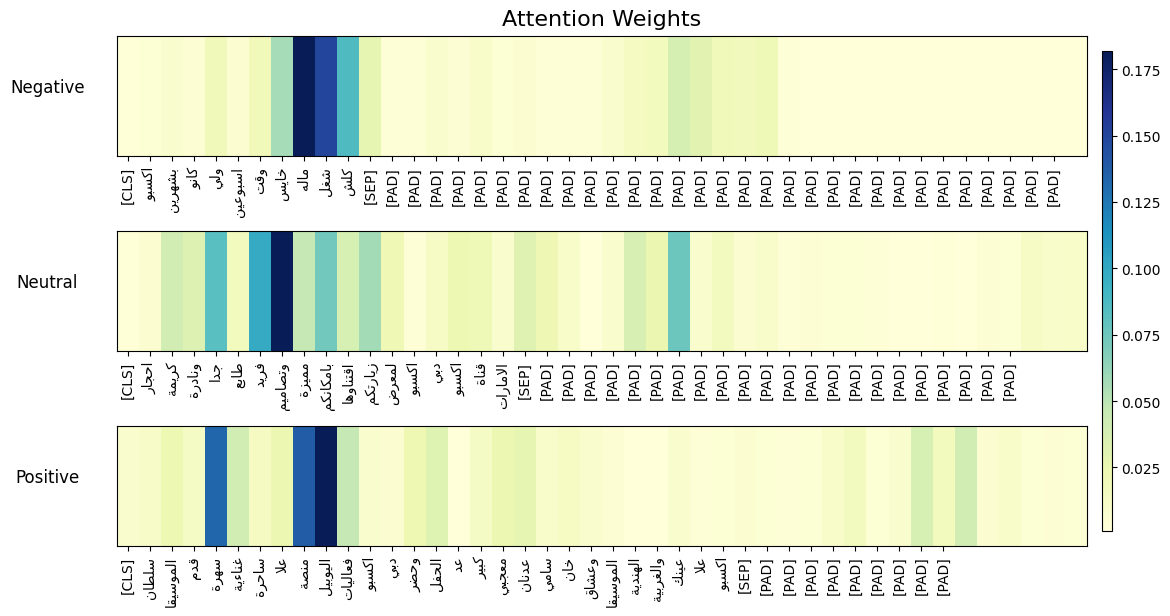

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


loss = 0.7790280251250843, val_loss =0.8872160440306697, accuracy = 0.6363921761512756, val_accuracy = 0.6786666512489319


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.5633596551622783, val_loss =0.8896678539331663, accuracy = 0.7618823647499084, val_accuracy = 0.6626666784286499


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5131814491529822, val_loss =0.8576564486923918, accuracy = 0.789647102355957, val_accuracy = 0.6973333358764648


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4865098901507081, val_loss =0.8780855938792005, accuracy = 0.8009411692619324, val_accuracy = 0.6866666674613953


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


A model was saved at accuracy = 0.7773333191871643
loss = 0.4703887091250941, val_loss =0.692930771614667, accuracy = 0.8064314126968384, val_accuracy = 0.7773333191871643


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


loss = 0.4623034292293561, val_loss =0.8080790765111043, accuracy = 0.8112941384315491, val_accuracy = 0.734666645526886


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4586297876677598, val_loss =0.7465332314799117, accuracy = 0.8142745494842529, val_accuracy = 0.7226666808128357


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4388450854635927, val_loss =1.2443448230283838, accuracy = 0.8196078538894653, val_accuracy = 0.6319999694824219


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.44059262899990026, val_loss =0.7819795518985903, accuracy = 0.8188235759735107, val_accuracy = 0.7173333168029785


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.43473956718766, val_loss =0.8110859114587486, accuracy = 0.8222745060920715, val_accuracy = 0.7066666483879089


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


A model was saved at accuracy = 0.7786666750907898
loss = 0.4303557892485954, val_loss =0.6792280366400595, accuracy = 0.8202353119850159, val_accuracy = 0.7786666750907898


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


loss = 0.43127624018019767, val_loss =0.915954333220669, accuracy = 0.8235294222831726, val_accuracy = 0.6653333306312561


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.42048887711371796, val_loss =0.8698753323367905, accuracy = 0.828705906867981, val_accuracy = 0.6826666593551636


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.42107317820190693, val_loss =1.0773866324965555, accuracy = 0.8238431811332703, val_accuracy = 0.6840000152587891


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4155946530188848, val_loss =0.8101772514644776, accuracy = 0.8337255120277405, val_accuracy = 0.718666672706604


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.40226533540712084, val_loss =0.7652064721054309, accuracy = 0.8305882811546326, val_accuracy = 0.7440000176429749


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4027787907573754, val_loss =0.8763693065164185, accuracy = 0.8269804120063782, val_accuracy = 0.6666666865348816


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.39712200699327554, val_loss =0.871493787669885, accuracy = 0.8376470804214478, val_accuracy = 0.6866666674613953


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.393149144446543, val_loss =0.7472395950250766, accuracy = 0.8382745385169983, val_accuracy = 0.7253333330154419


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.3991722720248346, val_loss =0.8497454921886556, accuracy = 0.8318431377410889, val_accuracy = 0.7146666646003723


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


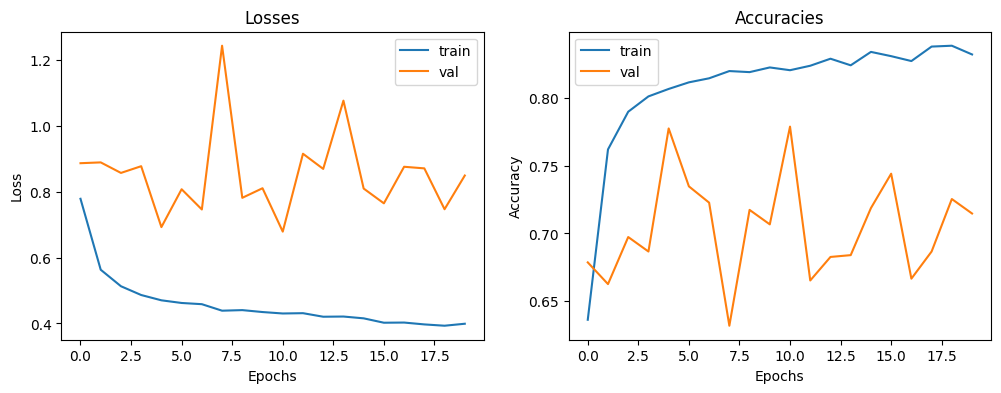

fully-connected hidden size = 512
Test correct = 536

Test total dataitem = 750

Test Accuracy = 0.7146666646003723

              precision    recall  f1-score   support

    negative       0.82      0.56      0.67       250
     neutral       0.64      0.81      0.71       250
    positive       0.74      0.78      0.76       250

    accuracy                           0.71       750
   macro avg       0.73      0.71      0.71       750
weighted avg       0.73      0.71      0.71       750



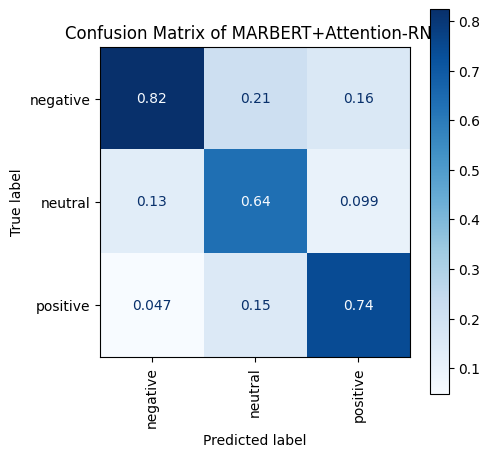

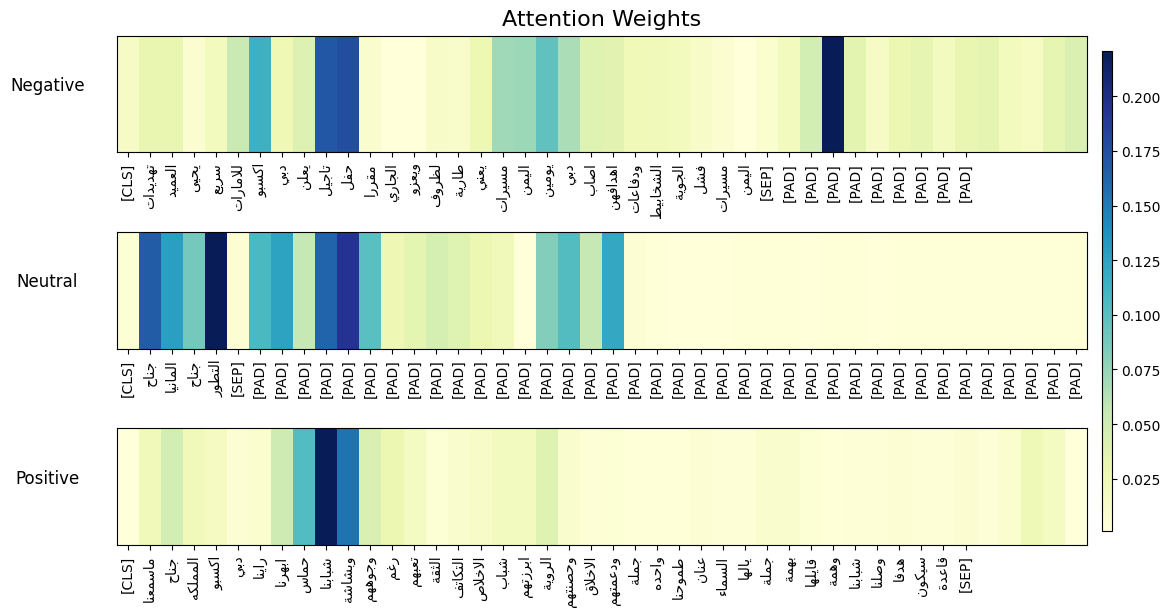

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
fc_hidden_size=[32,64,128,256,512]
for hidden_size in fc_hidden_size:
  model=AttentionRNN_AraBERT(hidden_size1,hidden_size,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
  print(f'fully-connected hidden size = {hidden_size}')
  test_and_report(model,test_loader,model_name,attention_added=True)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


loss = 0.8237717894552603, val_loss =0.7272496112887841, accuracy = 0.5992156863212585, val_accuracy = 0.7253333330154419


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


loss = 0.5697257308356891, val_loss =0.7482975568823679, accuracy = 0.7651764750480652, val_accuracy = 0.7093333005905151


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


loss = 0.5158484039795385, val_loss =0.7959996256010619, accuracy = 0.7894902229309082, val_accuracy = 0.7226666808128357


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


loss = 0.486352398138307, val_loss =0.70338081228575, accuracy = 0.8009411692619324, val_accuracy = 0.765333354473114


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


loss = 0.4859806668410896, val_loss =0.8428726918919255, accuracy = 0.8043921589851379, val_accuracy = 0.7253333330154419


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 0.46612596492896174, val_loss =0.8048406027490592, accuracy = 0.8065882325172424, val_accuracy = 0.7319999933242798


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4425886223798266, val_loss =0.8148518760677602, accuracy = 0.8149020075798035, val_accuracy = 0.7199999690055847


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.4488647405399206, val_loss =0.8184689260460347, accuracy = 0.8163137435913086, val_accuracy = 0.7386666536331177


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.44733601864279554, val_loss =0.7456530255680637, accuracy = 0.8133333325386047, val_accuracy = 0.7493333220481873


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.4245785631007412, val_loss =0.7198215844750058, accuracy = 0.8233725428581238, val_accuracy = 0.7373332977294922


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4259897088804045, val_loss =0.7392948843239068, accuracy = 0.8230588436126709, val_accuracy = 0.7400000095367432


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.41910425381478433, val_loss =0.6705833900828374, accuracy = 0.8327843546867371, val_accuracy = 0.7586666345596313


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.43142468591487476, val_loss =0.8014605145977342, accuracy = 0.8221176862716675, val_accuracy = 0.7360000014305115


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.4253981334252128, val_loss =0.6592273765731189, accuracy = 0.8268235325813293, val_accuracy = 0.7693333029747009


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.42509823658084606, val_loss =0.8155413510258587, accuracy = 0.8302745223045349, val_accuracy = 0.7239999771118164


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.41729420431355924, val_loss =0.6873361801783582, accuracy = 0.8313725590705872, val_accuracy = 0.7319999933242798


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4116426832090614, val_loss =0.7384695724489742, accuracy = 0.8320000171661377, val_accuracy = 0.7613333463668823


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4033983430140789, val_loss =0.8595804137106114, accuracy = 0.8345098495483398, val_accuracy = 0.7093333005905151


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.39716226834818785, val_loss =0.7663919480096663, accuracy = 0.8334118127822876, val_accuracy = 0.7253333330154419


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.3942707944351197, val_loss =0.8447649424890725, accuracy = 0.8382745385169983, val_accuracy = 0.7199999690055847


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


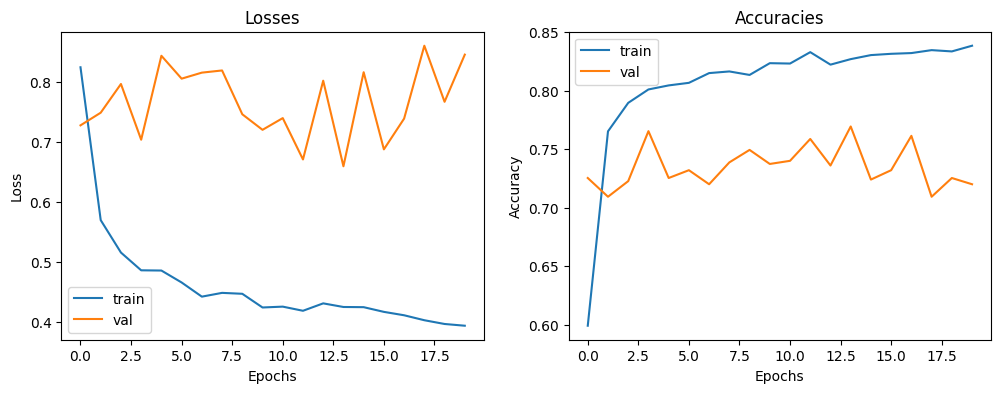

learning rate = 0.001
Test correct = 540

Test total dataitem = 750

Test Accuracy = 0.7199999690055847

              precision    recall  f1-score   support

    negative       0.84      0.56      0.67       250
     neutral       0.64      0.82      0.72       250
    positive       0.75      0.78      0.76       250

    accuracy                           0.72       750
   macro avg       0.74      0.72      0.72       750
weighted avg       0.74      0.72      0.72       750



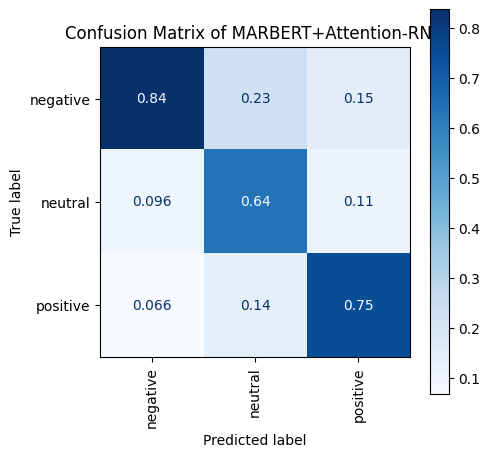

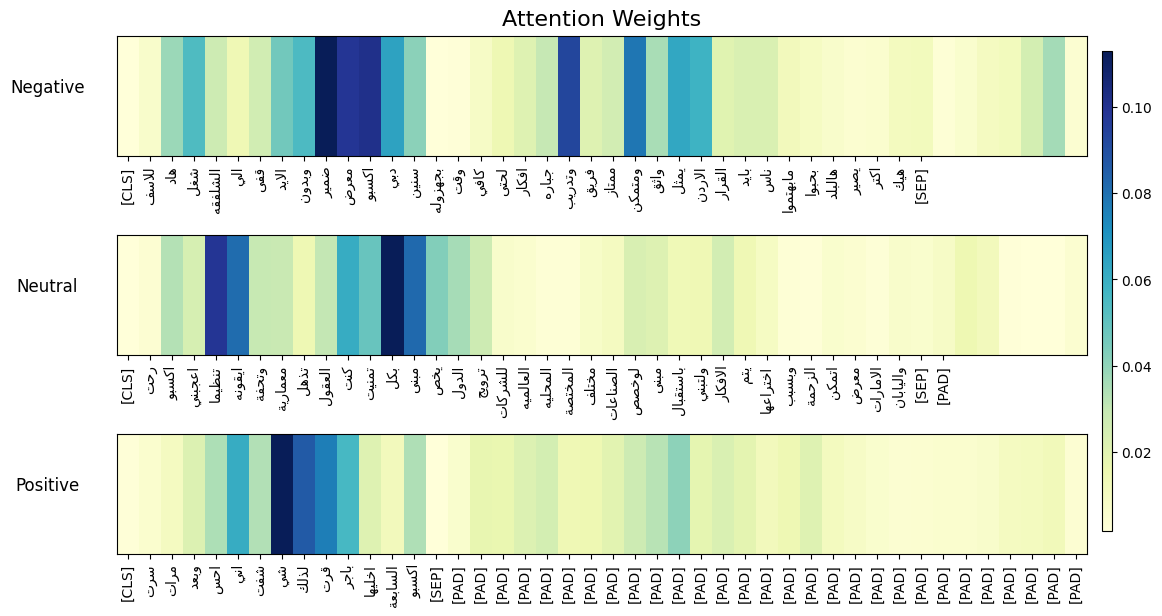

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.7391512966993646, val_loss =0.771498536633811, accuracy = 0.6578823924064636, val_accuracy = 0.7133333086967468


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.5403414010970254, val_loss =0.9597947264327775, accuracy = 0.7719215750694275, val_accuracy = 0.6480000019073486


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.5200185975391683, val_loss =0.784366568134835, accuracy = 0.786980390548706, val_accuracy = 0.7026666402816772


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.48703436050359383, val_loss =0.8979841483866976, accuracy = 0.8014118075370789, val_accuracy = 0.7133333086967468


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.49022554045916655, val_loss =0.6787233373818385, accuracy = 0.8001568913459778, val_accuracy = 0.7426666617393494


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.45819354988708, val_loss =0.8604120159868606, accuracy = 0.8142745494842529, val_accuracy = 0.6746666431427002


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4632794683628702, val_loss =0.7013590143766532, accuracy = 0.8059607744216919, val_accuracy = 0.734666645526886


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4479994954523089, val_loss =0.8089978987522196, accuracy = 0.8185098171234131, val_accuracy = 0.7093333005905151


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4402012477175148, val_loss =0.8127600611106355, accuracy = 0.824313759803772, val_accuracy = 0.7146666646003723


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.4403818834899606, val_loss =0.7689263632992563, accuracy = 0.819921612739563, val_accuracy = 0.7213333249092102


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.4284044710184128, val_loss =0.8364553427325575, accuracy = 0.8185098171234131, val_accuracy = 0.718666672706604


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.44046524035049517, val_loss =0.7817548942855784, accuracy = 0.8177254796028137, val_accuracy = 0.7226666808128357


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4159999062916864, val_loss =0.7010386641623038, accuracy = 0.8312156796455383, val_accuracy = 0.7279999852180481


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4222774088029304, val_loss =0.7919134832152329, accuracy = 0.8203921914100647, val_accuracy = 0.7013333439826965


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.4092475170641894, val_loss =0.6961270595556267, accuracy = 0.8288627862930298, val_accuracy = 0.7400000095367432


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.4242862746858649, val_loss =0.9079072421113251, accuracy = 0.828705906867981, val_accuracy = 0.6933333277702332


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4266552170565729, val_loss =0.7950774253735321, accuracy = 0.8240000009536743, val_accuracy = 0.7080000042915344


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4021300730387859, val_loss =0.7063309078897769, accuracy = 0.829960823059082, val_accuracy = 0.734666645526886


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.41033187238140406, val_loss =0.7200676958809082, accuracy = 0.8316863179206848, val_accuracy = 0.7319999933242798


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.3972926358707109, val_loss =0.7583012792945332, accuracy = 0.8357647061347961, val_accuracy = 0.718666672706604


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


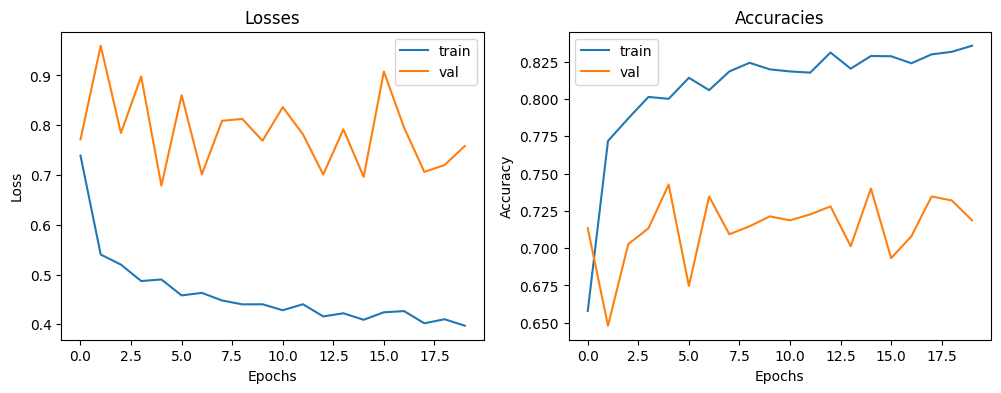

learning rate = 0.002
Test correct = 539

Test total dataitem = 750

Test Accuracy = 0.718666672706604

              precision    recall  f1-score   support

    negative       0.81      0.66      0.73       250
     neutral       0.61      0.82      0.70       250
    positive       0.79      0.68      0.73       250

    accuracy                           0.72       750
   macro avg       0.74      0.72      0.72       750
weighted avg       0.74      0.72      0.72       750



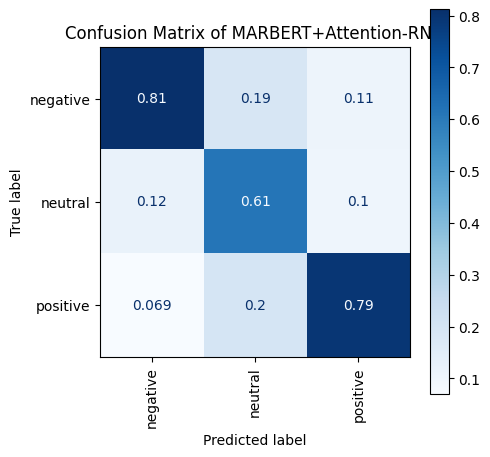

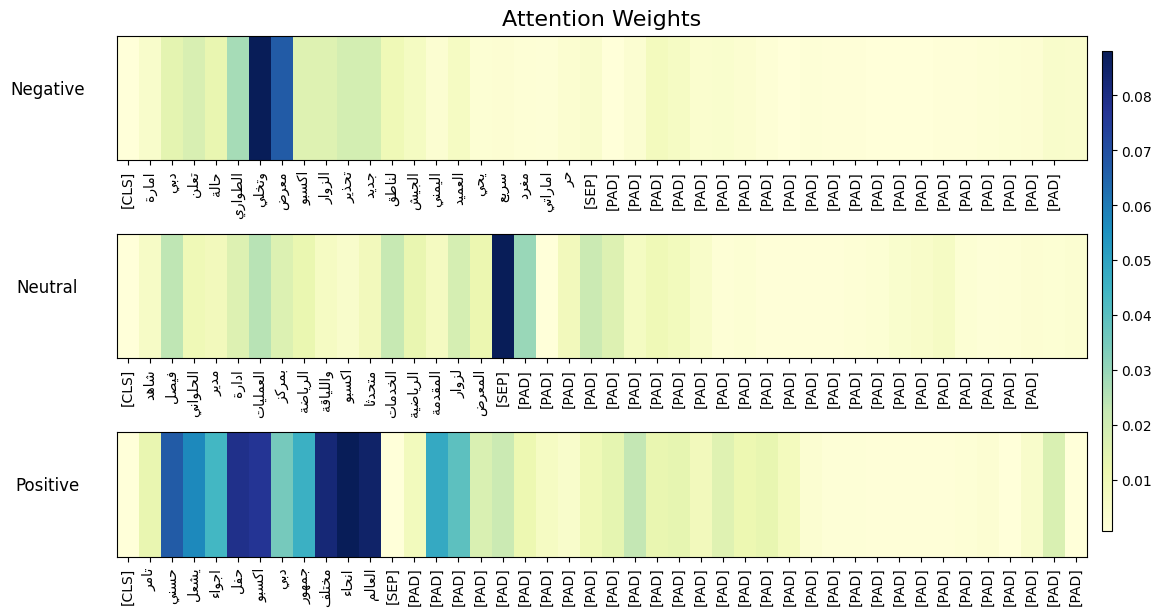

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.76431397157759, val_loss =0.6891068472663971, accuracy = 0.6464313864707947, val_accuracy = 0.7400000095367432


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


loss = 0.5561011508817088, val_loss =0.696487053217273, accuracy = 0.7733333706855774, val_accuracy = 0.753333330154419


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


loss = 0.5238432578244894, val_loss =0.7399972847625623, accuracy = 0.7783529758453369, val_accuracy = 0.7239999771118164


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.5127231149869841, val_loss =0.7961355869617456, accuracy = 0.7921568751335144, val_accuracy = 0.6973333358764648


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4789723662344895, val_loss =0.7455053209372986, accuracy = 0.8061176538467407, val_accuracy = 0.7053333520889282


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4698110743633553, val_loss =0.6349523946167644, accuracy = 0.8076862692832947, val_accuracy = 0.7479999661445618


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4556303074851016, val_loss =1.1358731418779435, accuracy = 0.8186666965484619, val_accuracy = 0.6426666378974915


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.4504451579228908, val_loss =0.7511966656904506, accuracy = 0.8174117803573608, val_accuracy = 0.7120000123977661


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.4539948671617173, val_loss =0.9236014259449523, accuracy = 0.8125490546226501, val_accuracy = 0.6746666431427002


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.45841216235080046, val_loss =0.637562781374652, accuracy = 0.8158431649208069, val_accuracy = 0.746666669845581


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.44310138512946784, val_loss =0.6281991441681688, accuracy = 0.8166274428367615, val_accuracy = 0.7386666536331177


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4355993619346606, val_loss =0.8560172912170773, accuracy = 0.8235294222831726, val_accuracy = 0.6893333196640015


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.43028091391542483, val_loss =0.6968160774883976, accuracy = 0.8208627700805664, val_accuracy = 0.7319999933242798


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.43668414445285775, val_loss =0.7202418999742831, accuracy = 0.8214902281761169, val_accuracy = 0.7199999690055847


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.43312435881059913, val_loss =0.7016451231525194, accuracy = 0.821647047996521, val_accuracy = 0.7279999852180481


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.42276257055854843, val_loss =0.6462426213478963, accuracy = 0.8310588598251343, val_accuracy = 0.7306666374206543


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.42719128175162674, val_loss =0.8082557292555775, accuracy = 0.8280784487724304, val_accuracy = 0.6933333277702332


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.41975440659398267, val_loss =0.683640887763339, accuracy = 0.8370196223258972, val_accuracy = 0.7333333492279053


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.42622979236259206, val_loss =0.8034906289138632, accuracy = 0.8208627700805664, val_accuracy = 0.7039999961853027


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.43439506386040916, val_loss =0.6817526607068038, accuracy = 0.8191372752189636, val_accuracy = 0.734666645526886


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


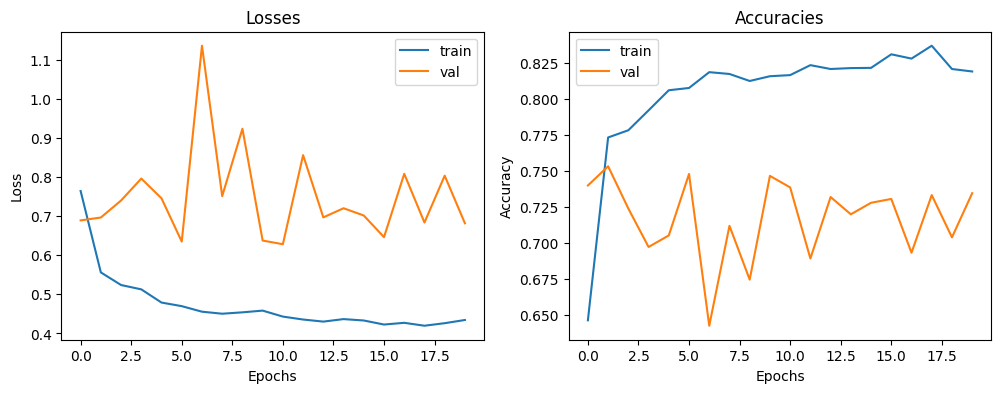

learning rate = 0.003
Test correct = 551

Test total dataitem = 750

Test Accuracy = 0.734666645526886

              precision    recall  f1-score   support

    negative       0.80      0.72      0.76       250
     neutral       0.64      0.84      0.72       250
    positive       0.83      0.65      0.73       250

    accuracy                           0.73       750
   macro avg       0.75      0.73      0.74       750
weighted avg       0.75      0.73      0.74       750



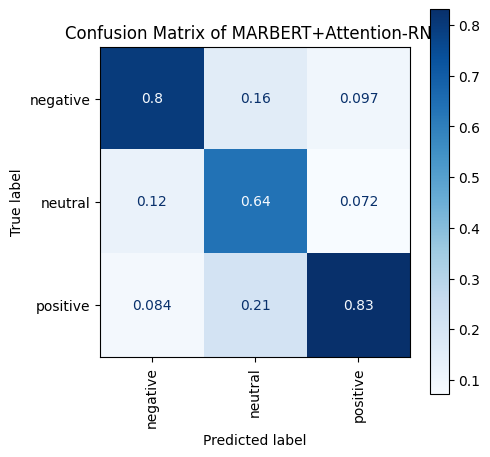

<ipython-input-16-3adf064bf7de>:36: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


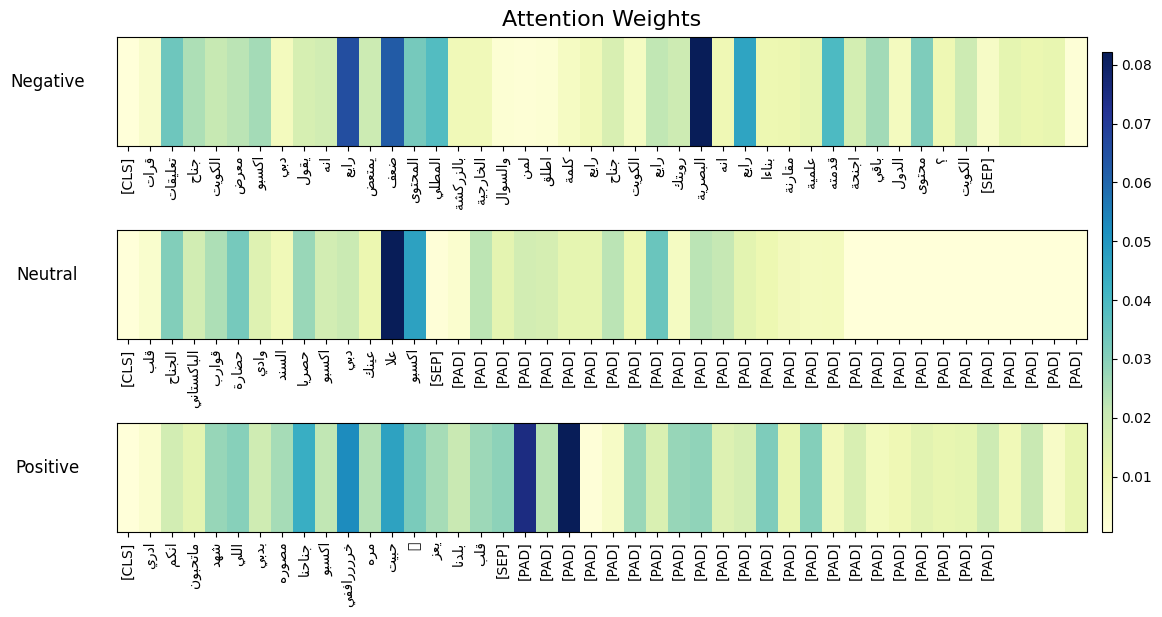

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 1.0667788106198304, val_loss =0.9972984848267304, accuracy = 0.4255686402320862, val_accuracy = 0.5973333120346069


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.869801221098303, val_loss =0.9580844965773091, accuracy = 0.588549017906189, val_accuracy = 0.5693333148956299


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.694733870595101, val_loss =0.8596525281005808, accuracy = 0.7021176815032959, val_accuracy = 0.6866666674613953


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5905546914478719, val_loss =0.8449420931961683, accuracy = 0.7556078433990479, val_accuracy = 0.687999963760376


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5536844545117193, val_loss =0.8494350668052651, accuracy = 0.7738039493560791, val_accuracy = 0.718666672706604


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5394648438609725, val_loss =0.8660982425200823, accuracy = 0.7747451066970825, val_accuracy = 0.7160000205039978


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5190617802196376, val_loss =0.9866492526760049, accuracy = 0.7832157015800476, val_accuracy = 0.6733333468437195


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


loss = 0.5185933563558259, val_loss =0.9108760027106061, accuracy = 0.7934117913246155, val_accuracy = 0.7093333005905151


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


loss = 0.499526276147669, val_loss =1.000524744549746, accuracy = 0.8003137707710266, val_accuracy = 0.690666675567627


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5005715707356462, val_loss =0.9190970529216166, accuracy = 0.7960784435272217, val_accuracy = 0.7093333005905151


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.5026542905142728, val_loss =0.9700030864219445, accuracy = 0.7945098280906677, val_accuracy = 0.7199999690055847


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4849567762345918, val_loss =0.9294911216994227, accuracy = 0.8014118075370789, val_accuracy = 0.718666672706604


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4821903092874914, val_loss =0.9929506134301292, accuracy = 0.8034510016441345, val_accuracy = 0.6773333549499512


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4730214153761764, val_loss =0.9341183404014664, accuracy = 0.8094117641448975, val_accuracy = 0.7160000205039978


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.47559738315862815, val_loss =1.0038137206186588, accuracy = 0.802823543548584, val_accuracy = 0.7120000123977661


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.48101920376033286, val_loss =0.9895342504299917, accuracy = 0.8069019913673401, val_accuracy = 0.7146666646003723


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.46022984360638264, val_loss =0.983978683821487, accuracy = 0.8152157068252563, val_accuracy = 0.7293333411216736


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.46871853204387803, val_loss =1.050637556491273, accuracy = 0.8078431487083435, val_accuracy = 0.6759999990463257


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.47184773827139836, val_loss =0.9018593523438158, accuracy = 0.8089411854743958, val_accuracy = 0.7413333058357239


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.46703307098672153, val_loss =1.069530436952358, accuracy = 0.8127058744430542, val_accuracy = 0.6813333034515381


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


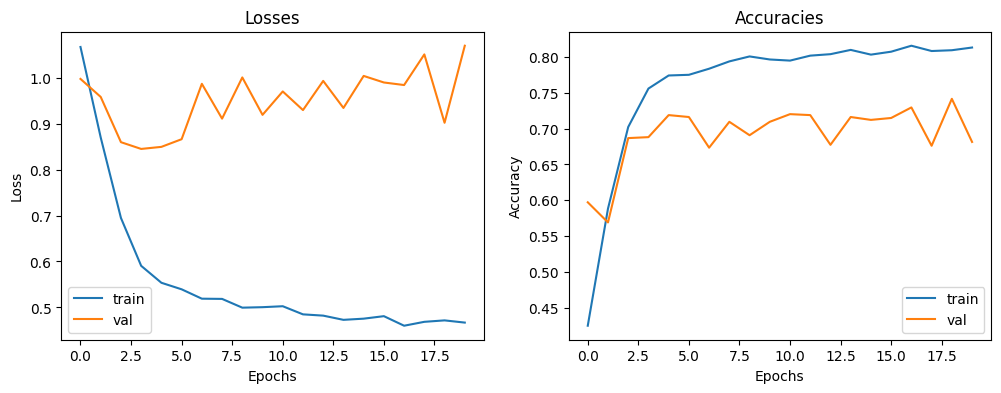

learning rate = 0.0001
Test correct = 511

Test total dataitem = 750

Test Accuracy = 0.6813333034515381

              precision    recall  f1-score   support

    negative       0.81      0.56      0.66       250
     neutral       0.68      0.68      0.68       250
    positive       0.61      0.81      0.70       250

    accuracy                           0.68       750
   macro avg       0.70      0.68      0.68       750
weighted avg       0.70      0.68      0.68       750



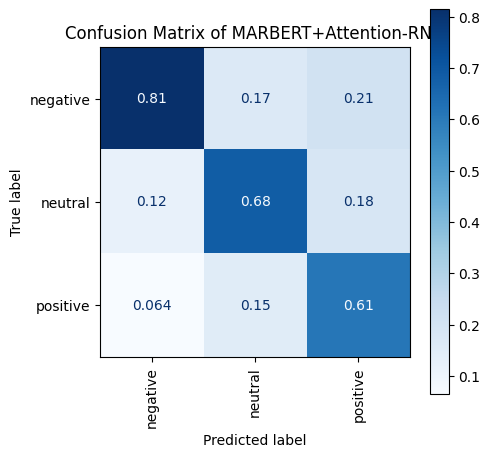

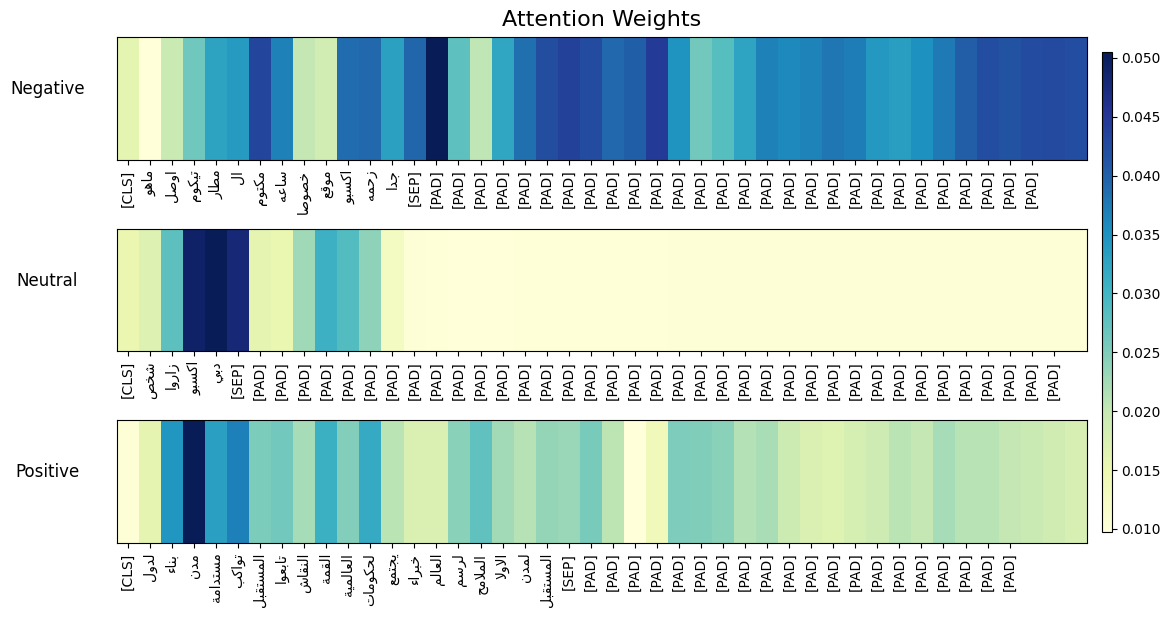

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.9997823881092242, val_loss =0.8988767528001294, accuracy = 0.48768627643585205, val_accuracy = 0.5960000157356262


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


loss = 0.7109900522493058, val_loss =1.4203304897053624, accuracy = 0.6865882277488708, val_accuracy = 0.5426666736602783


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.5910435689346363, val_loss =1.127751450720928, accuracy = 0.7515294551849365, val_accuracy = 0.6800000071525574


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


loss = 0.5576260678138742, val_loss =0.9947290063482006, accuracy = 0.7659608125686646, val_accuracy = 0.7053333520889282


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


loss = 0.5196000667490817, val_loss =1.0682215650656122, accuracy = 0.7885490655899048, val_accuracy = 0.6866666674613953


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.510642197447736, val_loss =1.0115179155909442, accuracy = 0.7891764640808105, val_accuracy = 0.7239999771118164


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


loss = 0.5042387267277585, val_loss =1.2029237918118005, accuracy = 0.7902745008468628, val_accuracy = 0.6840000152587891


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.4906007737376039, val_loss =0.99118324045615, accuracy = 0.7981176376342773, val_accuracy = 0.7253333330154419


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.47919448282627575, val_loss =1.156191498085761, accuracy = 0.8051764965057373, val_accuracy = 0.7039999961853027


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4819029170208925, val_loss =1.0829025188854493, accuracy = 0.8067451119422913, val_accuracy = 0.7120000123977661


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4634261858668488, val_loss =1.332581961035341, accuracy = 0.811607837677002, val_accuracy = 0.6853333115577698


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.46127536461770385, val_loss =1.0037580332591756, accuracy = 0.8150588274002075, val_accuracy = 0.7319999933242798


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.46167929460791596, val_loss =1.131029531936737, accuracy = 0.8149020075798035, val_accuracy = 0.6959999799728394


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.459120557049866, val_loss =1.2575913673512813, accuracy = 0.8177254796028137, val_accuracy = 0.6786666512489319


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.46399764870221444, val_loss =1.0764205618972946, accuracy = 0.8109804391860962, val_accuracy = 0.7226666808128357


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4585961463433719, val_loss =1.004480085833823, accuracy = 0.8090980648994446, val_accuracy = 0.7120000123977661


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.456397223797758, val_loss =1.0613280685282047, accuracy = 0.8122352957725525, val_accuracy = 0.7133333086967468


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.44776047353802917, val_loss =1.198280790181361, accuracy = 0.817098081111908, val_accuracy = 0.6800000071525574


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4440847968125425, val_loss =1.1870816809752156, accuracy = 0.8211764693260193, val_accuracy = 0.6693333387374878


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4477975981363705, val_loss =1.2231597065138982, accuracy = 0.8177254796028137, val_accuracy = 0.6959999799728394


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


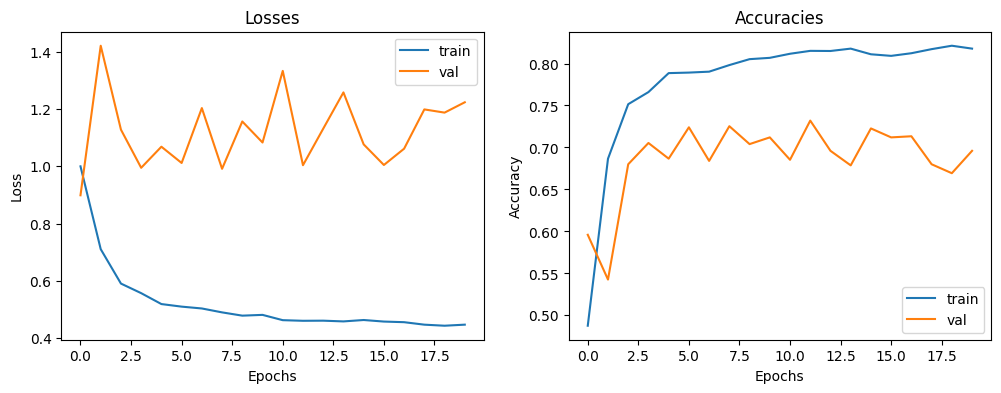

learning rate = 0.0002
Test correct = 522

Test total dataitem = 750

Test Accuracy = 0.6959999799728394

              precision    recall  f1-score   support

    negative       0.84      0.54      0.66       250
     neutral       0.66      0.77      0.71       250
    positive       0.65      0.78      0.71       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.69       750
weighted avg       0.72      0.70      0.69       750



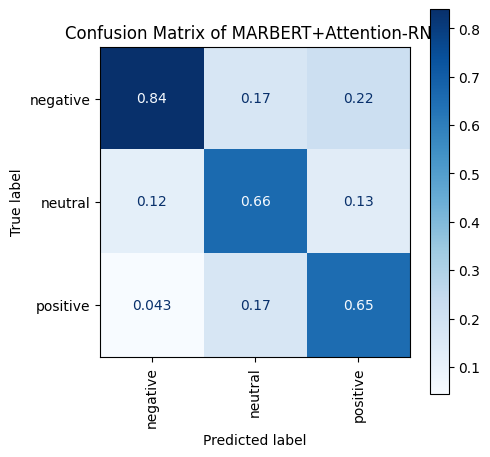

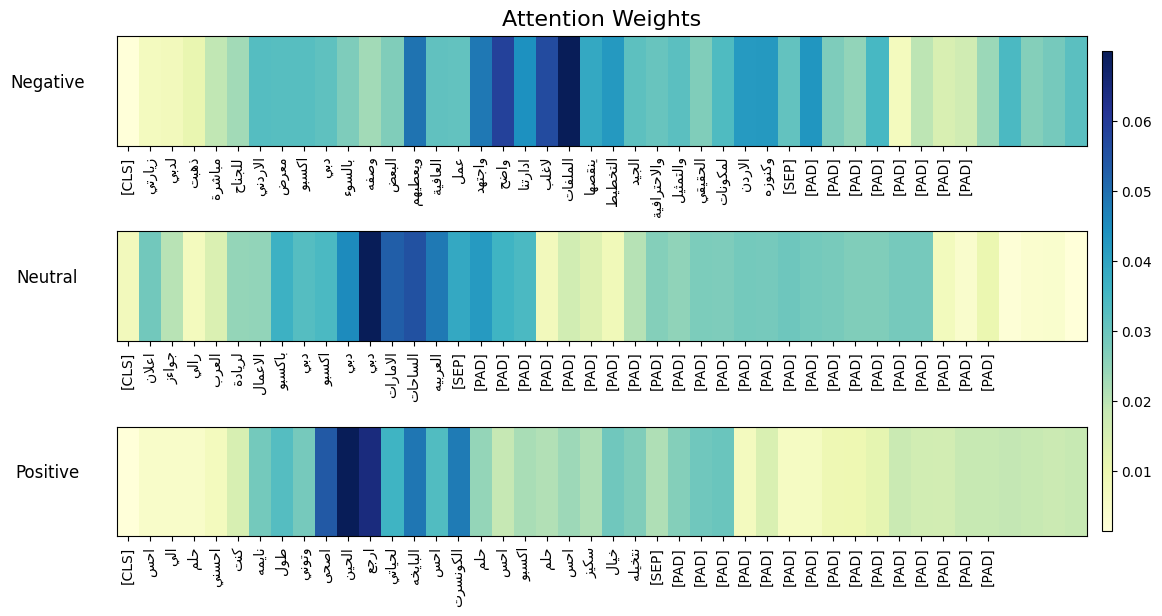

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.9223175083475639, val_loss =0.8141501162083485, accuracy = 0.527843177318573, val_accuracy = 0.6893333196640015


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.6287939741546534, val_loss =0.7744037474778347, accuracy = 0.7281568646430969, val_accuracy = 0.7493333220481873


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.5472364780513714, val_loss =0.9819492156138422, accuracy = 0.7760000228881836, val_accuracy = 0.6933333277702332


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.5277405767795813, val_loss =0.7506124926975302, accuracy = 0.7858823537826538, val_accuracy = 0.753333330154419


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.5135204325367536, val_loss =0.7547780528450502, accuracy = 0.7898039221763611, val_accuracy = 0.7386666536331177


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.4937092389528954, val_loss =0.8639517406283755, accuracy = 0.7951372861862183, val_accuracy = 0.7199999690055847


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.4861764174824195, val_loss =1.105277709856561, accuracy = 0.8025098443031311, val_accuracy = 0.6826666593551636


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.4815207404179737, val_loss =0.8189231519634639, accuracy = 0.8010980486869812, val_accuracy = 0.7413333058357239


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.47836877361611163, val_loss =0.8040589884338959, accuracy = 0.796862781047821, val_accuracy = 0.7493333220481873


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4638953993886908, val_loss =0.826244969508226, accuracy = 0.8078431487083435, val_accuracy = 0.7400000095367432


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4622442927758097, val_loss =0.8077948159126156, accuracy = 0.808470606803894, val_accuracy = 0.7546666860580444


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4578272055958258, val_loss =1.0474933293128783, accuracy = 0.8145882487297058, val_accuracy = 0.7066666483879089


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4424609905668329, val_loss =0.7749242191637502, accuracy = 0.8196078538894653, val_accuracy = 0.7573333382606506


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.44676514758535874, val_loss =0.9324887670309395, accuracy = 0.8169412016868591, val_accuracy = 0.7160000205039978


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.4438742203813932, val_loss =0.804097168420554, accuracy = 0.8194509744644165, val_accuracy = 0.7279999852180481


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


loss = 0.4364818768020842, val_loss =0.8321318784887627, accuracy = 0.8236863017082214, val_accuracy = 0.7360000014305115


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


loss = 0.440838647064556, val_loss =0.8609362404124593, accuracy = 0.8207058906555176, val_accuracy = 0.7279999852180481


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


loss = 0.42409769844281314, val_loss =0.8010177850477286, accuracy = 0.8290196061134338, val_accuracy = 0.7559999823570251


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.4263283381648235, val_loss =0.7794406413396028, accuracy = 0.8288627862930298, val_accuracy = 0.762666642665863


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 0.4288869788395685, val_loss =0.8085901141533426, accuracy = 0.8205490112304688, val_accuracy = 0.7519999742507935


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


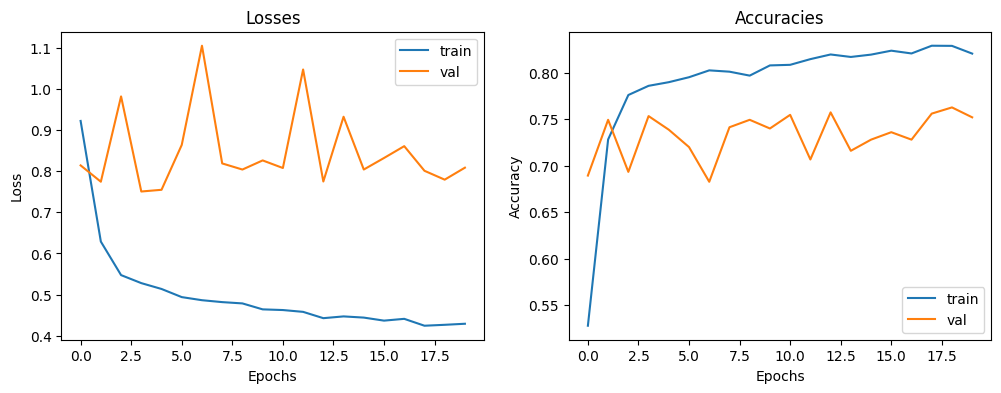

learning rate = 0.0003
Test correct = 564

Test total dataitem = 750

Test Accuracy = 0.7519999742507935

              precision    recall  f1-score   support

    negative       0.79      0.73      0.76       250
     neutral       0.67      0.80      0.73       250
    positive       0.81      0.73      0.77       250

    accuracy                           0.75       750
   macro avg       0.76      0.75      0.75       750
weighted avg       0.76      0.75      0.75       750



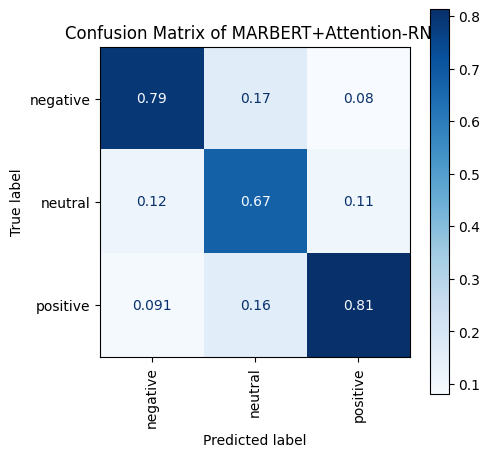

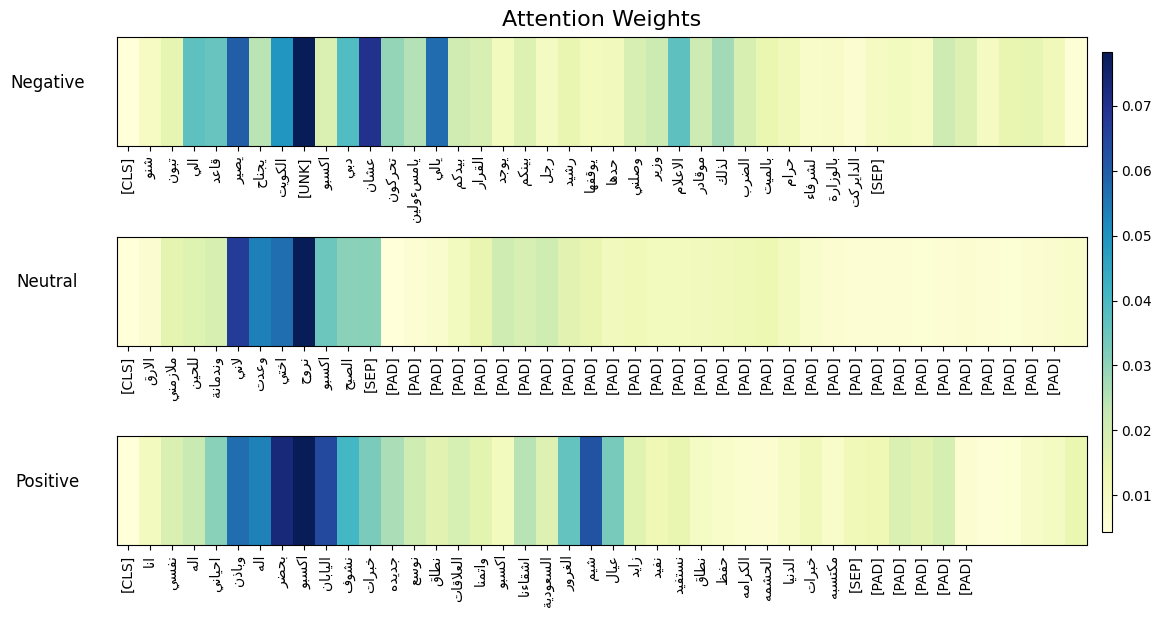

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


loss = 1.159134138344954, val_loss =1.0990487940649947, accuracy = 0.3482353091239929, val_accuracy = 0.37599998712539673


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 1.117451985379299, val_loss =1.0843237938622579, accuracy = 0.3700392246246338, val_accuracy = 0.43066665530204773


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 1.0883792900627192, val_loss =1.0729344016214346, accuracy = 0.401411771774292, val_accuracy = 0.45333331823349


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 1.0754696963518524, val_loss =1.0658062884509834, accuracy = 0.41505882143974304, val_accuracy = 0.46266666054725647


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 1.053681424415957, val_loss =1.052923089191925, accuracy = 0.4387451112270355, val_accuracy = 0.47466665506362915


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 1.0402967868472497, val_loss =1.043869521716893, accuracy = 0.4511372745037079, val_accuracy = 0.4880000054836273


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 1.0142254082609612, val_loss =1.0215864491065207, accuracy = 0.48941177129745483, val_accuracy = 0.518666684627533


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.9889206991301707, val_loss =1.0111156854840953, accuracy = 0.5109019875526428, val_accuracy = 0.5506666898727417


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.9600534892253553, val_loss =0.978820250333334, accuracy = 0.5367843508720398, val_accuracy = 0.5680000185966492


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.9319069680308876, val_loss =0.946446297072765, accuracy = 0.5620392560958862, val_accuracy = 0.5773333311080933


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.8963857375005952, val_loss =0.9410130088335659, accuracy = 0.5816470980644226, val_accuracy = 0.5719999670982361


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.8715955443605661, val_loss =0.9331216230770013, accuracy = 0.586980402469635, val_accuracy = 0.5680000185966492


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.8486484766889137, val_loss =0.9599691061501262, accuracy = 0.6025097966194153, val_accuracy = 0.5640000104904175


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.82857987807192, val_loss =0.972928315309126, accuracy = 0.6197647452354431, val_accuracy = 0.5759999752044678


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.8153815097302402, val_loss =0.9898888078386191, accuracy = 0.6230588555335999, val_accuracy = 0.5719999670982361


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.795807882084971, val_loss =1.0016253311663657, accuracy = 0.6280784606933594, val_accuracy = 0.5706666707992554


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.7807958690994061, val_loss =1.0209710897234154, accuracy = 0.6461176872253418, val_accuracy = 0.5666666626930237


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.7627564590143858, val_loss =1.0050277808724153, accuracy = 0.6572549343109131, val_accuracy = 0.590666651725769


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.7443362773232497, val_loss =1.0131380751377235, accuracy = 0.6616470813751221, val_accuracy = 0.5999999642372131


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.7305392687438497, val_loss =1.0517438813300375, accuracy = 0.6825098395347595, val_accuracy = 0.5893333554267883


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


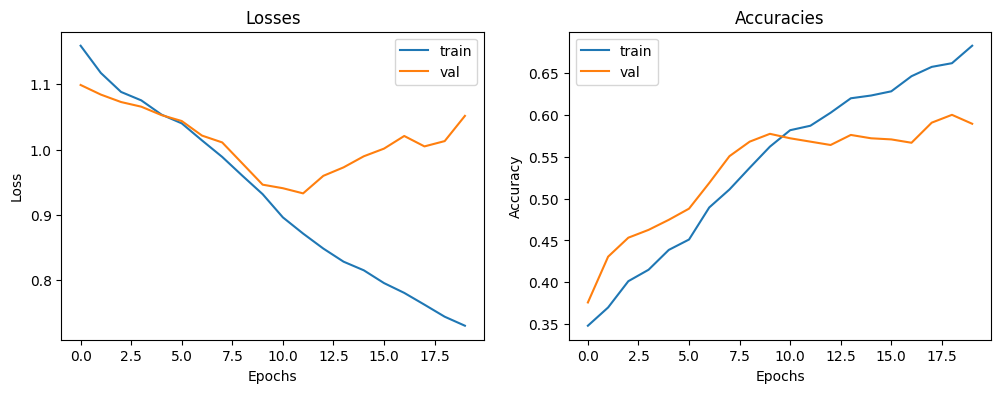

learning rate = 1e-05
Test correct = 442

Test total dataitem = 750

Test Accuracy = 0.5893333554267883

              precision    recall  f1-score   support

    negative       0.57      0.94      0.71       250
     neutral       0.58      0.68      0.63       250
    positive       0.76      0.15      0.25       250

    accuracy                           0.59       750
   macro avg       0.64      0.59      0.53       750
weighted avg       0.64      0.59      0.53       750



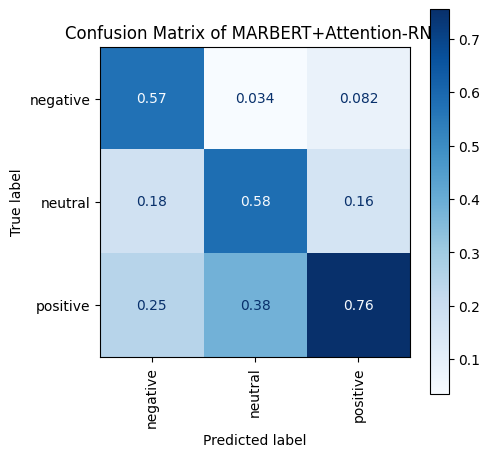

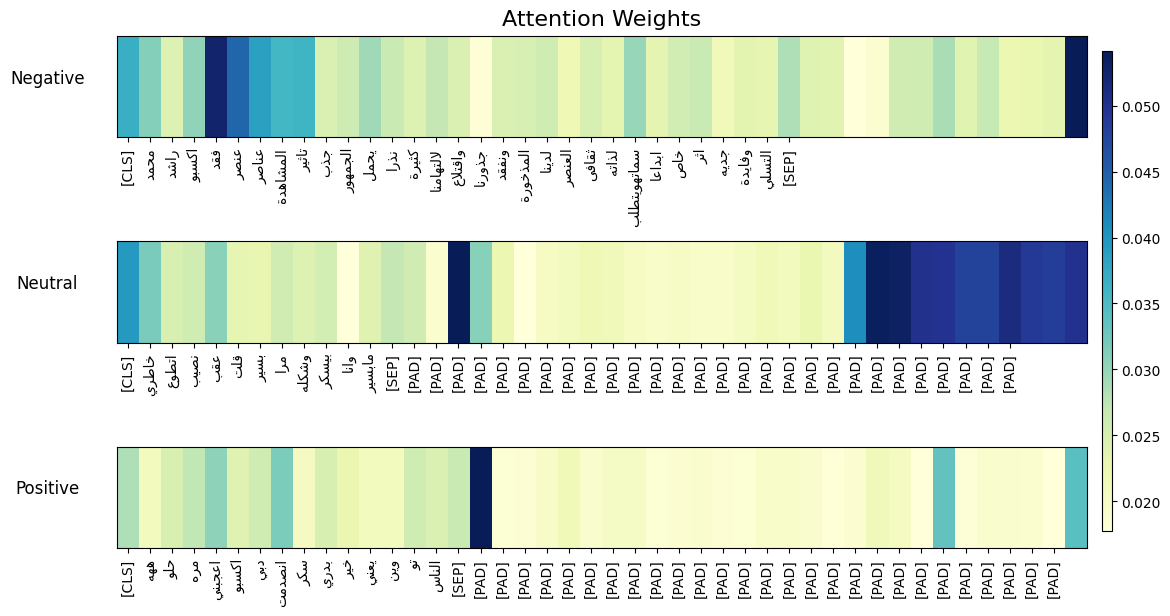

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=256
learning_rates=[0.001,0.002,0.003,0.0001,0.0002,0.0003,0.00001]
for learning_rate in learning_rates:
  model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
  print(f'learning rate = {learning_rate}')
  test_and_report(model,test_loader,model_name,attention_added=True)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


loss = 0.8495951697780177, val_loss =0.7125765240164491, accuracy = 0.5872941017150879, val_accuracy = 0.699999988079071


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


loss = 0.5654925112034498, val_loss =0.684415178553615, accuracy = 0.7639215588569641, val_accuracy = 0.7146666646003723


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.519229158708775, val_loss =0.685568200696081, accuracy = 0.7838431596755981, val_accuracy = 0.7226666808128357


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.49572353863512175, val_loss =0.8659182384067802, accuracy = 0.7978039383888245, val_accuracy = 0.6706666350364685


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


loss = 0.47978221831996704, val_loss =0.7450766723873329, accuracy = 0.8010980486869812, val_accuracy = 0.7026666402816772


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4617980715987286, val_loss =0.6731115905185225, accuracy = 0.8158431649208069, val_accuracy = 0.7373332977294922


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.45543775697061323, val_loss =0.803754069803804, accuracy = 0.8131765127182007, val_accuracy = 0.6599999666213989


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.45387318484767697, val_loss =0.6646784366751134, accuracy = 0.8139607906341553, val_accuracy = 0.7360000014305115


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.43302381815159985, val_loss =0.8126596844487749, accuracy = 0.8236863017082214, val_accuracy = 0.6813333034515381


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4187704118545599, val_loss =0.8279003364261661, accuracy = 0.8233725428581238, val_accuracy = 0.6866666674613953


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.41479880908066313, val_loss =0.8523360446845246, accuracy = 0.831529438495636, val_accuracy = 0.690666675567627


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.40728501048487653, val_loss =0.6851926644740755, accuracy = 0.8345098495483398, val_accuracy = 0.7373332977294922


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.39010262898755627, val_loss =0.6861506260153241, accuracy = 0.8407843112945557, val_accuracy = 0.7333333492279053


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.37808492335258237, val_loss =0.7476787702716453, accuracy = 0.8498823642730713, val_accuracy = 0.7133333086967468


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.38346562006168905, val_loss =0.7910810607054306, accuracy = 0.8454902172088623, val_accuracy = 0.7093333005905151


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.3731182248026796, val_loss =0.6956110713087379, accuracy = 0.848784327507019, val_accuracy = 0.7293333411216736


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.37006137361986197, val_loss =0.7832744063110711, accuracy = 0.8509804010391235, val_accuracy = 0.6959999799728394


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.3609000230953539, val_loss =0.7038388142272843, accuracy = 0.8545882701873779, val_accuracy = 0.7333333492279053


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.3650924589293983, val_loss =0.9113127571566645, accuracy = 0.8536470532417297, val_accuracy = 0.690666675567627


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.3431399495225429, val_loss =0.7945951692724975, accuracy = 0.8622745275497437, val_accuracy = 0.7173333168029785


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


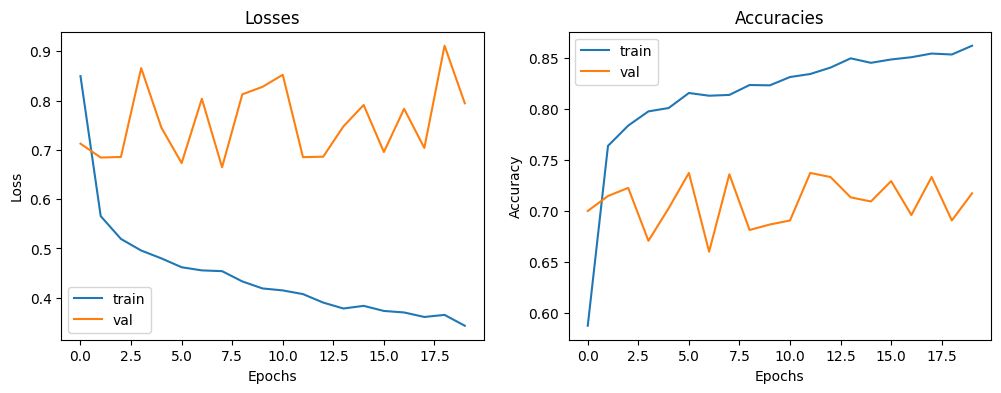

dropout rate = 0
Test correct = 538

Test total dataitem = 750

Test Accuracy = 0.7173333168029785

              precision    recall  f1-score   support

    negative       0.81      0.61      0.70       250
     neutral       0.65      0.76      0.70       250
    positive       0.73      0.78      0.75       250

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



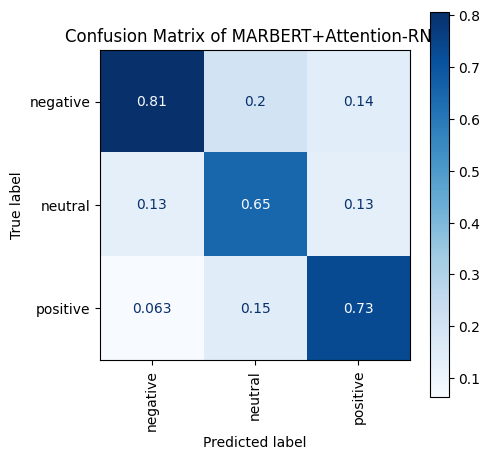

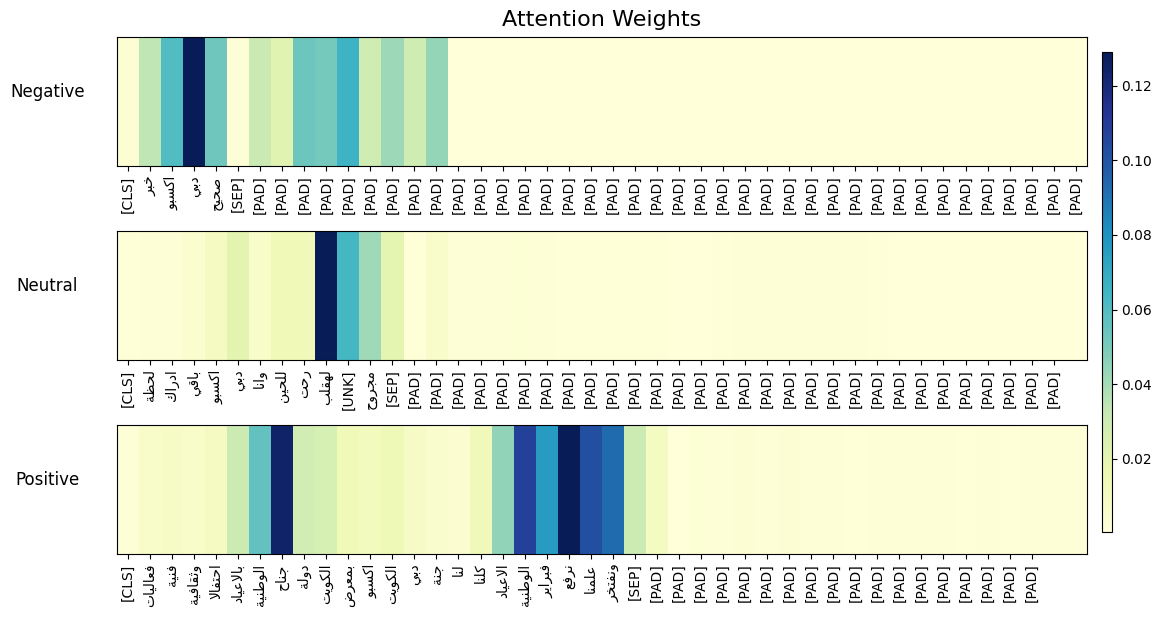

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.8582795827109695, val_loss =0.7350401351613455, accuracy = 0.5829019546508789, val_accuracy = 0.6959999799728394


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5950188748489614, val_loss =0.7875338025211628, accuracy = 0.7499607801437378, val_accuracy = 0.6853333115577698


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5125320794479361, val_loss =0.663332049805831, accuracy = 0.7850980758666992, val_accuracy = 0.746666669845581


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4869509874530717, val_loss =0.7173387387135427, accuracy = 0.8004705905914307, val_accuracy = 0.7266666293144226


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.47632071759223504, val_loss =0.6775986270809037, accuracy = 0.8029804229736328, val_accuracy = 0.7213333249092102


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.47425564332857434, val_loss =0.7109361102559005, accuracy = 0.8043921589851379, val_accuracy = 0.7173333168029785


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.45166577611787756, val_loss =0.6498910227437854, accuracy = 0.8160000443458557, val_accuracy = 0.7239999771118164


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4632114058401594, val_loss =0.7882821934346028, accuracy = 0.8062745332717896, val_accuracy = 0.6840000152587891


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4411460005095171, val_loss =0.6429826576107623, accuracy = 0.8222745060920715, val_accuracy = 0.7693333029747009


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.4399636739956352, val_loss =0.665670888070383, accuracy = 0.8183529376983643, val_accuracy = 0.7493333220481873


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.42308258896796147, val_loss =0.6419463859995275, accuracy = 0.8291764855384827, val_accuracy = 0.7693333029747009


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.41382841767737427, val_loss =0.6351435912257936, accuracy = 0.8340392112731934, val_accuracy = 0.7680000066757202


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.41806864617731243, val_loss =0.6369026502890148, accuracy = 0.8318431377410889, val_accuracy = 0.7546666860580444


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.3968143747673739, val_loss =0.8079214297052176, accuracy = 0.8370196223258972, val_accuracy = 0.7146666646003723


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.39714719224065737, val_loss =0.6870578306153168, accuracy = 0.8373333811759949, val_accuracy = 0.7426666617393494


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.39018633276616166, val_loss =0.6581013536049175, accuracy = 0.8406274914741516, val_accuracy = 0.765333354473114


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.3795952973954191, val_loss =0.7261478685228752, accuracy = 0.8453333377838135, val_accuracy = 0.7373332977294922


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.3781956216716366, val_loss =0.719966095418893, accuracy = 0.8495686650276184, val_accuracy = 0.7333333492279053


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.38354463636784514, val_loss =0.7540706889702782, accuracy = 0.8401568531990051, val_accuracy = 0.7333333492279053


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.37220719340867225, val_loss =0.6841315170832041, accuracy = 0.8462745547294617, val_accuracy = 0.762666642665863


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


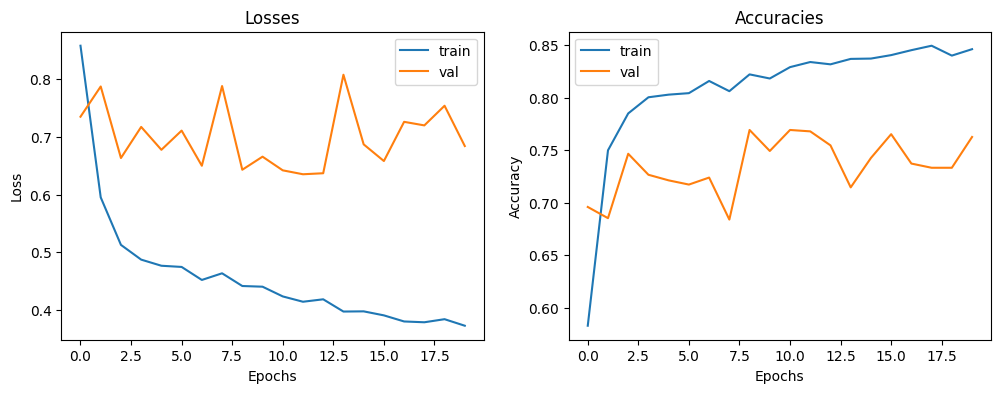

dropout rate = 0.1
Test correct = 572

Test total dataitem = 750

Test Accuracy = 0.762666642665863

              precision    recall  f1-score   support

    negative       0.78      0.80      0.79       250
     neutral       0.75      0.70      0.72       250
    positive       0.76      0.80      0.78       250

    accuracy                           0.76       750
   macro avg       0.76      0.76      0.76       750
weighted avg       0.76      0.76      0.76       750



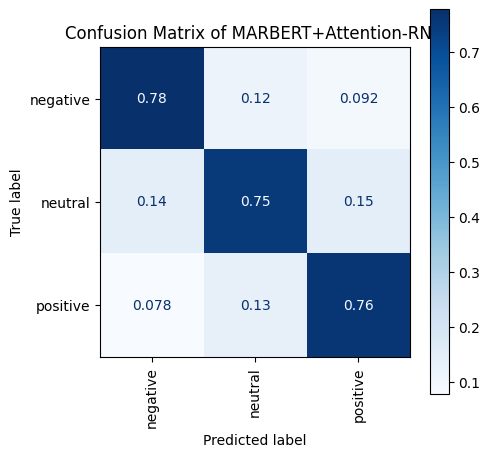

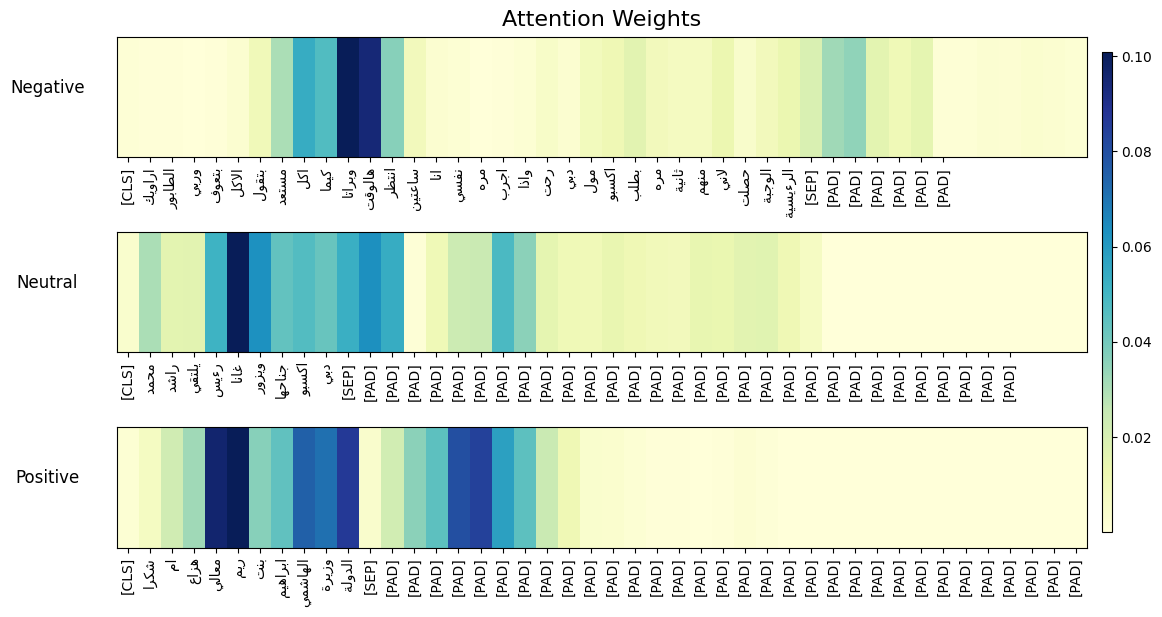

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.8698093052209915, val_loss =0.759560481484674, accuracy = 0.5794509649276733, val_accuracy = 0.690666675567627


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.5684628418179487, val_loss =0.7817852228232843, accuracy = 0.7637647390365601, val_accuracy = 0.7146666646003723


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.5342825680196303, val_loss =0.7885226984397614, accuracy = 0.7758431434631348, val_accuracy = 0.7106666564941406


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.5091164703073866, val_loss =0.7141093026500881, accuracy = 0.7924706339836121, val_accuracy = 0.7386666536331177


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.5086002888460467, val_loss =0.7202047975763929, accuracy = 0.7918431758880615, val_accuracy = 0.7426666617393494


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4744448375439793, val_loss =0.8187663353839486, accuracy = 0.8048627376556396, val_accuracy = 0.7239999771118164


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.46228000642560524, val_loss =0.9538813594377129, accuracy = 0.8109804391860962, val_accuracy = 0.6786666512489319


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4617576666132691, val_loss =0.70032007668848, accuracy = 0.8098823428153992, val_accuracy = 0.7493333220481873


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4502217510014345, val_loss =0.6781543715409946, accuracy = 0.8218039274215698, val_accuracy = 0.7666666507720947


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4493534666566768, val_loss =0.7522894325709627, accuracy = 0.8166274428367615, val_accuracy = 0.7306666374206543


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4561691159036451, val_loss =0.7338808927873591, accuracy = 0.8145882487297058, val_accuracy = 0.746666669845581


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4488872785060334, val_loss =0.716743820156959, accuracy = 0.8185098171234131, val_accuracy = 0.7360000014305115


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.44039057330969134, val_loss =0.7820732950885513, accuracy = 0.8185098171234131, val_accuracy = 0.7506666779518127


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.42651455139969235, val_loss =0.7247092366951158, accuracy = 0.8293333649635315, val_accuracy = 0.7226666808128357


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4191638670132876, val_loss =0.7092696708184412, accuracy = 0.831529438495636, val_accuracy = 0.7573333382606506


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.43398781010024484, val_loss =0.7966706738965895, accuracy = 0.8203921914100647, val_accuracy = 0.7160000205039978


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4103020444289765, val_loss =0.7387636190465341, accuracy = 0.831529438495636, val_accuracy = 0.7559999823570251


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4053983244815299, val_loss =0.6963845790127695, accuracy = 0.8393725752830505, val_accuracy = 0.7680000066757202


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4031511001925643, val_loss =0.6917819596789027, accuracy = 0.8387451171875, val_accuracy = 0.7720000147819519


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.41665898296086573, val_loss =0.7355500251331685, accuracy = 0.8330980539321899, val_accuracy = 0.7519999742507935


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


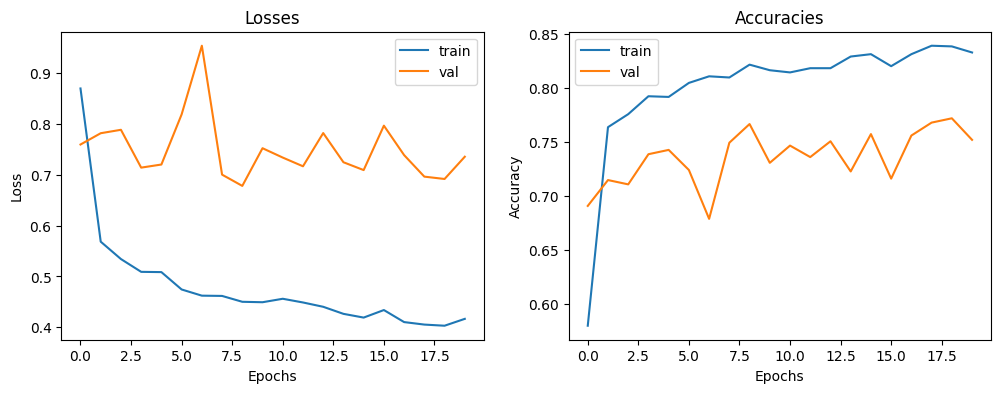

dropout rate = 0.2
Test correct = 564

Test total dataitem = 750

Test Accuracy = 0.7519999742507935

              precision    recall  f1-score   support

    negative       0.80      0.75      0.78       250
     neutral       0.68      0.76      0.72       250
    positive       0.78      0.74      0.76       250

    accuracy                           0.75       750
   macro avg       0.76      0.75      0.75       750
weighted avg       0.76      0.75      0.75       750



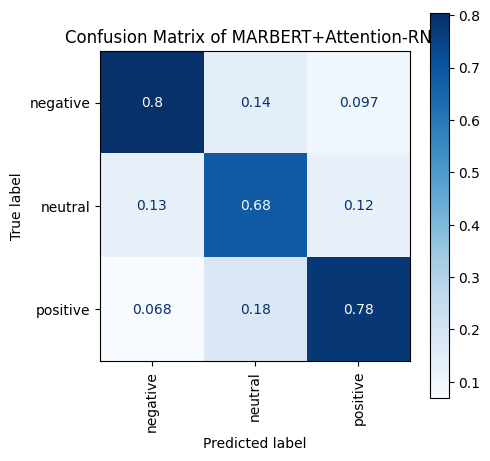

<ipython-input-16-3adf064bf7de>:36: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


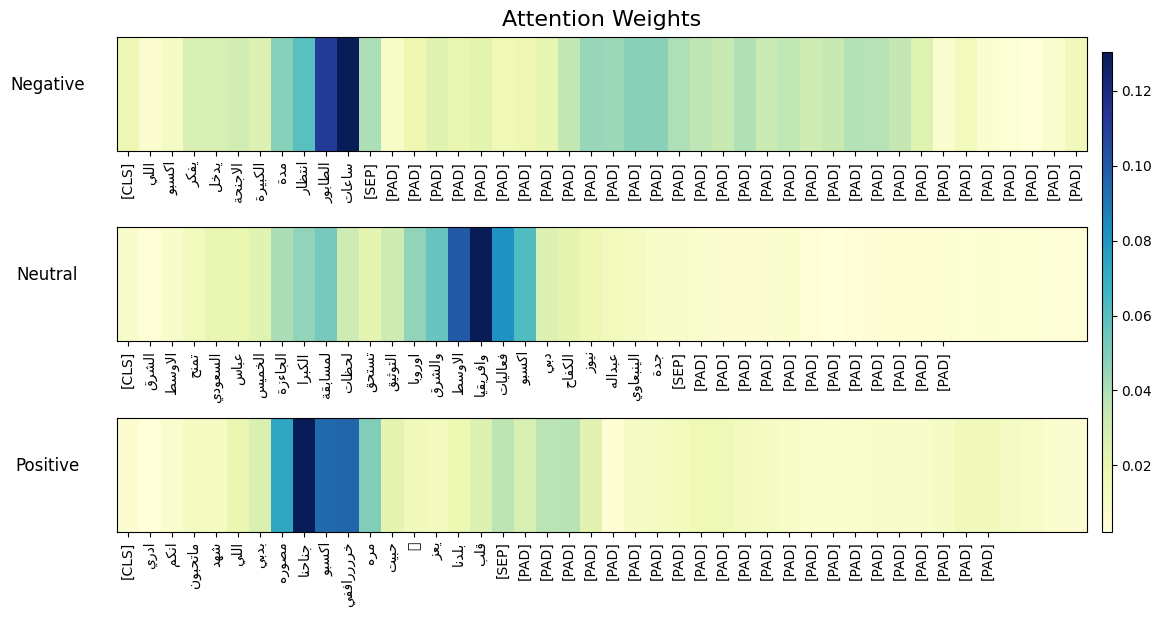

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 0.9303510499230095, val_loss =0.9169761516440422, accuracy = 0.5355294346809387, val_accuracy = 0.6306666731834412


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.6489547692935724, val_loss =0.7324108806243347, accuracy = 0.7218823432922363, val_accuracy = 0.7279999852180481


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.5538103221367298, val_loss =0.7223424985255353, accuracy = 0.7665882706642151, val_accuracy = 0.7453333139419556


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.531777101654012, val_loss =0.7547570171663461, accuracy = 0.7810196280479431, val_accuracy = 0.7453333139419556


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.505875247691479, val_loss =0.8973477436602281, accuracy = 0.7874509692192078, val_accuracy = 0.7120000123977661


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.489413899727681, val_loss =0.7826351214256898, accuracy = 0.7948235273361206, val_accuracy = 0.7479999661445618


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.47462082821737844, val_loss =0.7981136931009423, accuracy = 0.8101961016654968, val_accuracy = 0.7213333249092102


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


loss = 0.46390917805276094, val_loss =0.7967009507169118, accuracy = 0.8061176538467407, val_accuracy = 0.7253333330154419


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.4596220648023978, val_loss =0.8734671051372943, accuracy = 0.8185098171234131, val_accuracy = 0.7080000042915344


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.47035185562561077, val_loss =0.8034506862246991, accuracy = 0.8034510016441345, val_accuracy = 0.7400000095367432


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


loss = 0.4615558802036771, val_loss =0.8297859478643, accuracy = 0.808470606803894, val_accuracy = 0.6933333277702332


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


loss = 0.44735533032342806, val_loss =0.7642478425011038, accuracy = 0.8150588274002075, val_accuracy = 0.7360000014305115


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.43762467317913684, val_loss =0.7709367637668297, accuracy = 0.8222745060920715, val_accuracy = 0.7453333139419556


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.44267167877798785, val_loss =0.901204192836814, accuracy = 0.8211764693260193, val_accuracy = 0.7093333005905151


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.4376588017395951, val_loss =0.8923516463732928, accuracy = 0.820078432559967, val_accuracy = 0.7213333249092102


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4263004795755678, val_loss =0.748067867564859, accuracy = 0.8283921480178833, val_accuracy = 0.746666669845581


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.4334984601408609, val_loss =0.866567075951969, accuracy = 0.8241568803787231, val_accuracy = 0.718666672706604


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4246214601731972, val_loss =0.8267055151328528, accuracy = 0.8304314017295837, val_accuracy = 0.7226666808128357


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4159818177109581, val_loss =0.7902088367010602, accuracy = 0.8318431377410889, val_accuracy = 0.7453333139419556


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.41497887655123367, val_loss =0.836385148416842, accuracy = 0.8337255120277405, val_accuracy = 0.734666645526886


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


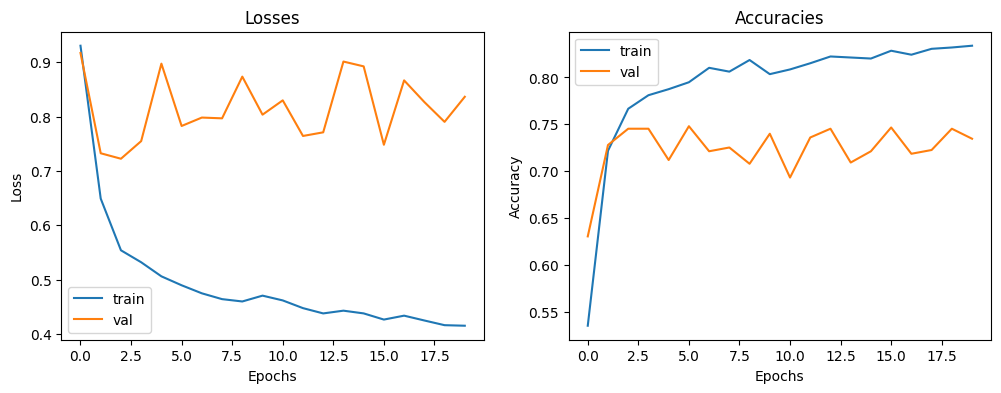

dropout rate = 0.3
Test correct = 551

Test total dataitem = 750

Test Accuracy = 0.734666645526886

              precision    recall  f1-score   support

    negative       0.79      0.72      0.75       250
     neutral       0.64      0.82      0.72       250
    positive       0.82      0.67      0.74       250

    accuracy                           0.73       750
   macro avg       0.75      0.73      0.74       750
weighted avg       0.75      0.73      0.74       750



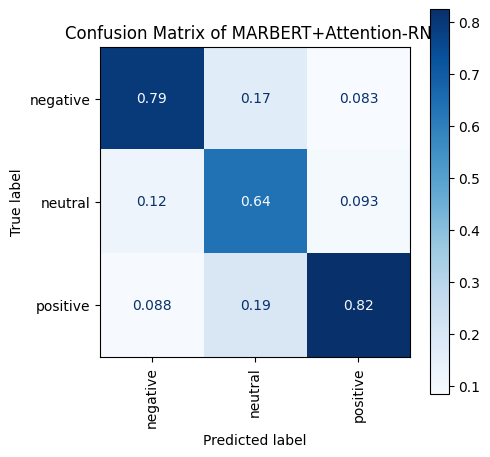

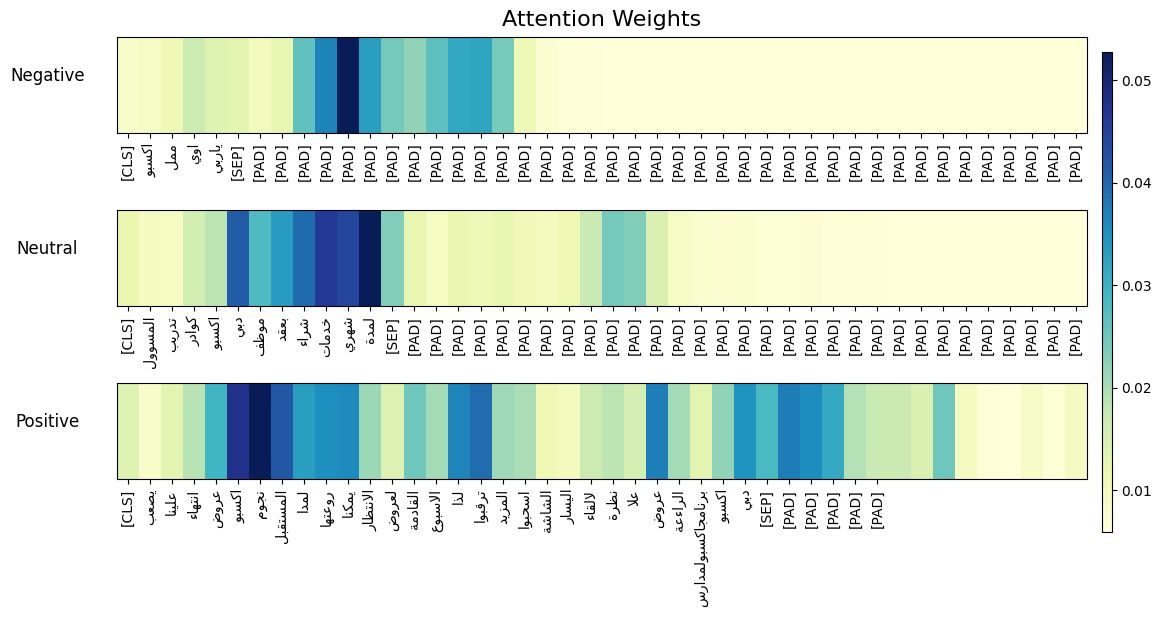

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.9267320557211031, val_loss =0.838291384277619, accuracy = 0.5408627390861511, val_accuracy = 0.6480000019073486


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.6325001776678526, val_loss =0.9590707494760178, accuracy = 0.7336470484733582, val_accuracy = 0.6653333306312561


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.5454212772285059, val_loss =1.2346586817022425, accuracy = 0.7733333706855774, val_accuracy = 0.628000020980835


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5262023130091322, val_loss =0.9495319543064173, accuracy = 0.7880784273147583, val_accuracy = 0.7226666808128357


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.5039011382735216, val_loss =1.049911641107804, accuracy = 0.7932549118995667, val_accuracy = 0.6746666431427002


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5023953463600909, val_loss =1.0294822567498818, accuracy = 0.7941960692405701, val_accuracy = 0.6733333468437195


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.49039515396416156, val_loss =1.0650232042675818, accuracy = 0.7976470589637756, val_accuracy = 0.7026666402816772


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.46737500227987816, val_loss =1.0999120066634915, accuracy = 0.8105098009109497, val_accuracy = 0.6973333358764648


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4744350201315774, val_loss =1.0076891152266332, accuracy = 0.8051764965057373, val_accuracy = 0.7093333005905151


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.472681545817431, val_loss =0.916355532538378, accuracy = 0.8092549443244934, val_accuracy = 0.7373332977294922


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.4561525843812253, val_loss =1.4474615033814402, accuracy = 0.8174117803573608, val_accuracy = 0.6546666622161865


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.45547483138733, val_loss =1.1510517203091364, accuracy = 0.8149020075798035, val_accuracy = 0.7120000123977661


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.45638720403049754, val_loss =1.231215149366055, accuracy = 0.810039222240448, val_accuracy = 0.6666666865348816


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.45053840256431826, val_loss =0.8768338189578707, accuracy = 0.8160000443458557, val_accuracy = 0.7386666536331177


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.4505240997165438, val_loss =1.1130604816937928, accuracy = 0.8166274428367615, val_accuracy = 0.6813333034515381


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.43638613094780526, val_loss =1.319408000003026, accuracy = 0.8210196495056152, val_accuracy = 0.7013333439826965


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.43591634443571725, val_loss =1.2628878701280994, accuracy = 0.8203921914100647, val_accuracy = 0.6706666350364685


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.437298330860431, val_loss =0.8393200300522503, accuracy = 0.8232157230377197, val_accuracy = 0.7639999985694885


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.44207261099730416, val_loss =0.8772585998949433, accuracy = 0.8180392384529114, val_accuracy = 0.7293333411216736


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.43348865672043885, val_loss =1.0829408123765412, accuracy = 0.831529438495636, val_accuracy = 0.7120000123977661


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


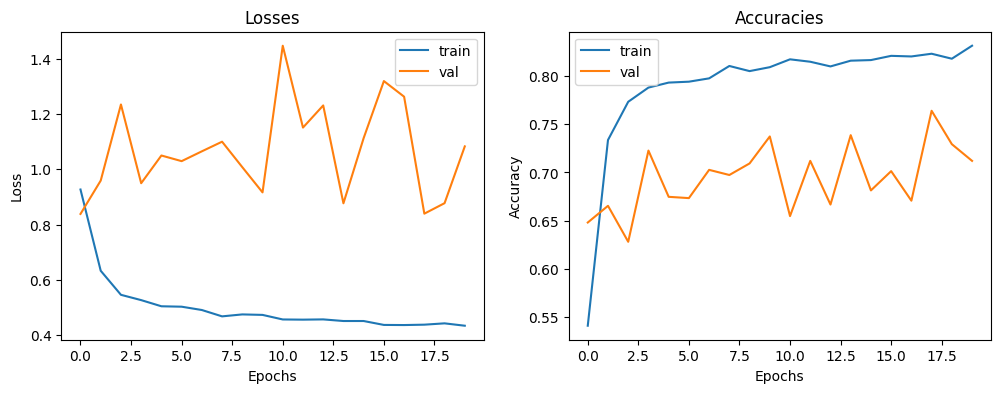

dropout rate = 0.4
Test correct = 534

Test total dataitem = 750

Test Accuracy = 0.7120000123977661

              precision    recall  f1-score   support

    negative       0.84      0.57      0.68       250
     neutral       0.65      0.80      0.72       250
    positive       0.70      0.77      0.74       250

    accuracy                           0.71       750
   macro avg       0.73      0.71      0.71       750
weighted avg       0.73      0.71      0.71       750



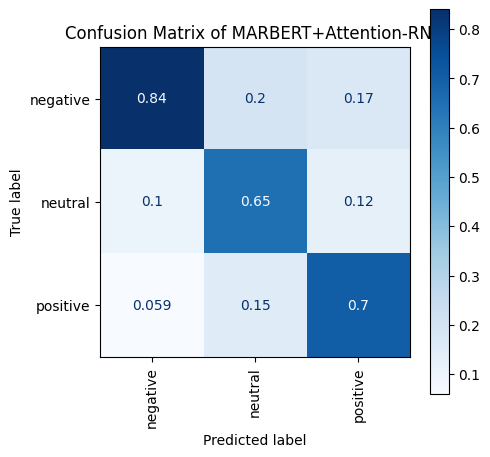

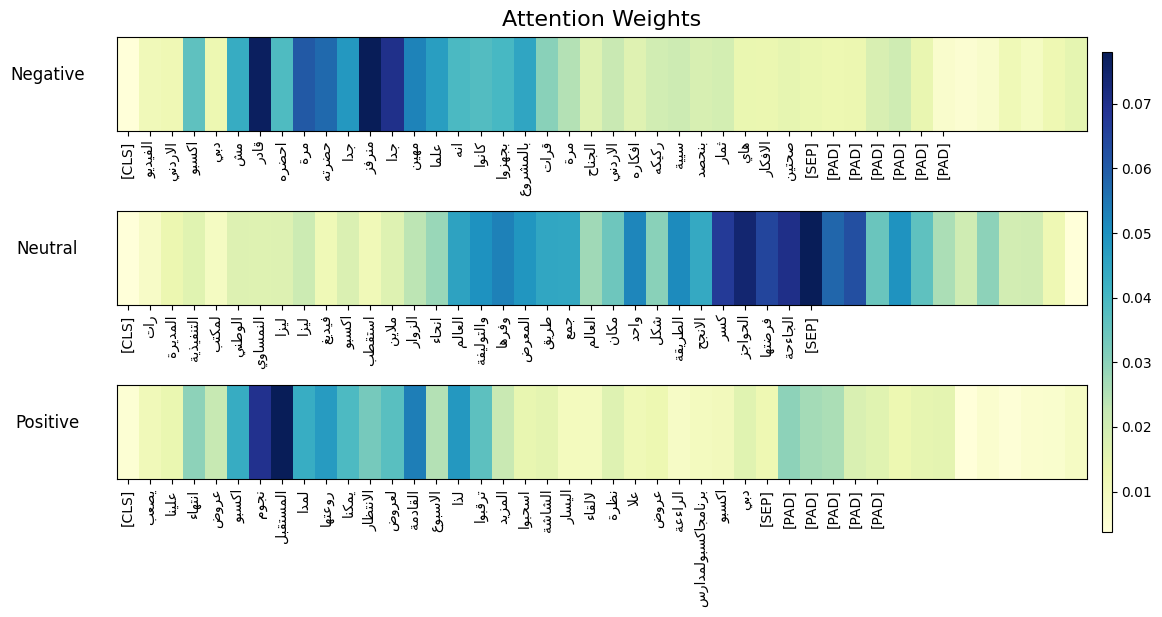

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.9781395624643967, val_loss =0.839728102695148, accuracy = 0.5038431286811829, val_accuracy = 0.653333306312561


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.6528033383110429, val_loss =0.9842736089643344, accuracy = 0.7280000448226929, val_accuracy = 0.6853333115577698


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5649832317708998, val_loss =0.967867697145925, accuracy = 0.7690980434417725, val_accuracy = 0.7146666646003723


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.5536862757222237, val_loss =0.9086512467782389, accuracy = 0.7758431434631348, val_accuracy = 0.7360000014305115


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5228504612316185, val_loss =1.0980644338101426, accuracy = 0.7866666913032532, val_accuracy = 0.7013333439826965


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5062653153518257, val_loss =0.9923268564262316, accuracy = 0.7945098280906677, val_accuracy = 0.7253333330154419


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.49549292343511603, val_loss =1.040951590347359, accuracy = 0.8017255067825317, val_accuracy = 0.7386666536331177


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.49059873859603265, val_loss =1.0801778873023713, accuracy = 0.8010980486869812, val_accuracy = 0.7239999771118164


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.492489932683109, val_loss =1.0774060831924266, accuracy = 0.7949804067611694, val_accuracy = 0.7106666564941406


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.47497182143517747, val_loss =0.9052915111667649, accuracy = 0.8039215803146362, val_accuracy = 0.7293333411216736


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.46727414869406253, val_loss =1.2263622317054161, accuracy = 0.8067451119422913, val_accuracy = 0.6759999990463257


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.464124836433918, val_loss =0.9806195765209839, accuracy = 0.8141176700592041, val_accuracy = 0.7146666646003723


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.45578140624310637, val_loss =1.0845596779730382, accuracy = 0.8103529810905457, val_accuracy = 0.6959999799728394


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.464853255512841, val_loss =0.8808944995984879, accuracy = 0.8101961016654968, val_accuracy = 0.7279999852180481


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.45761824639611276, val_loss =0.8404762730083838, accuracy = 0.8145882487297058, val_accuracy = 0.7373332977294922


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.44455612265907823, val_loss =1.0493024909726167, accuracy = 0.8203921914100647, val_accuracy = 0.6840000152587891


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.4462338417043681, val_loss =0.8720943490909386, accuracy = 0.8130196332931519, val_accuracy = 0.7146666646003723


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.44242284549775596, val_loss =0.85878666853889, accuracy = 0.8150588274002075, val_accuracy = 0.7093333005905151


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.4431465724844806, val_loss =0.9000363530768888, accuracy = 0.8108235597610474, val_accuracy = 0.7066666483879089


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4344803812563982, val_loss =0.9707717544092097, accuracy = 0.8194509744644165, val_accuracy = 0.7026666402816772


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


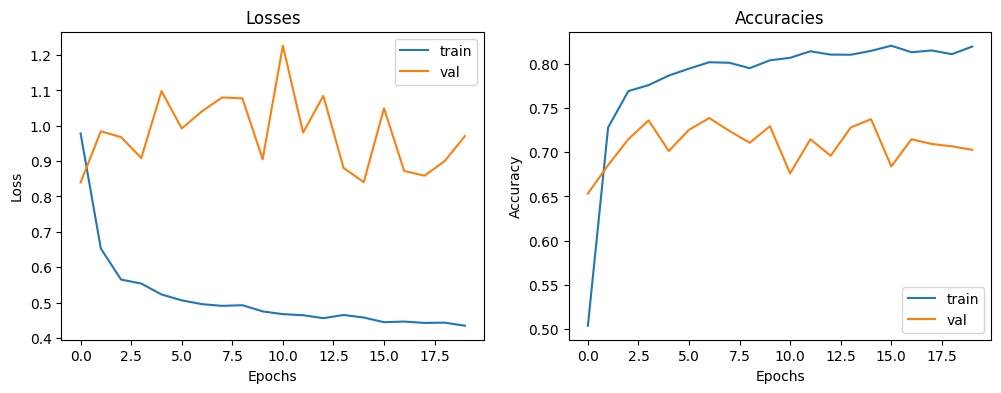

dropout rate = 0.5
Test correct = 527

Test total dataitem = 750

Test Accuracy = 0.7026666402816772

              precision    recall  f1-score   support

    negative       0.82      0.58      0.68       250
     neutral       0.65      0.72      0.69       250
    positive       0.68      0.80      0.74       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.70       750
weighted avg       0.72      0.70      0.70       750



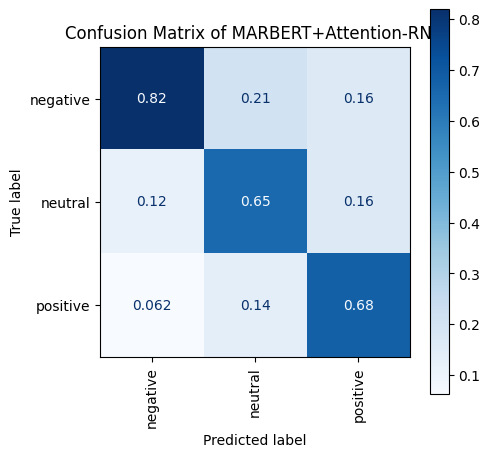

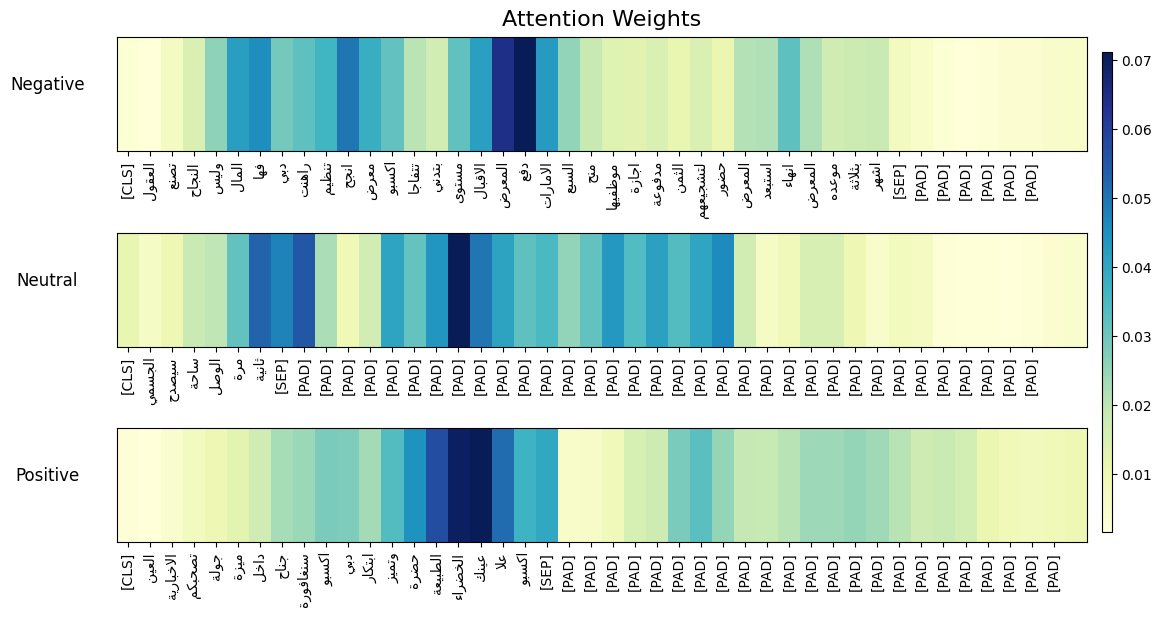

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.9645783717956062, val_loss =0.9461445035885317, accuracy = 0.5160784721374512, val_accuracy = 0.5666666626930237


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.6836974422276362, val_loss =0.8065333121228805, accuracy = 0.7003921866416931, val_accuracy = 0.7213333249092102


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.592096797039615, val_loss =0.9218195244531433, accuracy = 0.753725528717041, val_accuracy = 0.7080000042915344


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5538372215494658, val_loss =0.9556257635972213, accuracy = 0.774117648601532, val_accuracy = 0.7093333005905151


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.5436745204069314, val_loss =1.0863110138893124, accuracy = 0.7781960964202881, val_accuracy = 0.6786666512489319


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5210765085651863, val_loss =0.9431972763562478, accuracy = 0.7832157015800476, val_accuracy = 0.7373332977294922


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.505897804243838, val_loss =0.837250357222017, accuracy = 0.7918431758880615, val_accuracy = 0.7400000095367432


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5002419049680091, val_loss =0.9199811045315153, accuracy = 0.7990588545799255, val_accuracy = 0.7306666374206543


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.509953139578594, val_loss =0.8056134966239772, accuracy = 0.7904313802719116, val_accuracy = 0.7506666779518127


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.4900366640262564, val_loss =1.0150730203117926, accuracy = 0.8003137707710266, val_accuracy = 0.7319999933242798


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.4823620629430298, val_loss =1.0481941573769857, accuracy = 0.8014118075370789, val_accuracy = 0.7039999961853027


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4744749629135294, val_loss =0.9911929675211062, accuracy = 0.8106666803359985, val_accuracy = 0.7106666564941406


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4720337145193292, val_loss =0.9572760414859504, accuracy = 0.8053333759307861, val_accuracy = 0.7173333168029785


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.46796543955802944, val_loss =1.2213511214572295, accuracy = 0.8090980648994446, val_accuracy = 0.6599999666213989


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.46857434082274596, val_loss =0.8318384508622949, accuracy = 0.8081569075584412, val_accuracy = 0.7546666860580444


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4598468703621624, val_loss =1.0648789138310624, accuracy = 0.8097255229949951, val_accuracy = 0.6959999799728394


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.46624608145388213, val_loss =0.9444546277760826, accuracy = 0.811607837677002, val_accuracy = 0.7213333249092102


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.45706503538007476, val_loss =0.9796665534158161, accuracy = 0.8117647171020508, val_accuracy = 0.7293333411216736


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.47112985914803646, val_loss =0.9494567890491595, accuracy = 0.8070588707923889, val_accuracy = 0.7306666374206543


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.46673785117926814, val_loss =1.1495756299692756, accuracy = 0.8112941384315491, val_accuracy = 0.6773333549499512


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


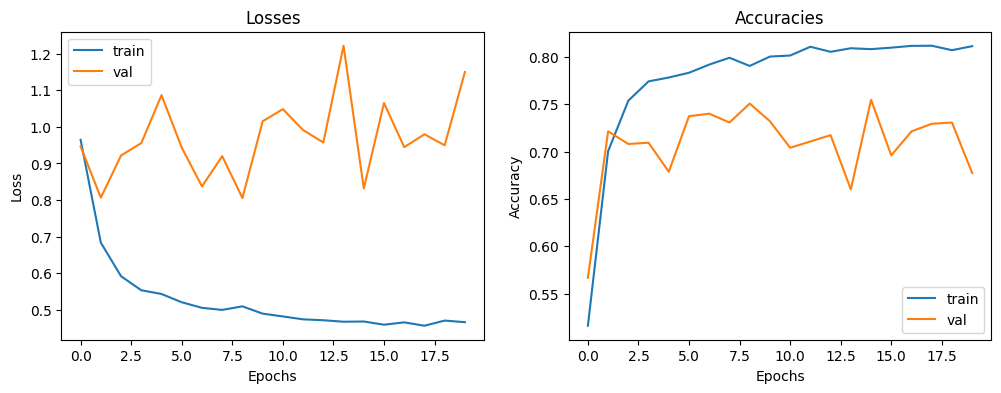

dropout rate = 0.6
Test correct = 508

Test total dataitem = 750

Test Accuracy = 0.6773333549499512

              precision    recall  f1-score   support

    negative       0.85      0.47      0.60       250
     neutral       0.60      0.86      0.70       250
    positive       0.70      0.70      0.70       250

    accuracy                           0.68       750
   macro avg       0.72      0.68      0.67       750
weighted avg       0.72      0.68      0.67       750



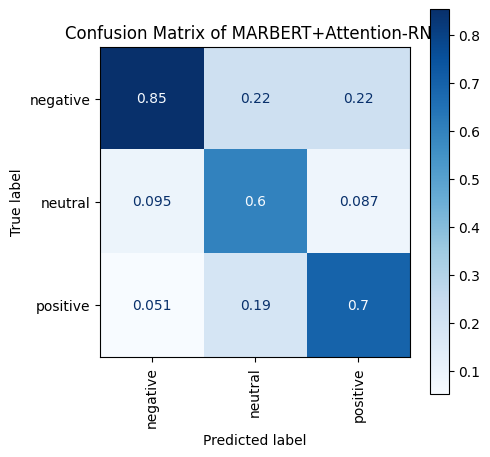

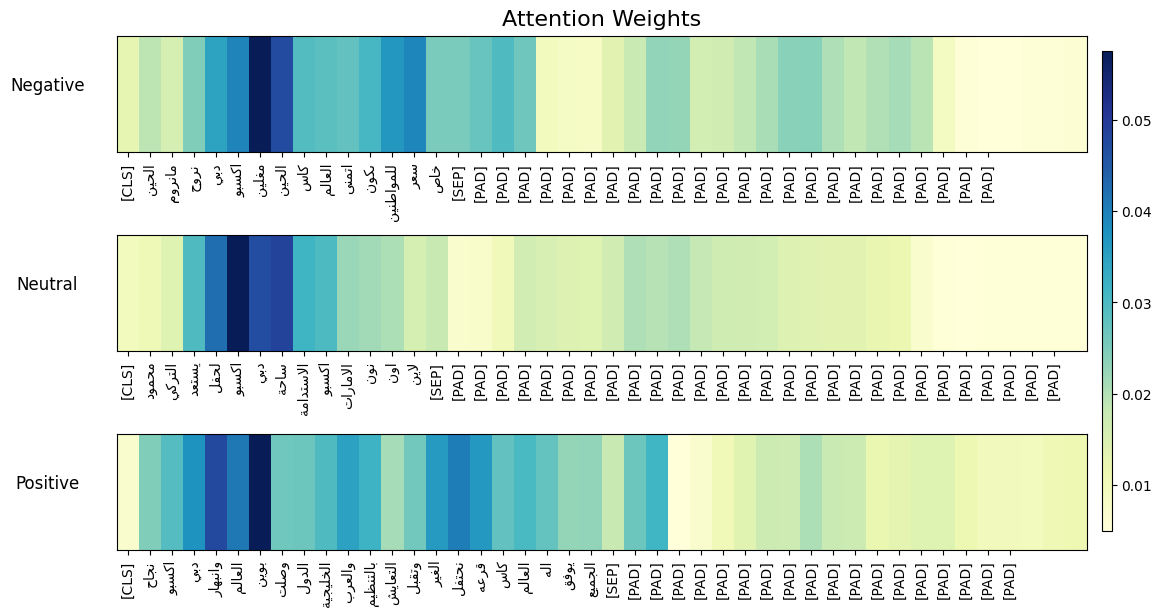

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=256
learning_rate=0.0003
drop_rates=[0,0.1,0.2,0.3,0.4,0.5,0.6]
for drop_rate in drop_rates:
  model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,drop_rate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
  print(f'dropout rate = {drop_rate}')
  test_and_report(model,test_loader,model_name,attention_added=True)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.8860620930803139, val_loss =0.8643868550585677, accuracy = 0.5604705810546875, val_accuracy = 0.6386666893959045


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.6050327262589081, val_loss =0.8247248526794189, accuracy = 0.7370980381965637, val_accuracy = 0.6933333277702332


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


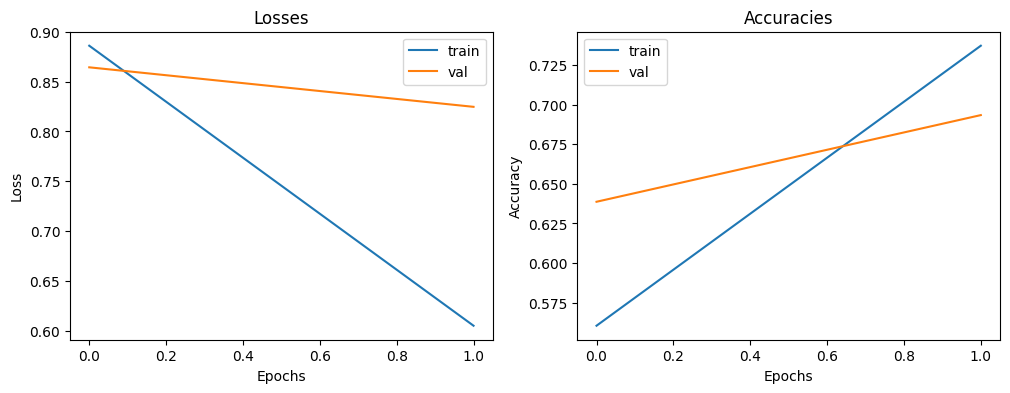

epoch = 2
Test correct = 520

Test total dataitem = 750

Test Accuracy = 0.6933333277702332

              precision    recall  f1-score   support

    negative       0.80      0.64      0.71       250
     neutral       0.68      0.69      0.69       250
    positive       0.63      0.75      0.68       250

    accuracy                           0.69       750
   macro avg       0.70      0.69      0.69       750
weighted avg       0.70      0.69      0.69       750



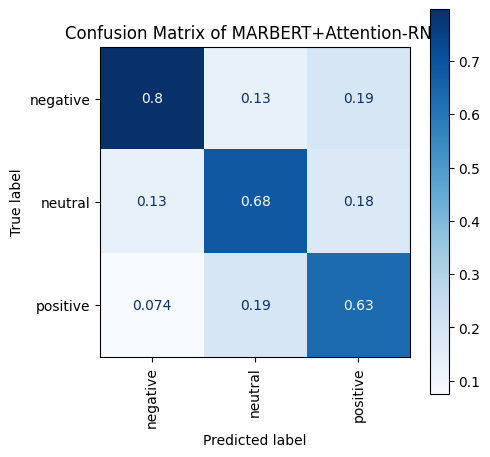

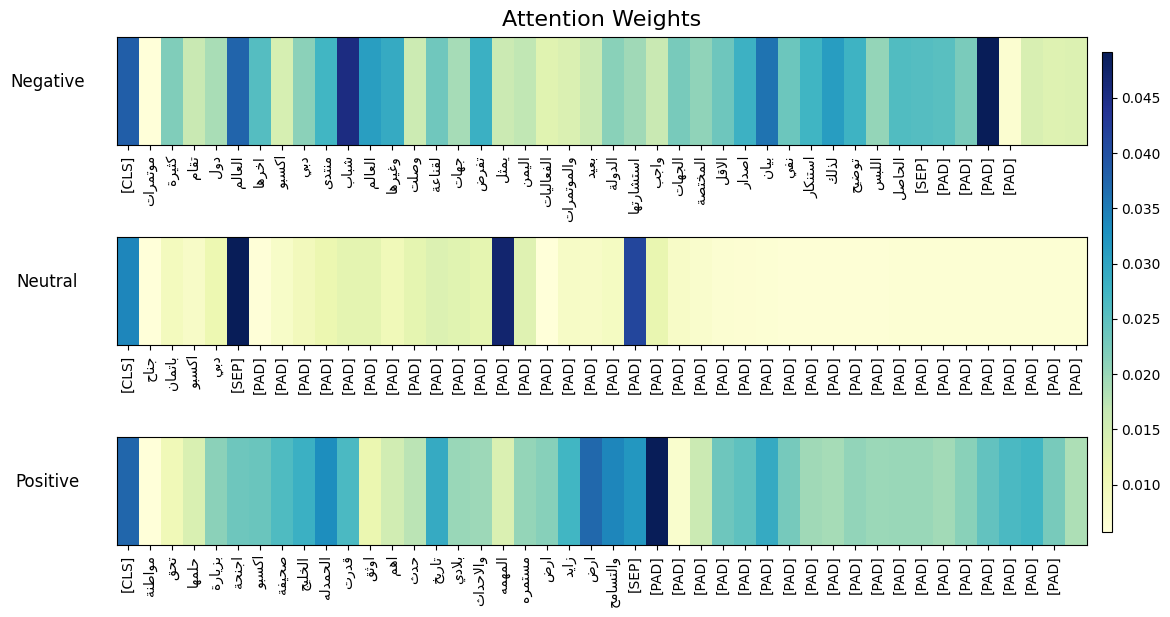

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


loss = 0.8410291483170108, val_loss =1.0565853005208066, accuracy = 0.5927843451499939, val_accuracy = 0.6013333201408386


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.5652462918763326, val_loss =0.8977069102170323, accuracy = 0.75811767578125, val_accuracy = 0.6759999990463257


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.5346405734300675, val_loss =0.6877278694872971, accuracy = 0.7796078324317932, val_accuracy = 0.7573333382606506


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5110774065869191, val_loss =0.7646958515083827, accuracy = 0.7894902229309082, val_accuracy = 0.7133333086967468


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


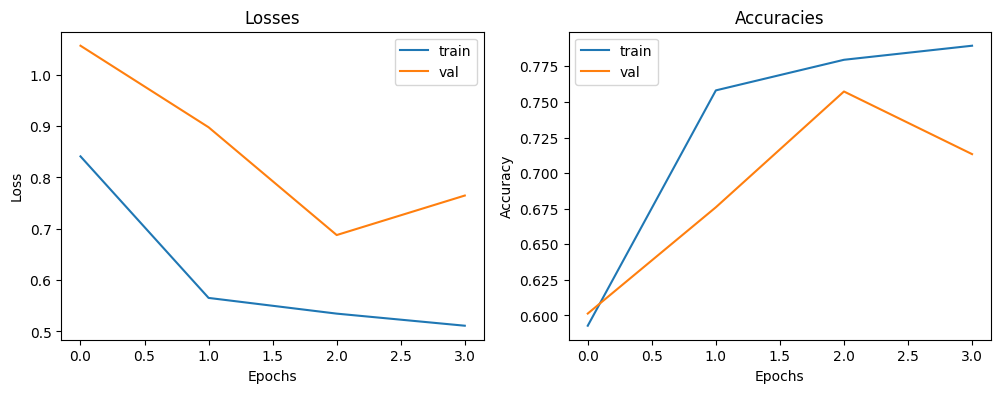

epoch = 4
Test correct = 535

Test total dataitem = 750

Test Accuracy = 0.7133333086967468

              precision    recall  f1-score   support

    negative       0.83      0.59      0.69       250
     neutral       0.61      0.85      0.71       250
    positive       0.79      0.70      0.74       250

    accuracy                           0.71       750
   macro avg       0.74      0.71      0.71       750
weighted avg       0.74      0.71      0.71       750



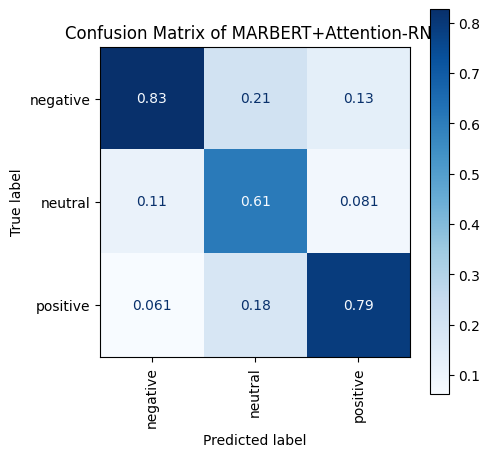

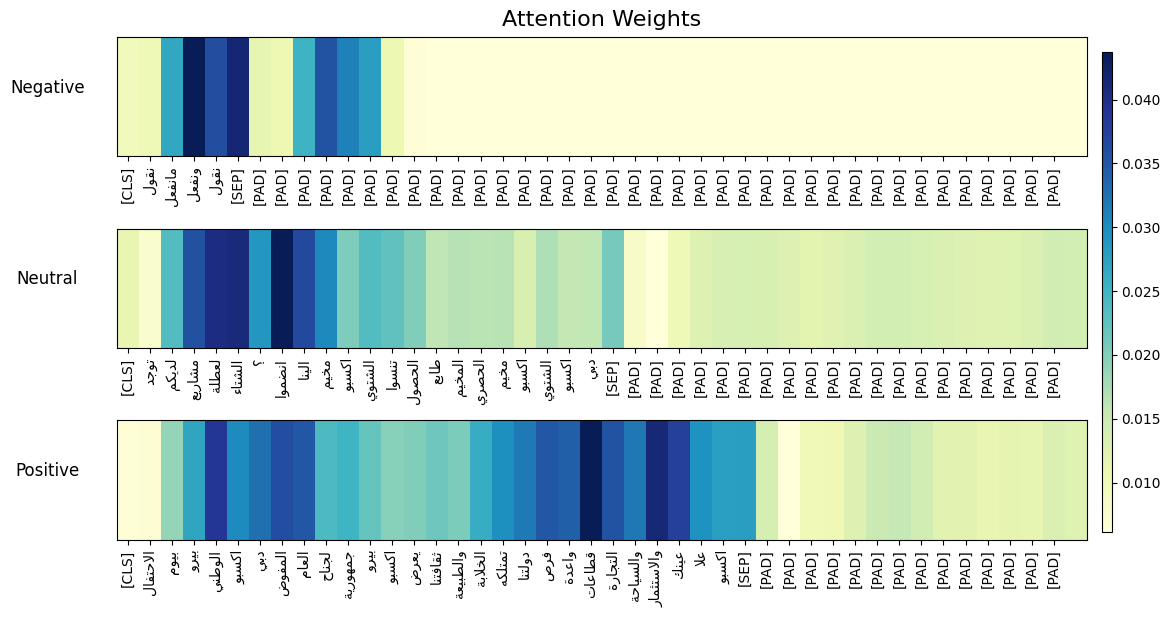

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 0.8887942358461816, val_loss =0.8476937370414026, accuracy = 0.5637646913528442, val_accuracy = 0.6266666650772095


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.6089862962994755, val_loss =0.7793745113189999, accuracy = 0.7407059073448181, val_accuracy = 0.7066666483879089


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5413738444233064, val_loss =0.7904882720349765, accuracy = 0.7730196118354797, val_accuracy = 0.7039999961853027


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


loss = 0.5131911541933237, val_loss =0.8398572190695447, accuracy = 0.7890196442604065, val_accuracy = 0.6786666512489319


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.48782465713683143, val_loss =0.7871275344563058, accuracy = 0.7959215641021729, val_accuracy = 0.7160000205039978


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


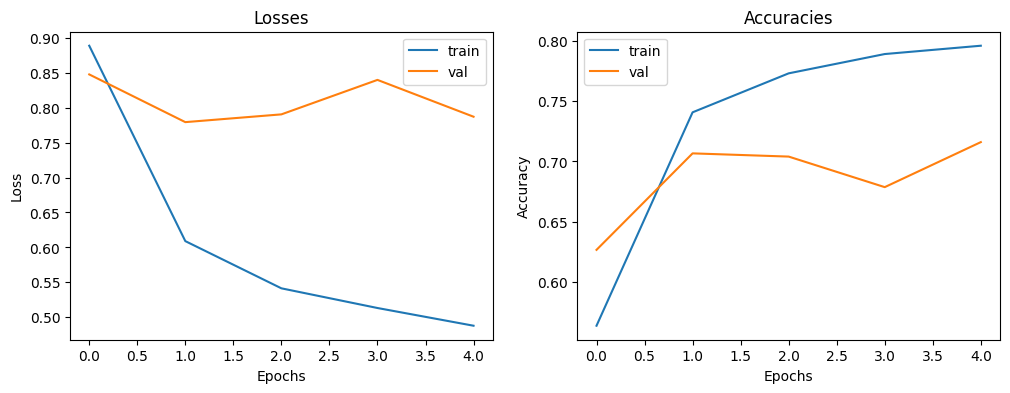

epoch = 5
Test correct = 537

Test total dataitem = 750

Test Accuracy = 0.7160000205039978

              precision    recall  f1-score   support

    negative       0.82      0.62      0.70       250
     neutral       0.67      0.77      0.71       250
    positive       0.70      0.76      0.73       250

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



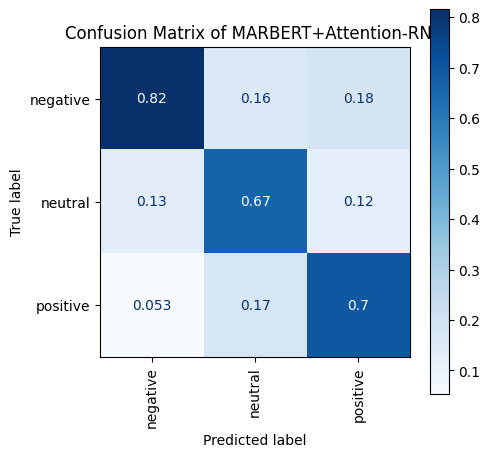

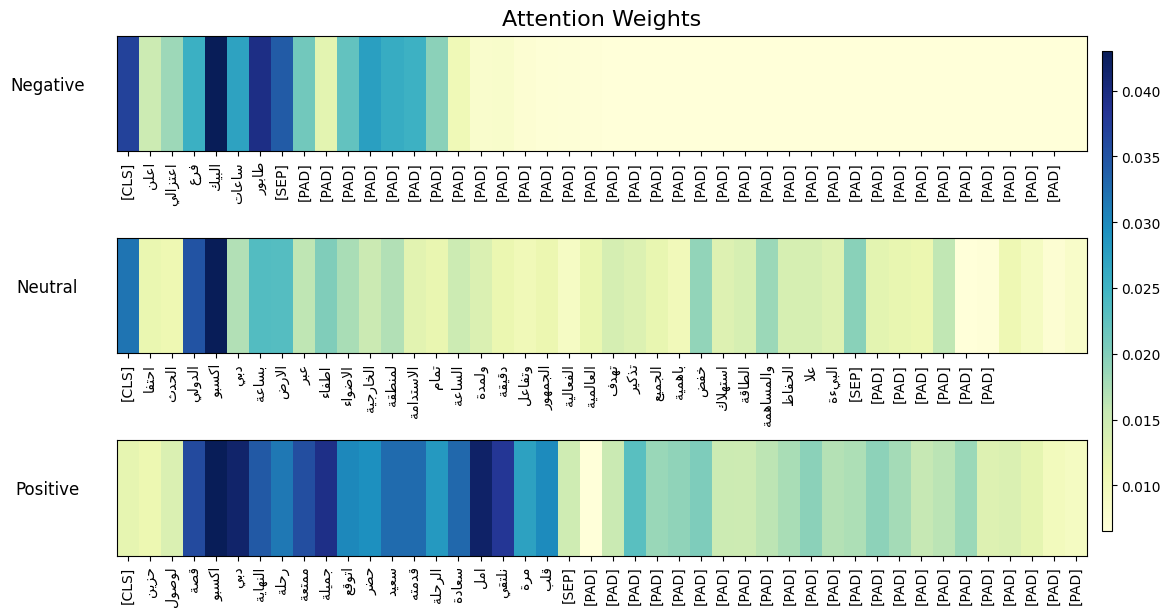

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


loss = 0.8632359504759854, val_loss =0.8649623055098346, accuracy = 0.5822744965553284, val_accuracy = 0.6213333010673523


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


loss = 0.5784496838934324, val_loss =0.7591144326615904, accuracy = 0.7631372809410095, val_accuracy = 0.7080000042915344


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


loss = 0.5323681562768112, val_loss =0.9101209677820683, accuracy = 0.7825882434844971, val_accuracy = 0.6453333497047424


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


loss = 0.5204753541202883, val_loss =0.8074850952502, accuracy = 0.7872941493988037, val_accuracy = 0.6933333277702332


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


loss = 0.49815245818858295, val_loss =0.7004648256443561, accuracy = 0.7979608178138733, val_accuracy = 0.7293333411216736


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4827723851315703, val_loss =0.8709319268996097, accuracy = 0.8010980486869812, val_accuracy = 0.7039999961853027


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


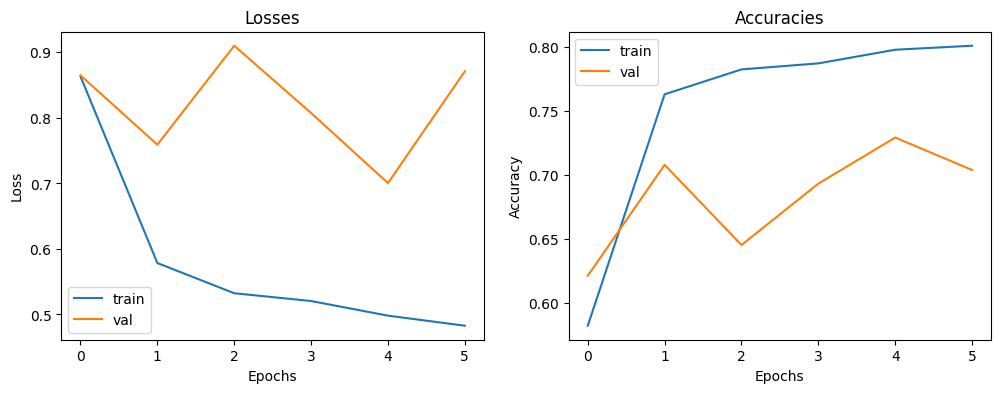

epoch = 6
Test correct = 528

Test total dataitem = 750

Test Accuracy = 0.7039999961853027

              precision    recall  f1-score   support

    negative       0.81      0.60      0.69       250
     neutral       0.62      0.82      0.71       250
    positive       0.74      0.70      0.72       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.70       750
weighted avg       0.72      0.70      0.70       750



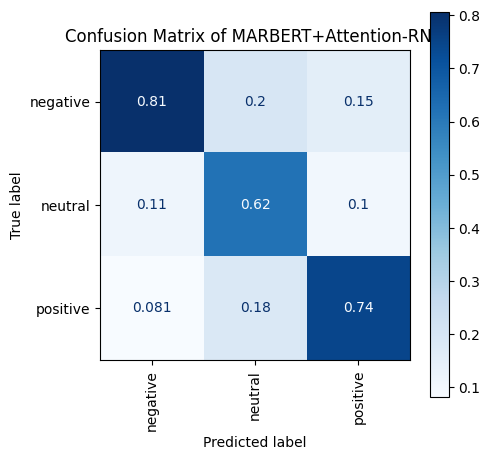

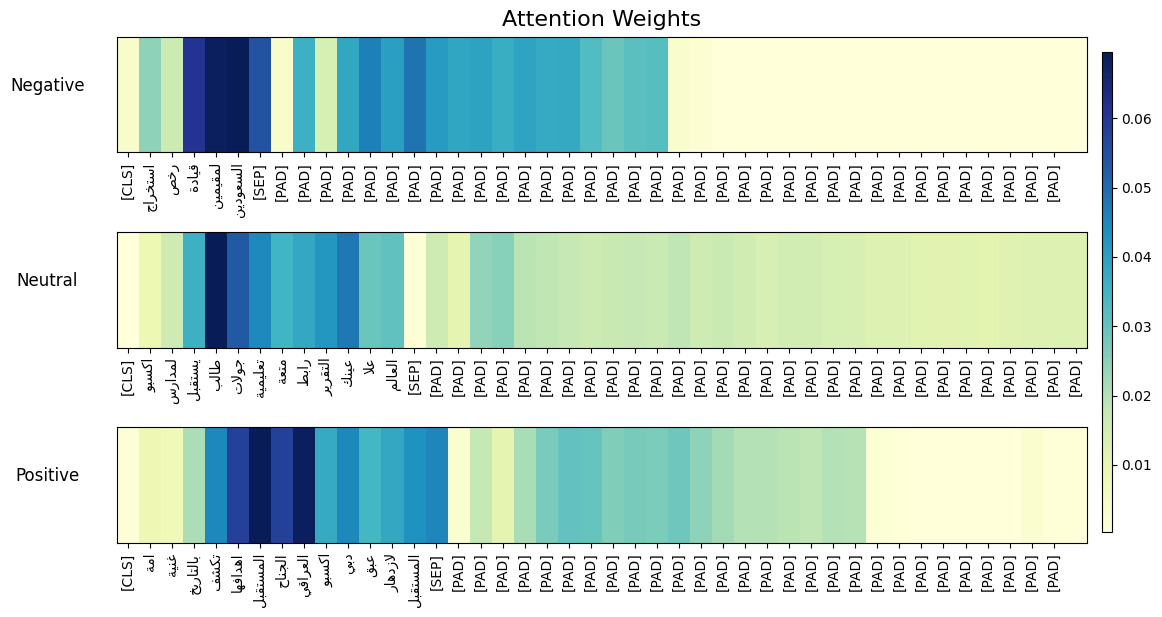

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


loss = 0.8944879715867752, val_loss =0.7577505150583802, accuracy = 0.5625098347663879, val_accuracy = 0.7093333005905151


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.6050311501618313, val_loss =0.8203690748801898, accuracy = 0.7468235492706299, val_accuracy = 0.6786666512489319


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.550797948469947, val_loss =0.900520277087233, accuracy = 0.7736470699310303, val_accuracy = 0.6746666431427002


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5159731315427687, val_loss =0.7380733131185084, accuracy = 0.7904313802719116, val_accuracy = 0.7413333058357239


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.49947569378609047, val_loss =1.1868052449404864, accuracy = 0.798431396484375, val_accuracy = 0.6159999966621399


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4866013500830311, val_loss =0.7938484278765432, accuracy = 0.8017255067825317, val_accuracy = 0.7093333005905151


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.4808495754642765, val_loss =0.8624247510753934, accuracy = 0.8018823862075806, val_accuracy = 0.6800000071525574


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


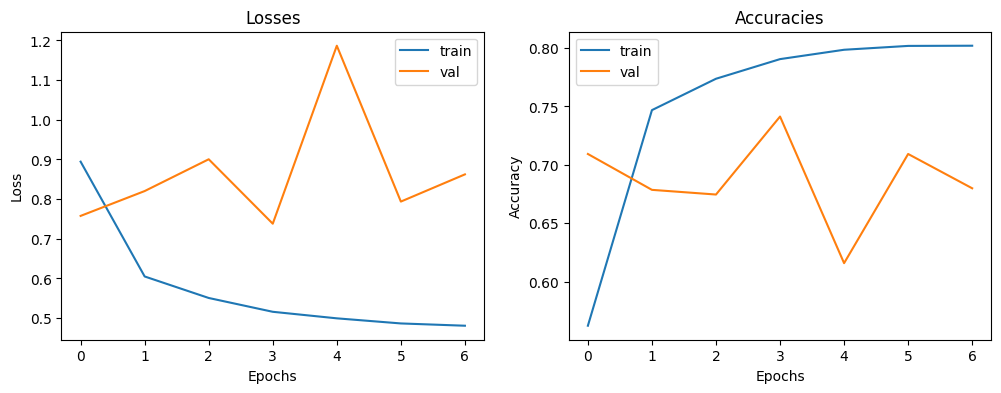

epoch = 7
Test correct = 510

Test total dataitem = 750

Test Accuracy = 0.6800000071525574

              precision    recall  f1-score   support

    negative       0.79      0.66      0.72       250
     neutral       0.55      0.87      0.68       250
    positive       0.87      0.50      0.64       250

    accuracy                           0.68       750
   macro avg       0.74      0.68      0.68       750
weighted avg       0.74      0.68      0.68       750



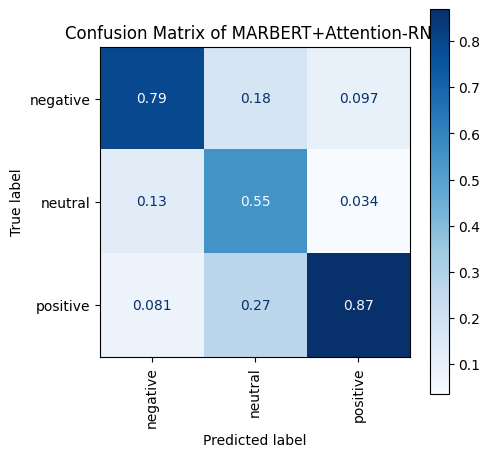

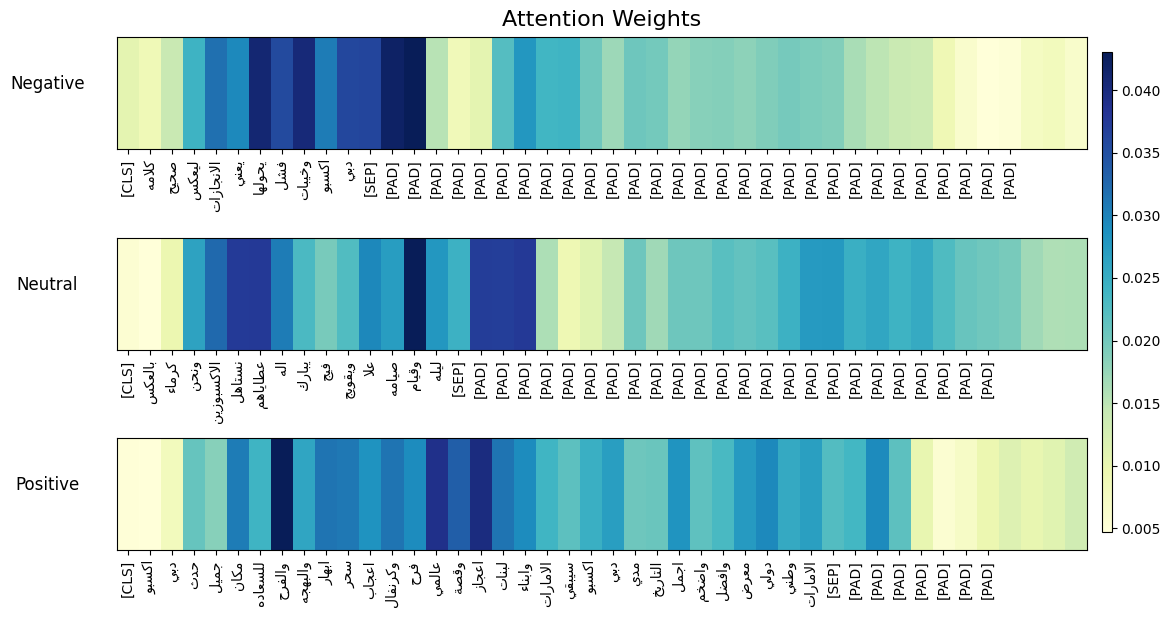

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.8845952041703352, val_loss =0.7966539065570902, accuracy = 0.5596863031387329, val_accuracy = 0.690666675567627


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.5899935021471454, val_loss =0.7402239697988514, accuracy = 0.7483921647071838, val_accuracy = 0.7306666374206543


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.5407685174542889, val_loss =0.7674647110213919, accuracy = 0.7763137221336365, val_accuracy = 0.7266666293144226


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.511050690198444, val_loss =0.8029870752567492, accuracy = 0.7876078486442566, val_accuracy = 0.6986666321754456


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.490999747604983, val_loss =0.7458694137785905, accuracy = 0.7960784435272217, val_accuracy = 0.7279999852180481


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.47114010103502246, val_loss =0.99164475721608, accuracy = 0.8073725700378418, val_accuracy = 0.6426666378974915


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4655285808653566, val_loss =0.7824053720679212, accuracy = 0.8073725700378418, val_accuracy = 0.7426666617393494


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.46473352743390883, val_loss =0.8406640801101499, accuracy = 0.810039222240448, val_accuracy = 0.6853333115577698


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


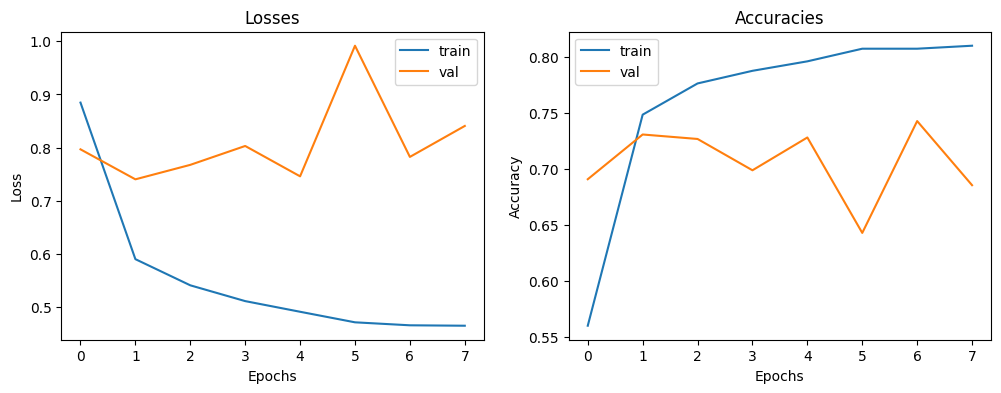

epoch = 8
Test correct = 514

Test total dataitem = 750

Test Accuracy = 0.6853333115577698

              precision    recall  f1-score   support

    negative       0.80      0.58      0.67       250
     neutral       0.56      0.86      0.68       250
    positive       0.83      0.61      0.70       250

    accuracy                           0.69       750
   macro avg       0.73      0.69      0.69       750
weighted avg       0.73      0.69      0.69       750



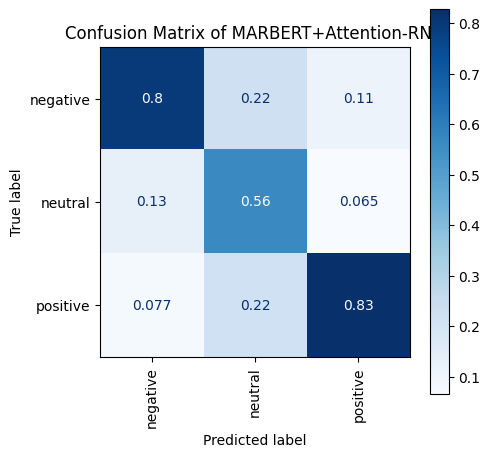

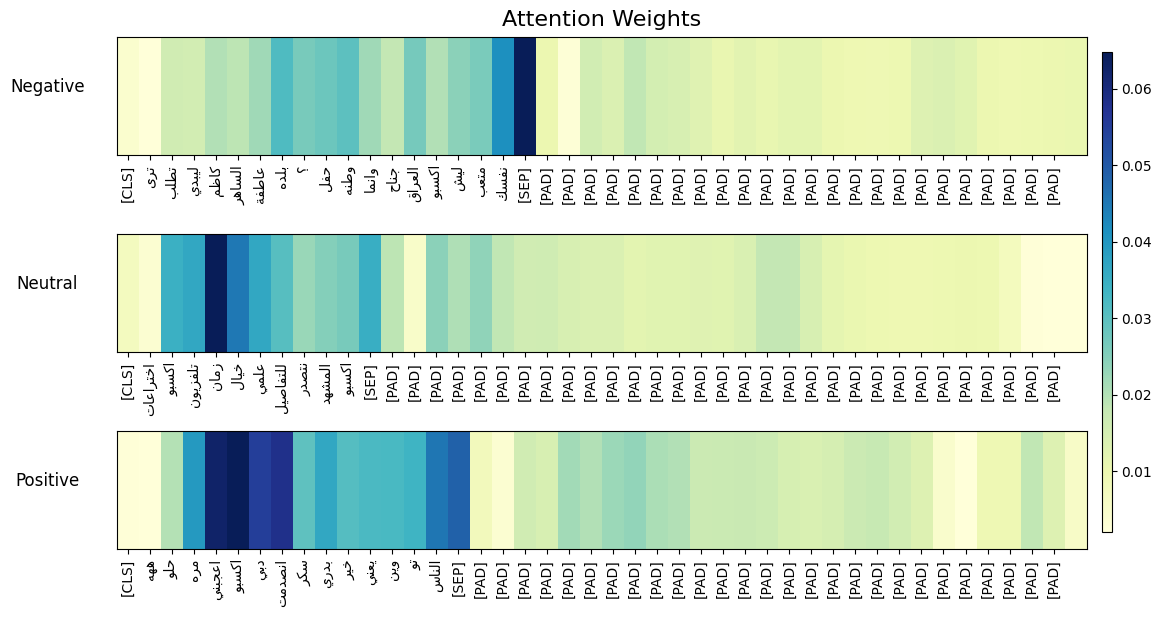

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


loss = 0.8557854095055164, val_loss =0.8551022302303665, accuracy = 0.5832157135009766, val_accuracy = 0.6946666836738586


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.594881880784673, val_loss =1.0313252350116944, accuracy = 0.7498039603233337, val_accuracy = 0.6413333415985107


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5465182300170907, val_loss =1.0793342685407972, accuracy = 0.7703529596328735, val_accuracy = 0.6706666350364685


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5149700276574208, val_loss =0.7400101246413228, accuracy = 0.7877647280693054, val_accuracy = 0.7586666345596313


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.503999421359441, val_loss =0.8385506559779179, accuracy = 0.7891764640808105, val_accuracy = 0.7133333086967468


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.49060357392556214, val_loss =0.9991619984940647, accuracy = 0.7938823699951172, val_accuracy = 0.6746666431427002


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.49226333930616817, val_loss =0.8066694487711636, accuracy = 0.7970196008682251, val_accuracy = 0.7226666808128357


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.4798351797972189, val_loss =0.7426601410252128, accuracy = 0.7987450957298279, val_accuracy = 0.718666672706604


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.46812432269805726, val_loss =0.8830896388549857, accuracy = 0.8081569075584412, val_accuracy = 0.6826666593551636


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4515229667319074, val_loss =1.0432368933941103, accuracy = 0.8136470913887024, val_accuracy = 0.6746666431427002


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


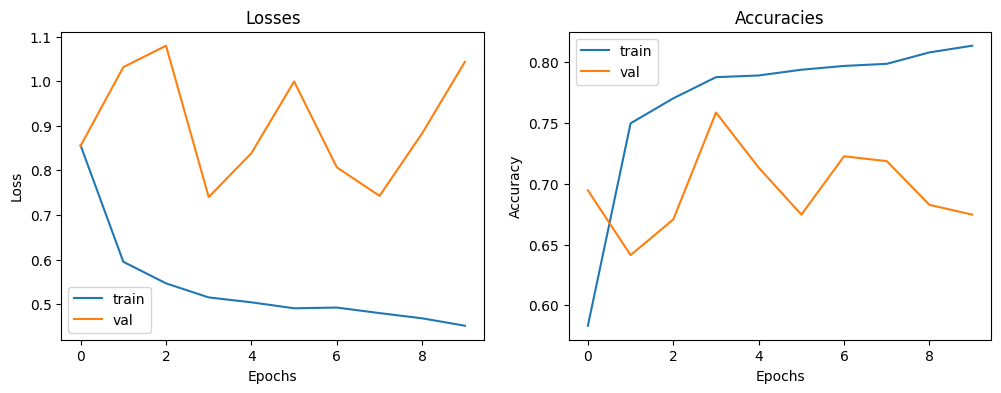

epoch = 10
Test correct = 506

Test total dataitem = 750

Test Accuracy = 0.6746666431427002

              precision    recall  f1-score   support

    negative       0.86      0.43      0.57       250
     neutral       0.60      0.84      0.70       250
    positive       0.69      0.76      0.72       250

    accuracy                           0.67       750
   macro avg       0.72      0.67      0.66       750
weighted avg       0.72      0.67      0.66       750



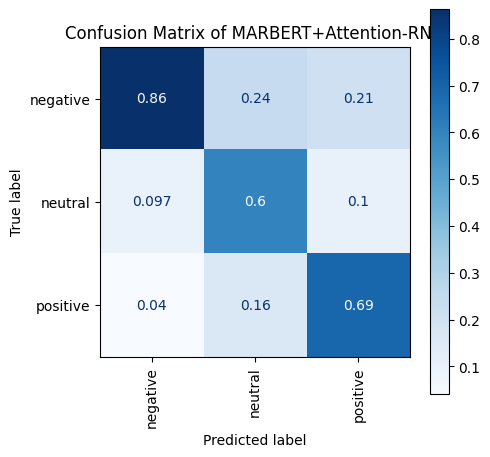

<ipython-input-16-3adf064bf7de>:36: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


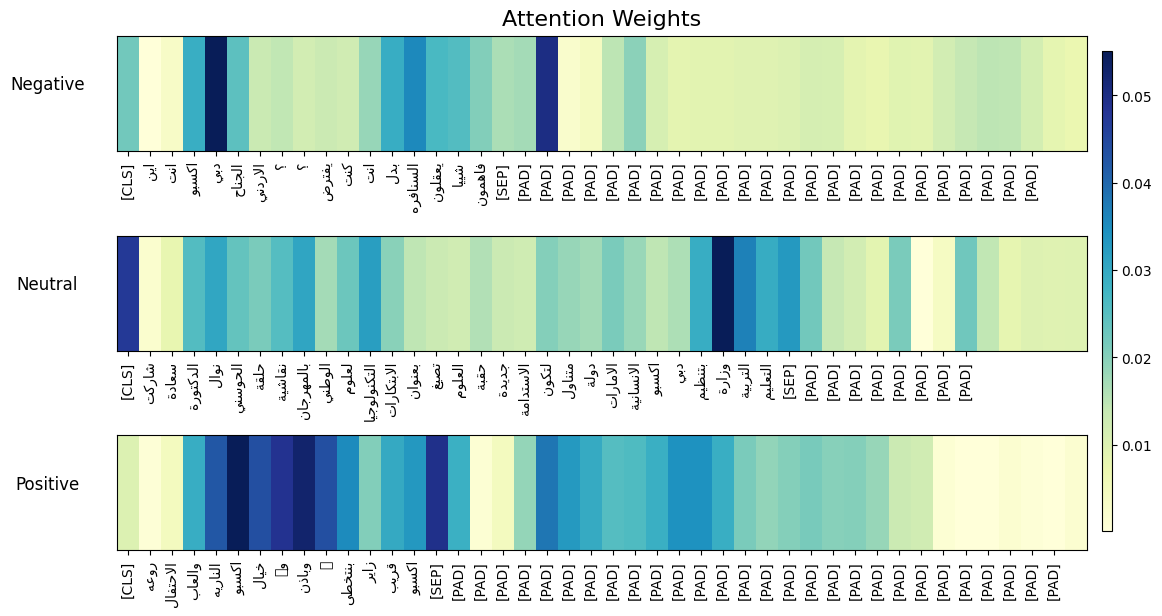

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


loss = 0.8963775335700483, val_loss =0.8648453288010586, accuracy = 0.5658039450645447, val_accuracy = 0.637333333492279


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.6192622040825237, val_loss =0.858970496847336, accuracy = 0.7364705801010132, val_accuracy = 0.6506666541099548


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.5398921005475038, val_loss =0.7332194472126475, accuracy = 0.7738039493560791, val_accuracy = 0.7080000042915344


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5090665304762279, val_loss =0.7215226783372719, accuracy = 0.7887058854103088, val_accuracy = 0.7413333058357239


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.5193428575805471, val_loss =0.7296279847850057, accuracy = 0.7788235545158386, val_accuracy = 0.7386666536331177


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.47045346182825454, val_loss =0.9928084150421151, accuracy = 0.8064314126968384, val_accuracy = 0.6746666431427002


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.4657324736020737, val_loss =0.8548256673234853, accuracy = 0.8069019913673401, val_accuracy = 0.6959999799728394


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.45410778591150236, val_loss =1.0093040271445597, accuracy = 0.8177254796028137, val_accuracy = 0.6666666865348816


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4586474100695579, val_loss =0.8790376056053802, accuracy = 0.8136470913887024, val_accuracy = 0.6679999828338623


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4515419362053744, val_loss =0.8968510958940527, accuracy = 0.8166274428367615, val_accuracy = 0.6573333144187927


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.4456313323016289, val_loss =1.1327172467515538, accuracy = 0.8224313855171204, val_accuracy = 0.6693333387374878


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.43960900439799794, val_loss =0.7339469913811287, accuracy = 0.8181961178779602, val_accuracy = 0.7400000095367432


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


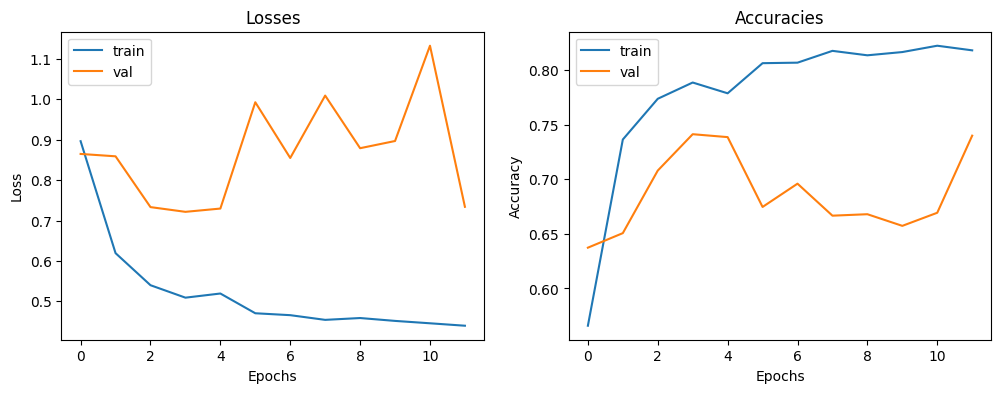

epoch = 12
Test correct = 555

Test total dataitem = 750

Test Accuracy = 0.7400000095367432

              precision    recall  f1-score   support

    negative       0.83      0.69      0.75       250
     neutral       0.64      0.80      0.72       250
    positive       0.79      0.73      0.76       250

    accuracy                           0.74       750
   macro avg       0.75      0.74      0.74       750
weighted avg       0.75      0.74      0.74       750



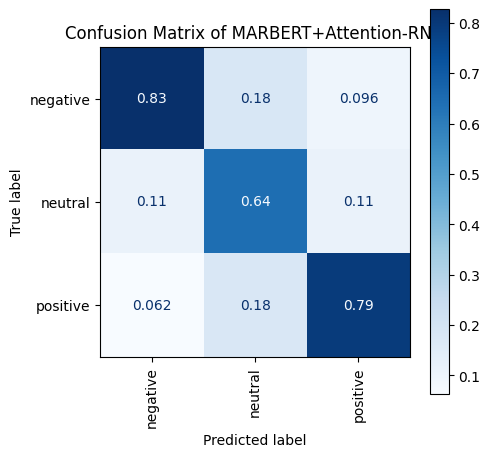

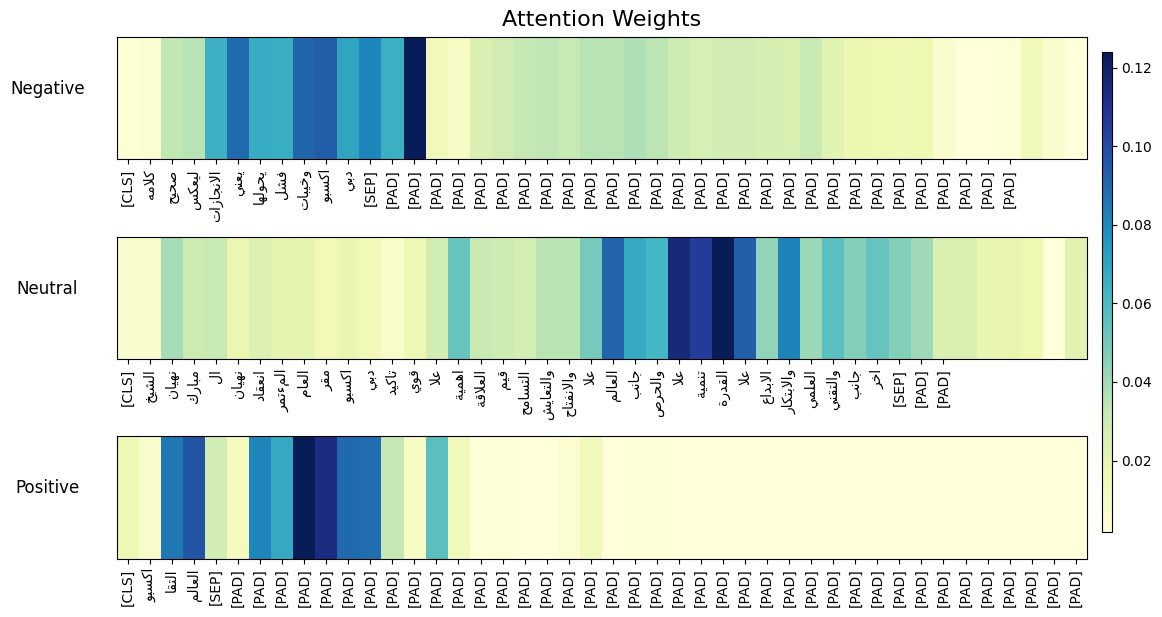

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


loss = 0.9033524853382289, val_loss =1.0443359946471849, accuracy = 0.5468235611915588, val_accuracy = 0.5253333449363708


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.6040883451235837, val_loss =0.8235389379991355, accuracy = 0.7430588603019714, val_accuracy = 0.6826666593551636


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.5277440594779107, val_loss =0.7482173058808811, accuracy = 0.7794510126113892, val_accuracy = 0.7440000176429749


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.5103090728185121, val_loss =0.7806631765214517, accuracy = 0.7898039221763611, val_accuracy = 0.7013333439826965


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.4963577105747185, val_loss =0.6926758106747134, accuracy = 0.7962353229522705, val_accuracy = 0.746666669845581


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4789329004372918, val_loss =0.7647797982047028, accuracy = 0.8032941222190857, val_accuracy = 0.7080000042915344


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4567720207176078, val_loss =0.7680828990826384, accuracy = 0.8092549443244934, val_accuracy = 0.7146666646003723


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4585556616374211, val_loss =0.7243421610341813, accuracy = 0.8106666803359985, val_accuracy = 0.7266666293144226


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.45259696069859134, val_loss =0.7939866228843281, accuracy = 0.8155294060707092, val_accuracy = 0.7146666646003723


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.4465835824008989, val_loss =0.6969961193266024, accuracy = 0.820078432559967, val_accuracy = 0.7293333411216736


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.434628107124543, val_loss =0.773163026758407, accuracy = 0.8229019641876221, val_accuracy = 0.7066666483879089


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.4303548939511986, val_loss =0.8089058101951703, accuracy = 0.8221176862716675, val_accuracy = 0.6973333358764648


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 0.43168818293003386, val_loss =0.7483241032315538, accuracy = 0.8258823752403259, val_accuracy = 0.7386666536331177


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 0.4156538227832145, val_loss =0.9292535275534451, accuracy = 0.8330980539321899, val_accuracy = 0.6746666431427002


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.41462569221534346, val_loss =0.7137718374254067, accuracy = 0.8280784487724304, val_accuracy = 0.7360000014305115


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


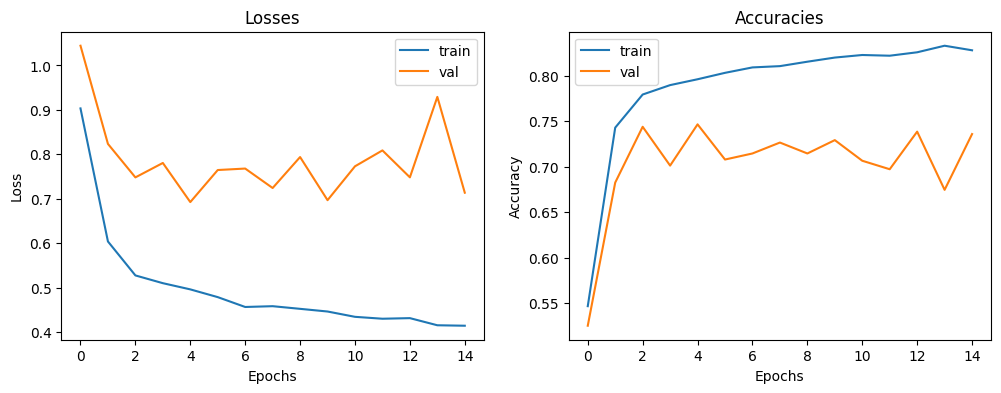

epoch = 15
Test correct = 552

Test total dataitem = 750

Test Accuracy = 0.7360000014305115

              precision    recall  f1-score   support

    negative       0.81      0.68      0.74       250
     neutral       0.67      0.78      0.72       250
    positive       0.76      0.75      0.75       250

    accuracy                           0.74       750
   macro avg       0.74      0.74      0.74       750
weighted avg       0.74      0.74      0.74       750



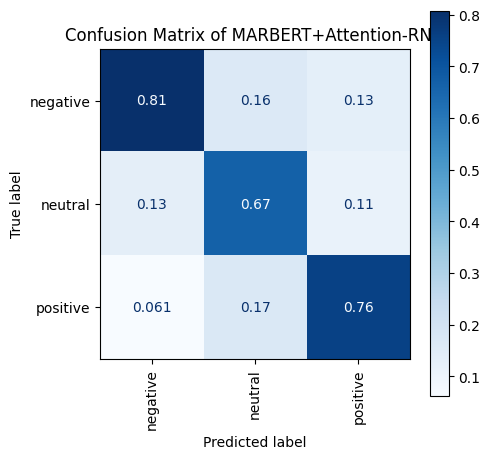

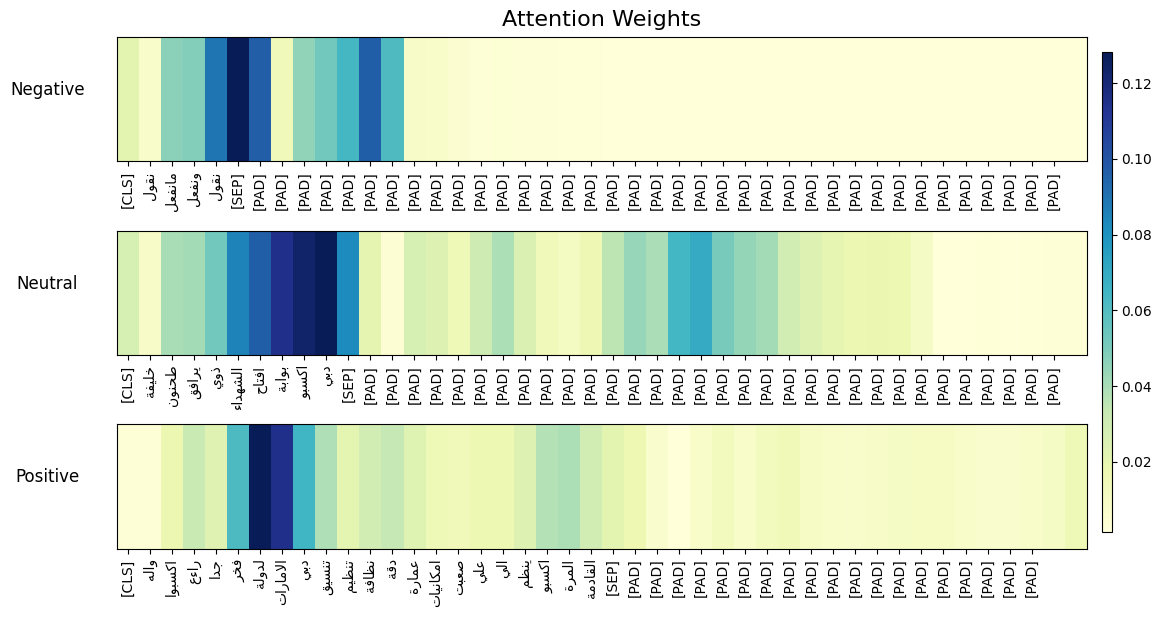

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 0.8991549143534696, val_loss =0.7976634128489937, accuracy = 0.5672156810760498, val_accuracy = 0.637333333492279


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


loss = 0.6502818516322795, val_loss =0.7413882000380618, accuracy = 0.7229803800582886, val_accuracy = 0.7039999961853027


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.5734385034530752, val_loss =0.7073973015643181, accuracy = 0.7576470971107483, val_accuracy = 0.7226666808128357


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.5454289258072934, val_loss =0.6545860501942445, accuracy = 0.7731764912605286, val_accuracy = 0.7319999933242798


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5216384200822125, val_loss =0.6788894778313646, accuracy = 0.7836862802505493, val_accuracy = 0.753333330154419


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


loss = 0.5112213431875651, val_loss =0.9005856511104496, accuracy = 0.7915294170379639, val_accuracy = 0.6853333115577698


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.49509291570743585, val_loss =0.8279135201311966, accuracy = 0.7923137545585632, val_accuracy = 0.7146666646003723


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4824018845081451, val_loss =0.7683065437116623, accuracy = 0.8004705905914307, val_accuracy = 0.7173333168029785


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.494670209256331, val_loss =0.7646035559407632, accuracy = 0.7948235273361206, val_accuracy = 0.7013333439826965


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.4637288571331693, val_loss =0.8819212244787894, accuracy = 0.805647075176239, val_accuracy = 0.6746666431427002


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4539471286175267, val_loss =0.8497196173166296, accuracy = 0.8109804391860962, val_accuracy = 0.6919999718666077


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4421860646517384, val_loss =0.8126301801437751, accuracy = 0.8158431649208069, val_accuracy = 0.7080000042915344


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.45050833461260176, val_loss =0.8617175613646256, accuracy = 0.8152157068252563, val_accuracy = 0.699999988079071


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.437041510272669, val_loss =0.8210902248621142, accuracy = 0.8191372752189636, val_accuracy = 0.7026666402816772


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.42826922657961464, val_loss =0.8156035081864027, accuracy = 0.824470579624176, val_accuracy = 0.7053333520889282


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.43551597386013996, val_loss =0.8184494089133901, accuracy = 0.8236863017082214, val_accuracy = 0.6986666321754456


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.43364445138202823, val_loss =1.1047212757330815, accuracy = 0.8274509906768799, val_accuracy = 0.6546666622161865


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.4274805232053411, val_loss =0.866724434981859, accuracy = 0.8241568803787231, val_accuracy = 0.6826666593551636


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


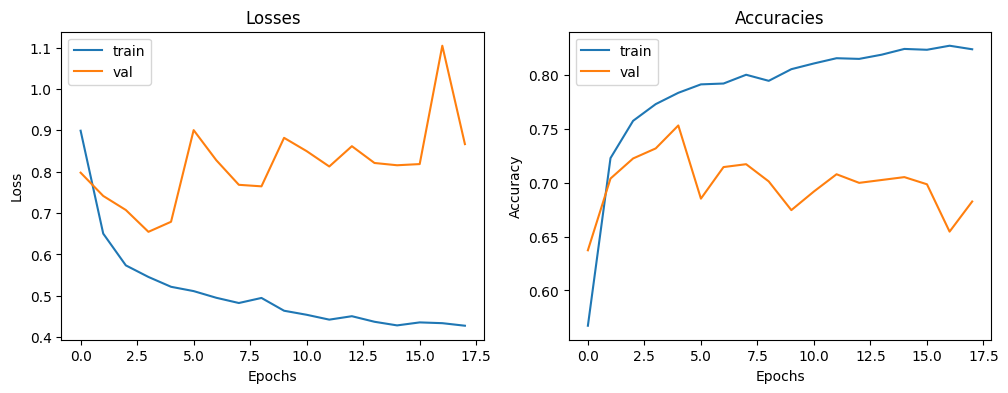

epoch = 18
Test correct = 512

Test total dataitem = 750

Test Accuracy = 0.6826666593551636

              precision    recall  f1-score   support

    negative       0.84      0.47      0.60       250
     neutral       0.61      0.78      0.68       250
    positive       0.69      0.80      0.74       250

    accuracy                           0.68       750
   macro avg       0.71      0.68      0.68       750
weighted avg       0.71      0.68      0.68       750



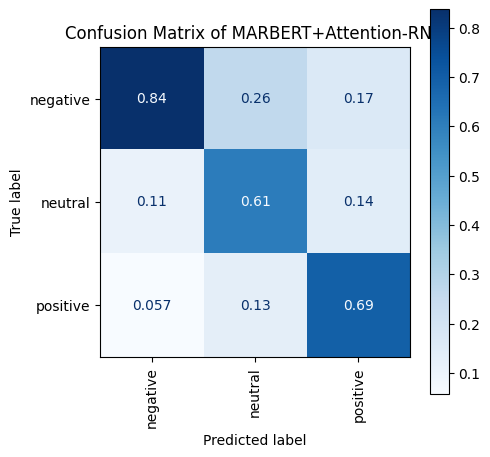

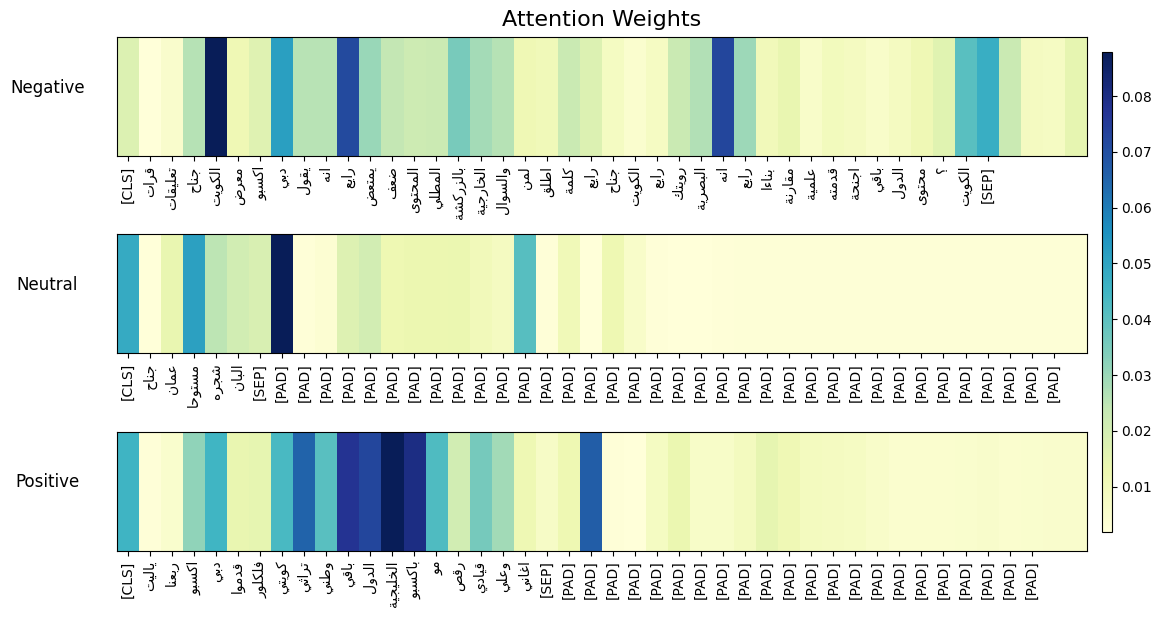

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 0.9080122543325444, val_loss =0.8515626789795941, accuracy = 0.543843150138855, val_accuracy = 0.6133333444595337


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.6242805924483978, val_loss =0.9798067810532275, accuracy = 0.7312941551208496, val_accuracy = 0.6106666326522827


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.539797117954249, val_loss =0.737819759546532, accuracy = 0.7744314074516296, val_accuracy = 0.7266666293144226


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.5106943777428723, val_loss =0.8170141935427676, accuracy = 0.7891764640808105, val_accuracy = 0.6706666350364685


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.488829269361317, val_loss =0.8405692902971312, accuracy = 0.7978039383888245, val_accuracy = 0.7053333520889282


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.49089816069407904, val_loss =0.727136786105262, accuracy = 0.7987450957298279, val_accuracy = 0.7373332977294922


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.47117736601741805, val_loss =0.7407653713309852, accuracy = 0.8059607744216919, val_accuracy = 0.7253333330154419


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.46286670706328664, val_loss =0.9043624152341906, accuracy = 0.8037647008895874, val_accuracy = 0.6706666350364685


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.46457462248232706, val_loss =0.8274474667207183, accuracy = 0.810039222240448, val_accuracy = 0.6933333277702332


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.4619669539217515, val_loss =0.9166376343468521, accuracy = 0.8094117641448975, val_accuracy = 0.6919999718666077


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.4555599661389995, val_loss =0.7990463354017331, accuracy = 0.8106666803359985, val_accuracy = 0.6893333196640015


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


loss = 0.45781368162356023, val_loss =0.6934244335356086, accuracy = 0.8122352957725525, val_accuracy = 0.7440000176429749


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.4352590184470218, val_loss =0.7854720885948286, accuracy = 0.8236863017082214, val_accuracy = 0.7160000205039978


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.41789508294455446, val_loss =0.7370866776930506, accuracy = 0.8332549333572388, val_accuracy = 0.7293333411216736


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.4166606482938841, val_loss =0.8048047700222146, accuracy = 0.8307451009750366, val_accuracy = 0.7106666564941406


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.40799629472972176, val_loss =0.7319963566646025, accuracy = 0.8352941274642944, val_accuracy = 0.7306666374206543


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.40855112302038504, val_loss =0.8809792148313466, accuracy = 0.8330980539321899, val_accuracy = 0.6826666593551636


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.413544592310234, val_loss =0.7165469964952403, accuracy = 0.8307451009750366, val_accuracy = 0.7479999661445618


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.40027350110766075, val_loss =0.9166368853493655, accuracy = 0.8349804282188416, val_accuracy = 0.6986666321754456


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.40579451968095015, val_loss =0.8676612801090434, accuracy = 0.8362352848052979, val_accuracy = 0.7039999961853027


<ipython-input-15-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


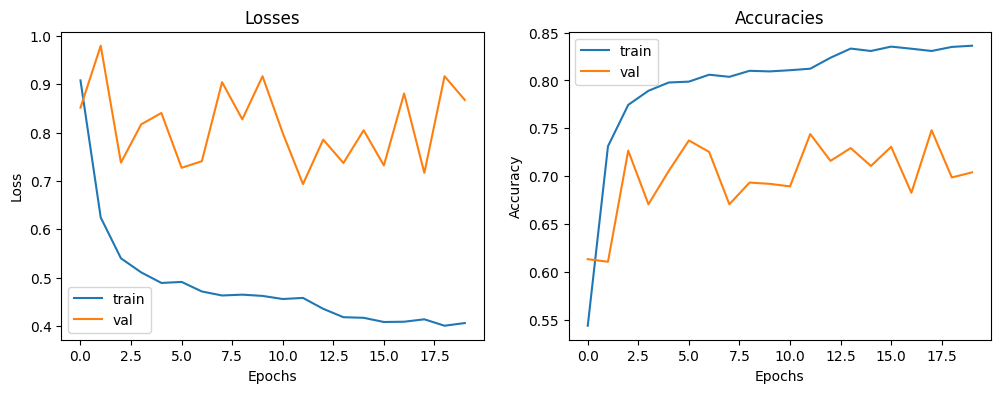

epoch = 20
Test correct = 528

Test total dataitem = 750

Test Accuracy = 0.7039999961853027

              precision    recall  f1-score   support

    negative       0.85      0.50      0.63       250
     neutral       0.62      0.84      0.71       250
    positive       0.73      0.77      0.75       250

    accuracy                           0.70       750
   macro avg       0.73      0.70      0.70       750
weighted avg       0.73      0.70      0.70       750



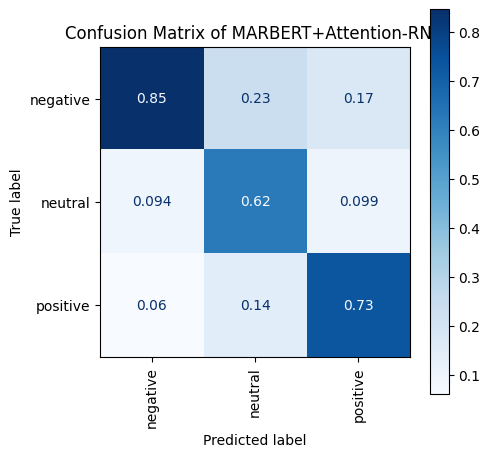

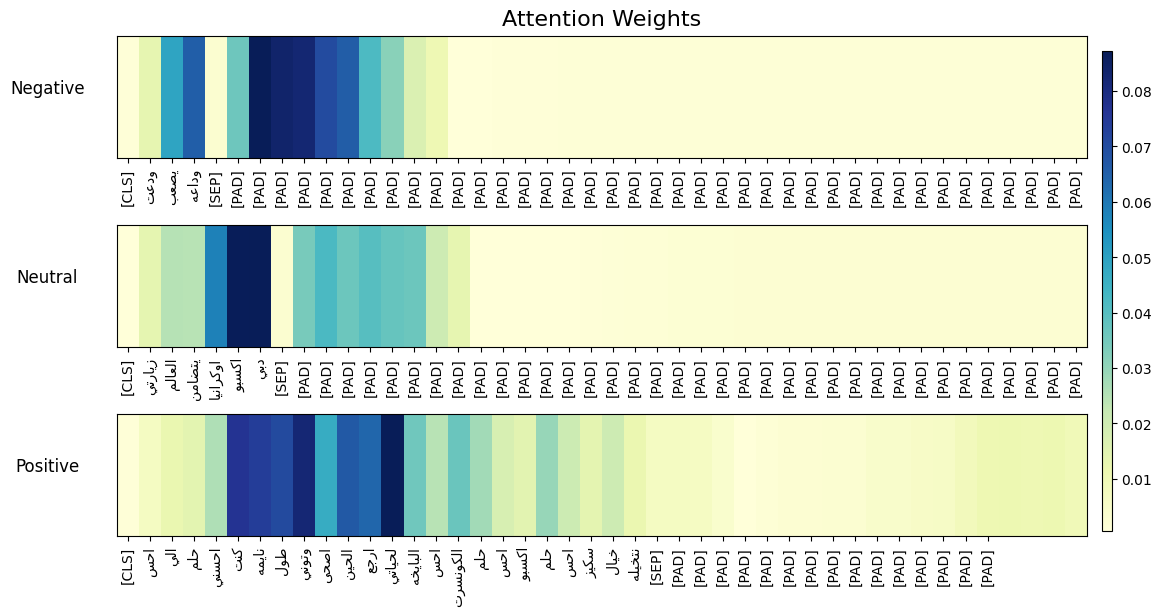

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=256
learning_rate=0.0003
droprate=0.2
num_epochs=[2,4,5,6,7,8,10,12,15,18,20]
for epoch in num_epochs:
  model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)
  print(f'epoch = {epoch}')
  test_and_report(model,test_loader,model_name,attention_added=True)

In [ ]:
#save the model
torch.save(model.state_dict(),'/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-RNN.pth')

<ipython-input-36-f9f9551f6b14>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/MARBERT+Atten

Test correct = 584

Test total dataitem = 750

Test Accuracy = 0.7786666750907898

              precision    recall  f1-score   support

    negative       0.77      0.88      0.82       250
     neutral       0.73      0.73      0.73       250
    positive       0.83      0.73      0.78       250

    accuracy                           0.78       750
   macro avg       0.78      0.78      0.78       750
weighted avg       0.78      0.78      0.78       750



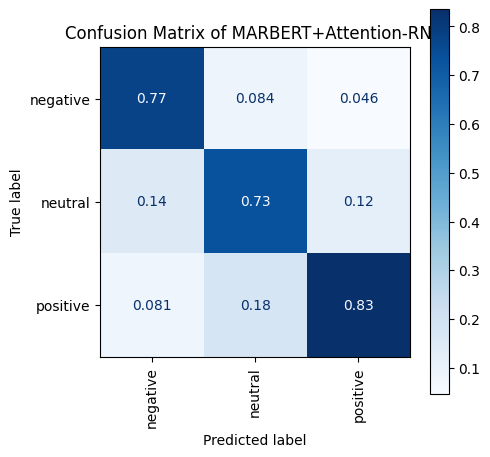

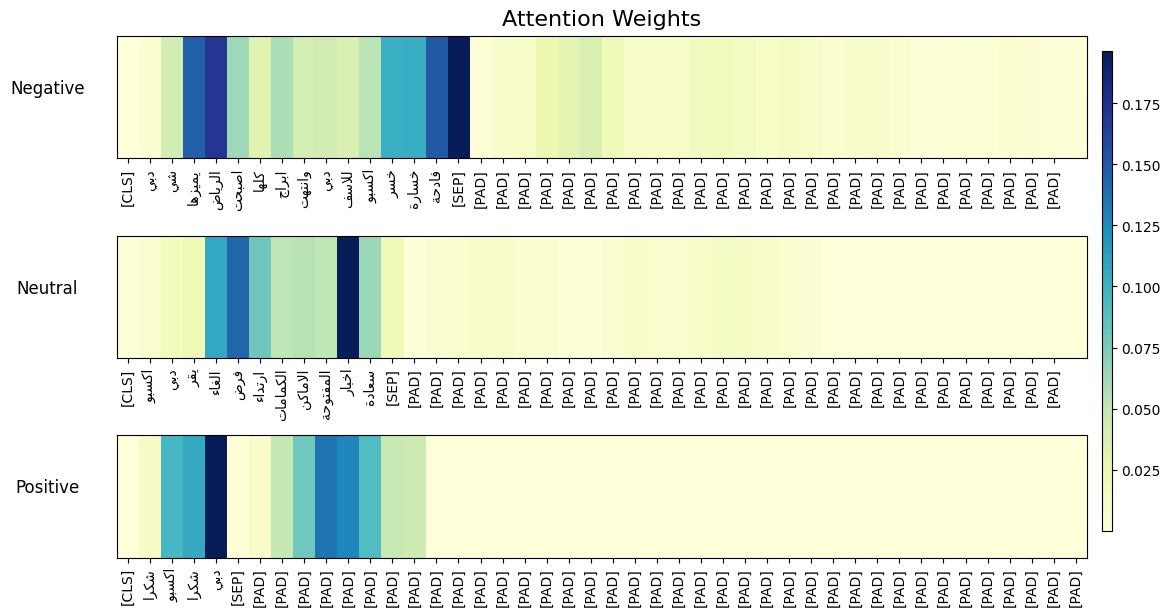

In [ ]:
#load the model
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=512
droprate=0.4
model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-RNN778.pth'))
# test
model_name='MARBERT+Attention-RNN'
test_and_report(model,test_loader,model_name,attention_added=True)

# Load Attention-LSTM

In [ ]:
class AttentionRNN_AraBERT(nn.Module):
  def __init__(self,hidden_size1,hidden_size2,num_layers,dider=True,droprate=0.2,num_classes=3):
    super().__init__()
    self.bert=BertModel.from_pretrained('UBC-NLP/MARBERT')
    # freeze the bert weights
    for param in self.bert.parameters():
      param.requires_grad=False

    self.embedding_dim=self.bert.config.hidden_size
    self.rnn_hidden_size=hidden_size1
    self.rnn=nn.LSTM(self.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.attention=AttentionLayer(hidden_size1*self.d)
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    # For Improvements, I've changed the intialization algorithm
    #initialize the rnn weights
    for name,param in self.rnn.named_parameters():
      if 'weight' in name:
        nn.init.xavier_normal_(param)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
  def forward(self,input_ids,attention_mask):
    with torch.no_grad():
      embeddings=self.bert(input_ids,attention_mask)
    x=embeddings[0]
    x=self.dropout(x)
    x,h=self.rnn(x)
    x,attention_weights=self.attention(x)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x,attention_weights

Epoch 1: 100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


loss = 0.8009195327223333, val_loss =0.8380500291171736, accuracy = 0.6214901804924011, val_accuracy = 0.6266666650772095


Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


loss = 0.5504557428594591, val_loss =0.8435163788261876, accuracy = 0.7720784544944763, val_accuracy = 0.6679999828338623


Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


loss = 0.5101329017325885, val_loss =0.7661599944506673, accuracy = 0.7938823699951172, val_accuracy = 0.6853333115577698


Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


loss = 0.48247561489752316, val_loss =0.7900291820774393, accuracy = 0.8051764965057373, val_accuracy = 0.687999963760376


Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


loss = 0.48465684394092057, val_loss =0.8087919764021153, accuracy = 0.8014118075370789, val_accuracy = 0.6800000071525574


Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


loss = 0.4612037783952523, val_loss =0.7532799693604809, accuracy = 0.8117647171020508, val_accuracy = 0.699999988079071


Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


loss = 0.4331912176558639, val_loss =0.6819095807946671, accuracy = 0.8291764855384827, val_accuracy = 0.734666645526886


Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


loss = 0.41676020639407, val_loss =0.715549223826745, accuracy = 0.8304314017295837, val_accuracy = 0.7080000042915344


Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


loss = 0.4248930244552168, val_loss =0.6551978361685015, accuracy = 0.8258823752403259, val_accuracy = 0.7279999852180481


Epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


loss = 0.41645766159495406, val_loss =0.9655783067636136, accuracy = 0.8307451009750366, val_accuracy = 0.6693333387374878


Epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


loss = 0.40287662711322203, val_loss =0.8257267330264962, accuracy = 0.8291764855384827, val_accuracy = 0.7146666646003723


Epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


loss = 0.3869022925777824, val_loss =1.0363460267506295, accuracy = 0.8407843112945557, val_accuracy = 0.6786666512489319


Epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


loss = 0.4036110007141948, val_loss =0.710700017063694, accuracy = 0.8329411745071411, val_accuracy = 0.7373332977294922


Epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


loss = 0.3806454658567658, val_loss =0.7183113699211275, accuracy = 0.8454902172088623, val_accuracy = 0.7400000095367432


Epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


A model was saved at accuracy = 0.7893333435058594
loss = 0.3689801041740502, val_loss =0.6382690594679622, accuracy = 0.8484706282615662, val_accuracy = 0.7893333435058594


Epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 16: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


loss = 0.3586519325195981, val_loss =0.8591847577126188, accuracy = 0.8542745113372803, val_accuracy = 0.7106666564941406


Epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 17: 100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


loss = 0.35167510361997245, val_loss =0.7035466180043474, accuracy = 0.8534902334213257, val_accuracy = 0.7586666345596313


Epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 18: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


loss = 0.33982467575348096, val_loss =0.8819401320173977, accuracy = 0.869019627571106, val_accuracy = 0.7173333168029785


Epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 19: 100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


loss = 0.3270073108921808, val_loss =0.9255444209773738, accuracy = 0.8655686378479004, val_accuracy = 0.6946666836738586


Epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20: 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


loss = 0.3320255550698116, val_loss =1.1826206712985743, accuracy = 0.8616470694541931, val_accuracy = 0.6786666512489319


<ipython-input-9-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


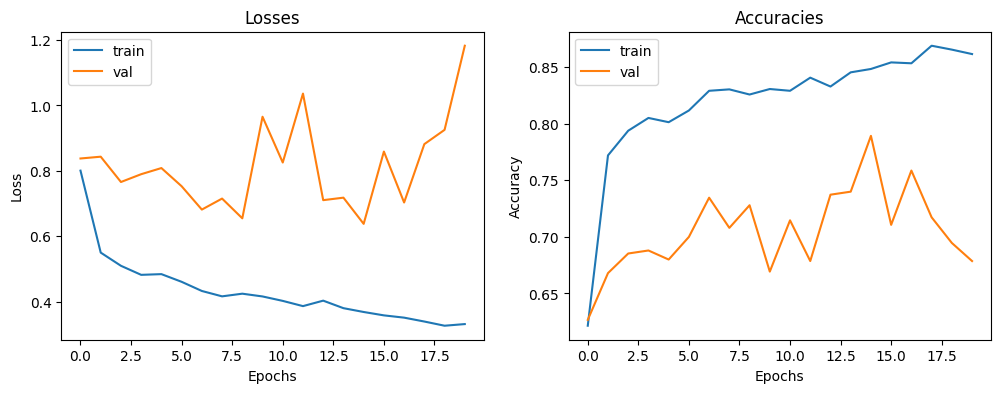

In [ ]:
#load the model
bidirectional=True
num_layers=2
hidden_size1=512
hidden_size2=128
droprate=0.4
learning_rate=0.001
epoch=20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,test_loader,attention_added=True)

<ipython-input-23-9441c7604544>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/MARBERT+Atten

Test correct = 592

Test total dataitem = 750

Test Accuracy = 0.7893333435058594

              precision    recall  f1-score   support

    negative       0.80      0.83      0.81       250
     neutral       0.80      0.74      0.77       250
    positive       0.77      0.80      0.79       250

    accuracy                           0.79       750
   macro avg       0.79      0.79      0.79       750
weighted avg       0.79      0.79      0.79       750



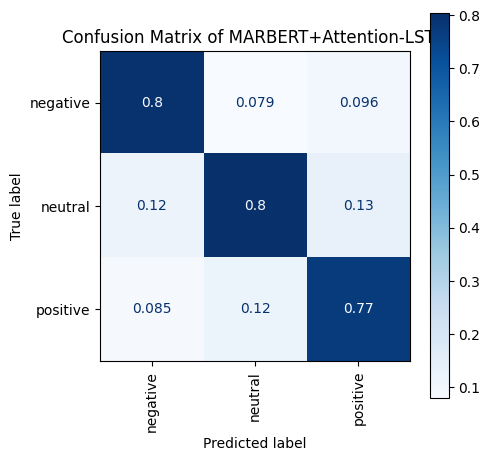

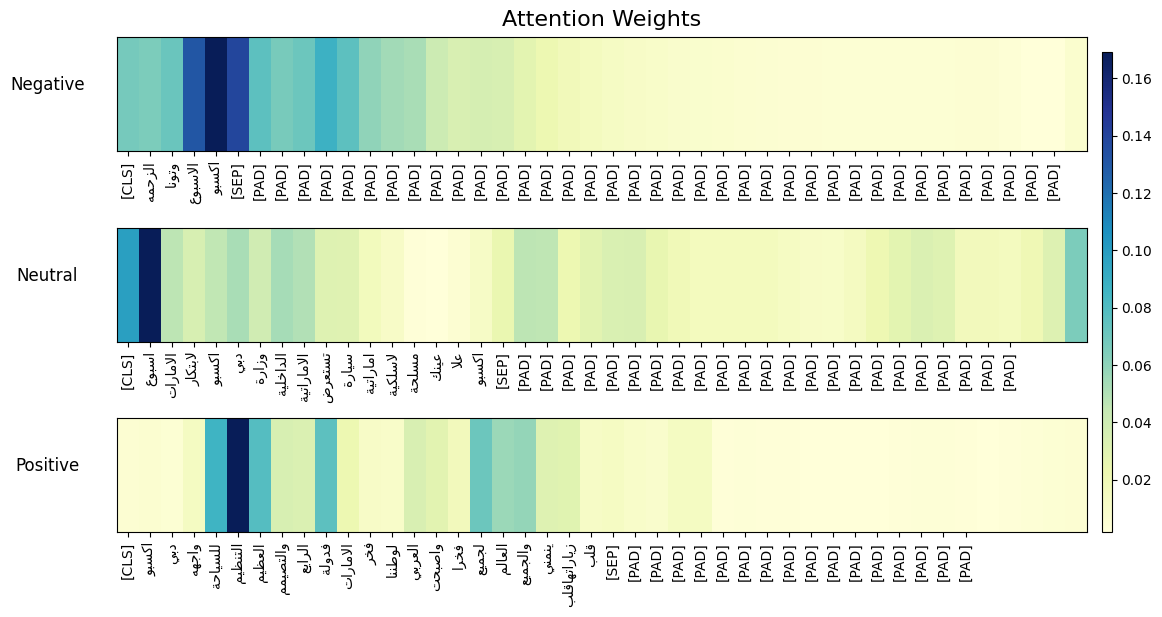

In [ ]:
model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-LSTM789.pth'))
# test
model_name='MARBERT+Attention-LSTM'
test_and_report(model,test_loader,model_name,attention_added=True)